In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from kneed import KneeLocator
import joblib
shap.initjs()
task_name = '02'

In [2]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open(task_name + '.comparer', 'rb') as f:
        comparer = pickle.load(f)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
feature_names = X.columns.to_numpy()
class_names = y.unique().astype(str)
X.describe()

CRIM          ZN       INDUS         NOX          RM         AGE  \
count  246.000000  246.000000  246.000000  246.000000  246.000000  246.000000   
mean     2.720010   12.841063   11.718208    0.572581    6.511388    1.304878   
std      6.388147   25.552540    7.290396    0.125307    0.889747    0.813494   
min      0.009060    0.000000    1.210000    0.389000    3.561000    0.000000   
25%      0.099321    0.000000    4.243588    0.462112    5.882000    1.000000   
50%      0.540032    0.000000    9.900000    0.544000    6.315500    2.000000   
75%      3.181873   20.000000   18.100000    0.638740    7.134552    2.000000   
max     73.534100  100.000000   25.650000    0.871000    8.638029    2.000000   

              DIS         RAD         TAX     PTRATIO       LSTAT  
count  246.000000  246.000000  246.000000  246.000000  246.000000  
mean     3.501706    9.346908  403.132604   18.125578   11.736981  
std      2.007156    8.493772  165.416533    2.524334    7.372550  
min      1.137912    1.000000  188.000000   13.000000    1.763949  
25%      1.967365    4.000000  273.000000   15.707491    5.008267  
50%      2.866600    5.000000  362.186013   18.571912    9.950000  
75%      4.621654    8.000000  461.000000   20.200000   17.091674  
max     10.710300   24.000000  679.526743   22.000000   36.980000

In [4]:
X['AGE'].value_counts()

2.0    130
1.0     61
0.0     55
Name: AGE, dtype: int64

In [7]:
clf_a = joblib.load('model_A.joblib')
clf_b = joblib.load('model_B.joblib')
comparer = ModelComparer(clf_a, clf_b, feature_names)
with open(task_name + '.comparer', 'wb') as f:
    pickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


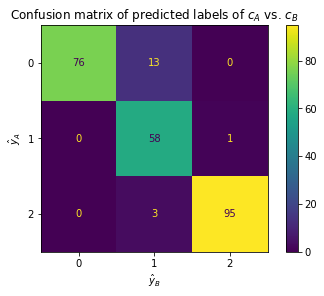

In [5]:
comparer.plot_confusion_matrix(X)

In [ ]:
%%time
masker = Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [9]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

In [ ]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

Feature importances are pretty similar, with RAD being less important to A, AGE less important to B. NOX has nearly no importance to neither classifier.

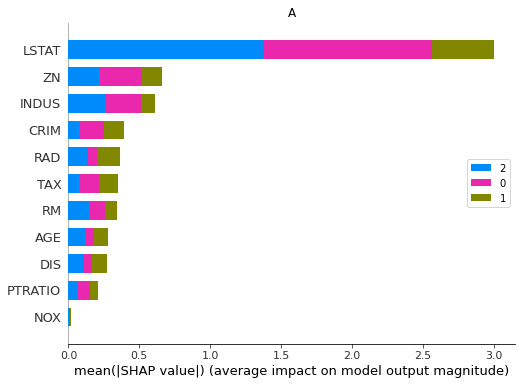

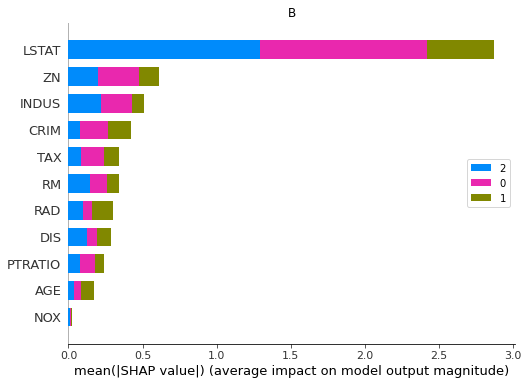

In [38]:
plot_feature_importance_bar(explanations.indiv.log_odds.A, 'A')
plot_feature_importance_bar(explanations.indiv.log_odds.B, 'B')

In [39]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)

In [40]:
feature_order = feature_order[:-1]

In [60]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.log_odds.A[:, [feature_idx]])
    plot_feature_importance_scatter(explanations.indiv.log_odds.B[:, [feature_idx]])
    plot_feature_effects_comparison(color=is_pred_diff,
                                    **{'A': explanations.indiv.log_odds.A[:, [feature_idx]],
                                       'B': explanations.indiv.log_odds.B[:, [feature_idx]]})
it = iter(feature_order)

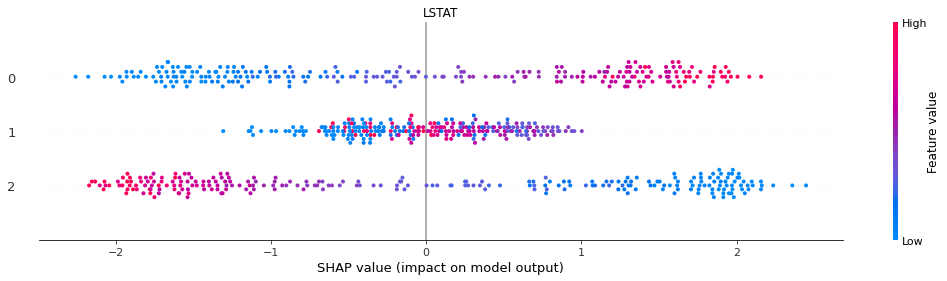

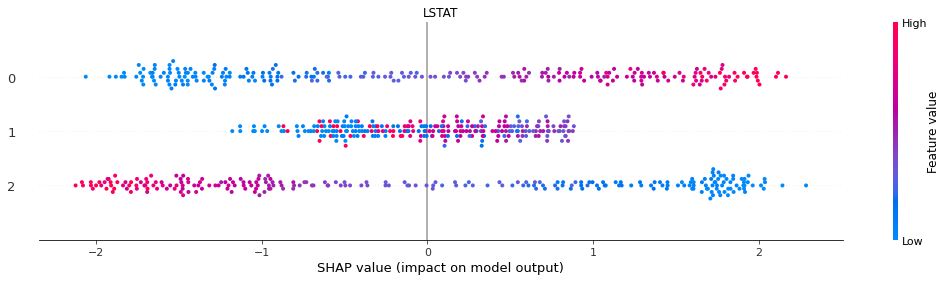

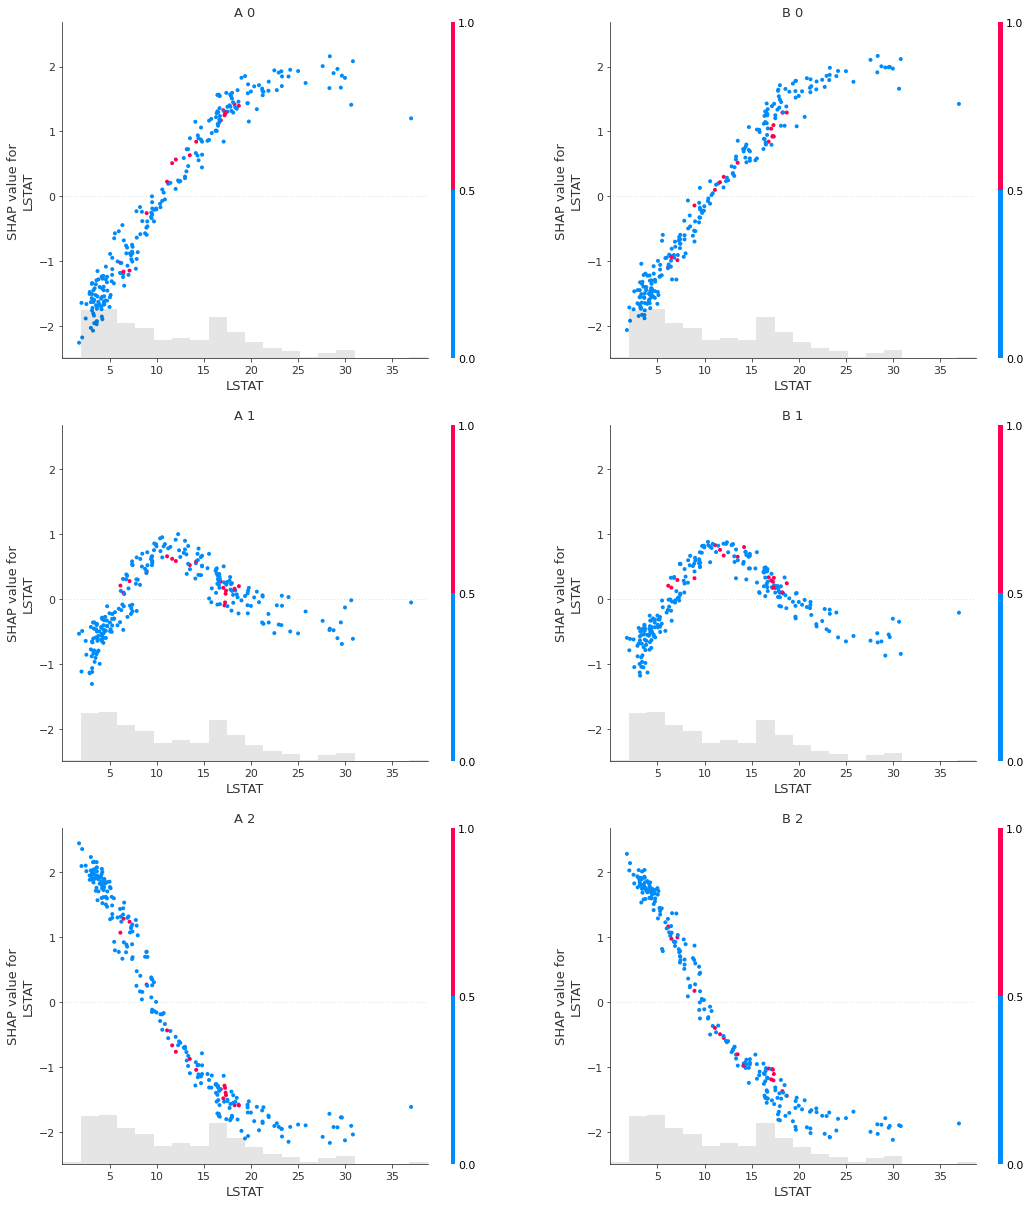

In [61]:
plot_next_feature()

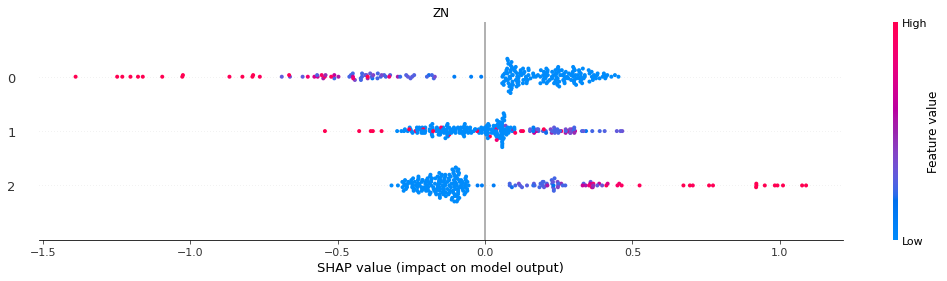

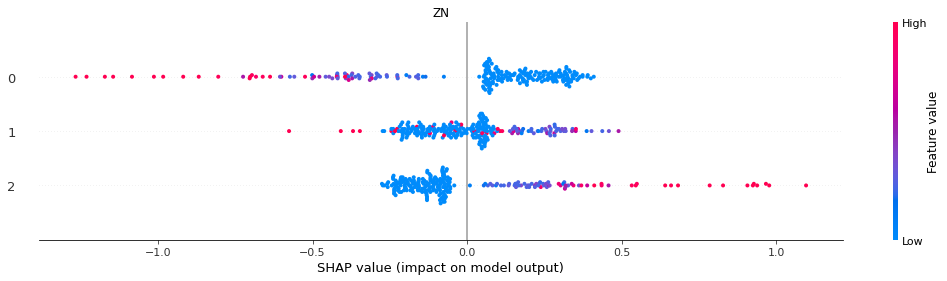

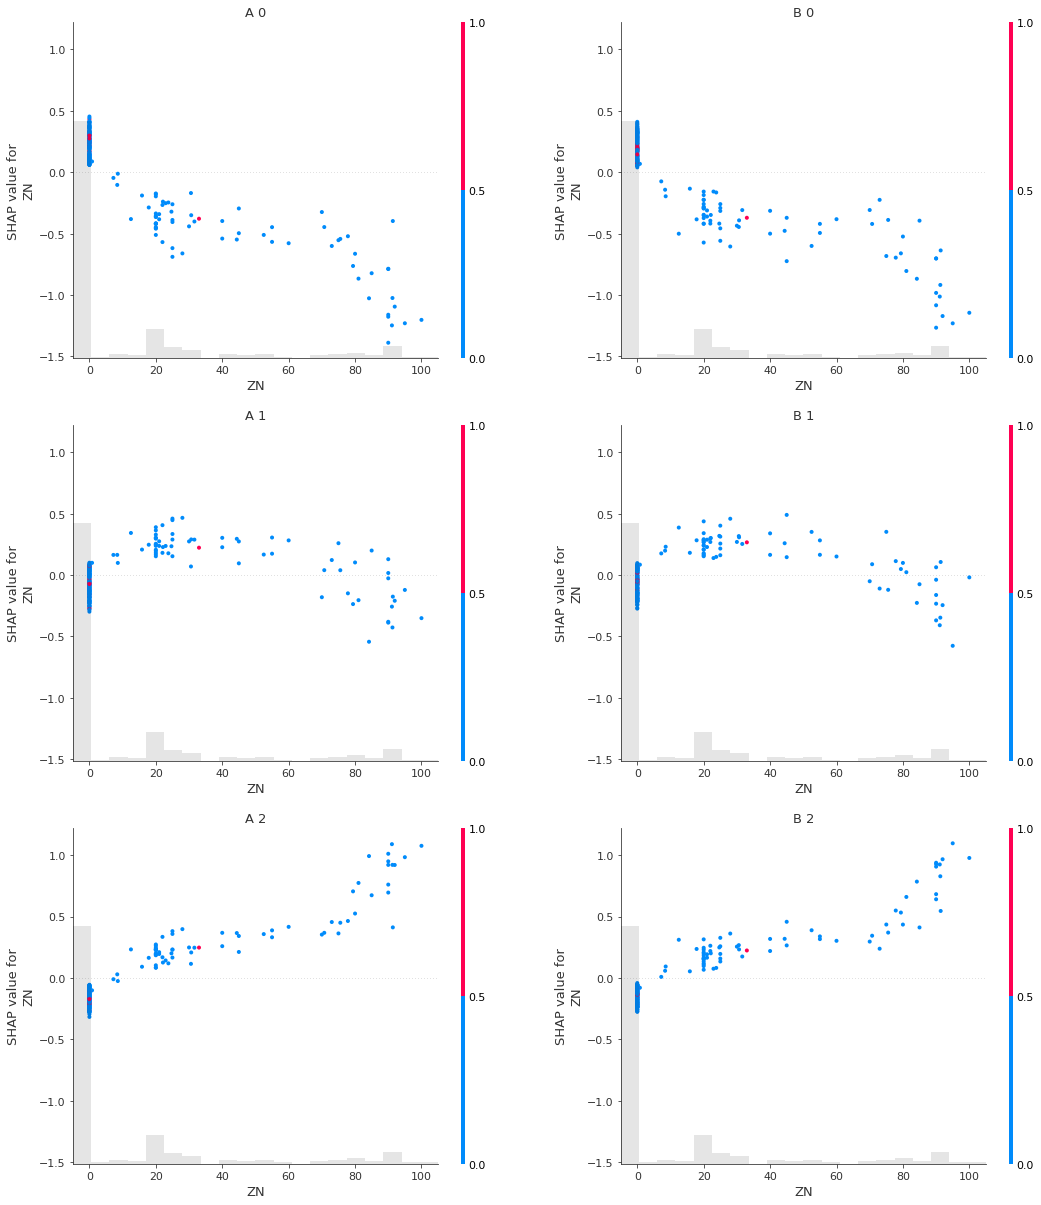

In [62]:
plot_next_feature()

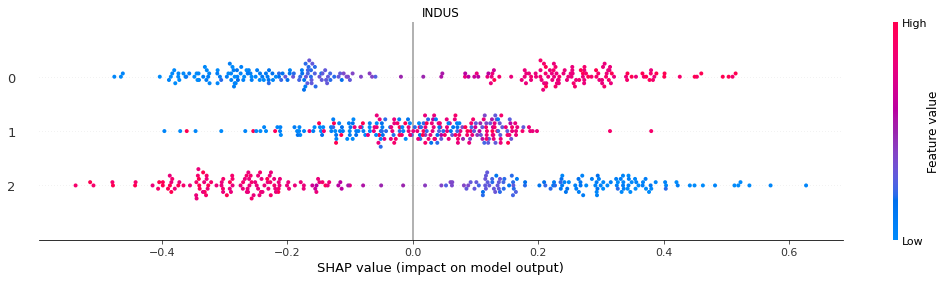

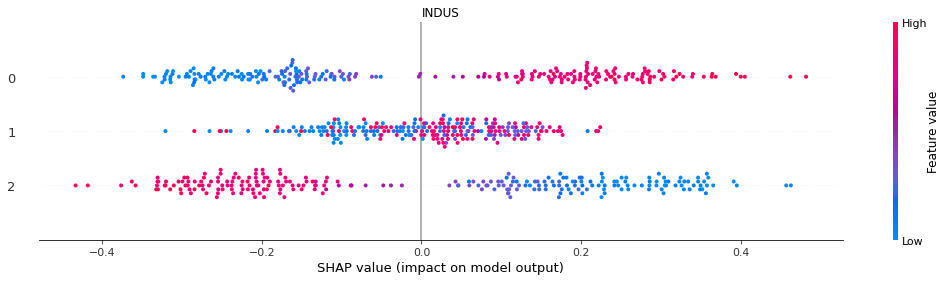

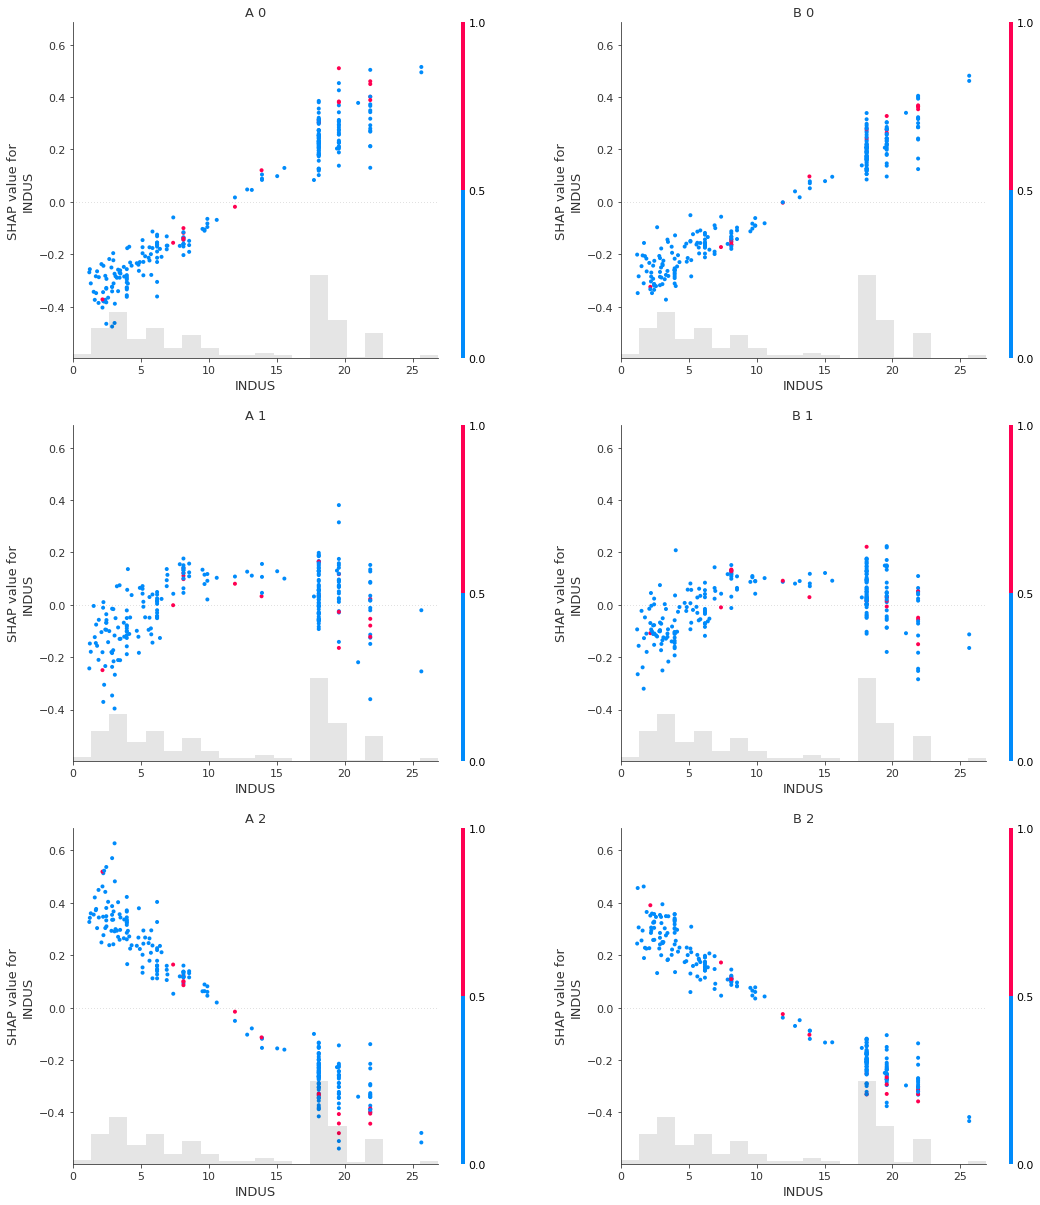

In [63]:
plot_next_feature()

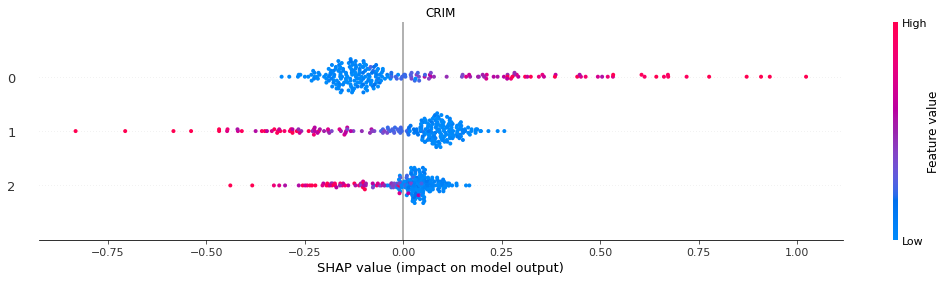

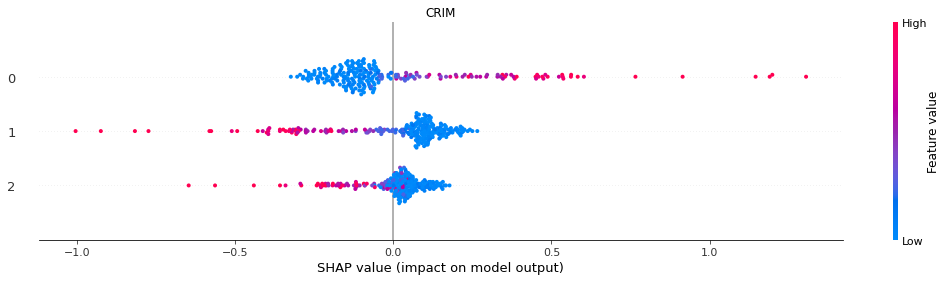

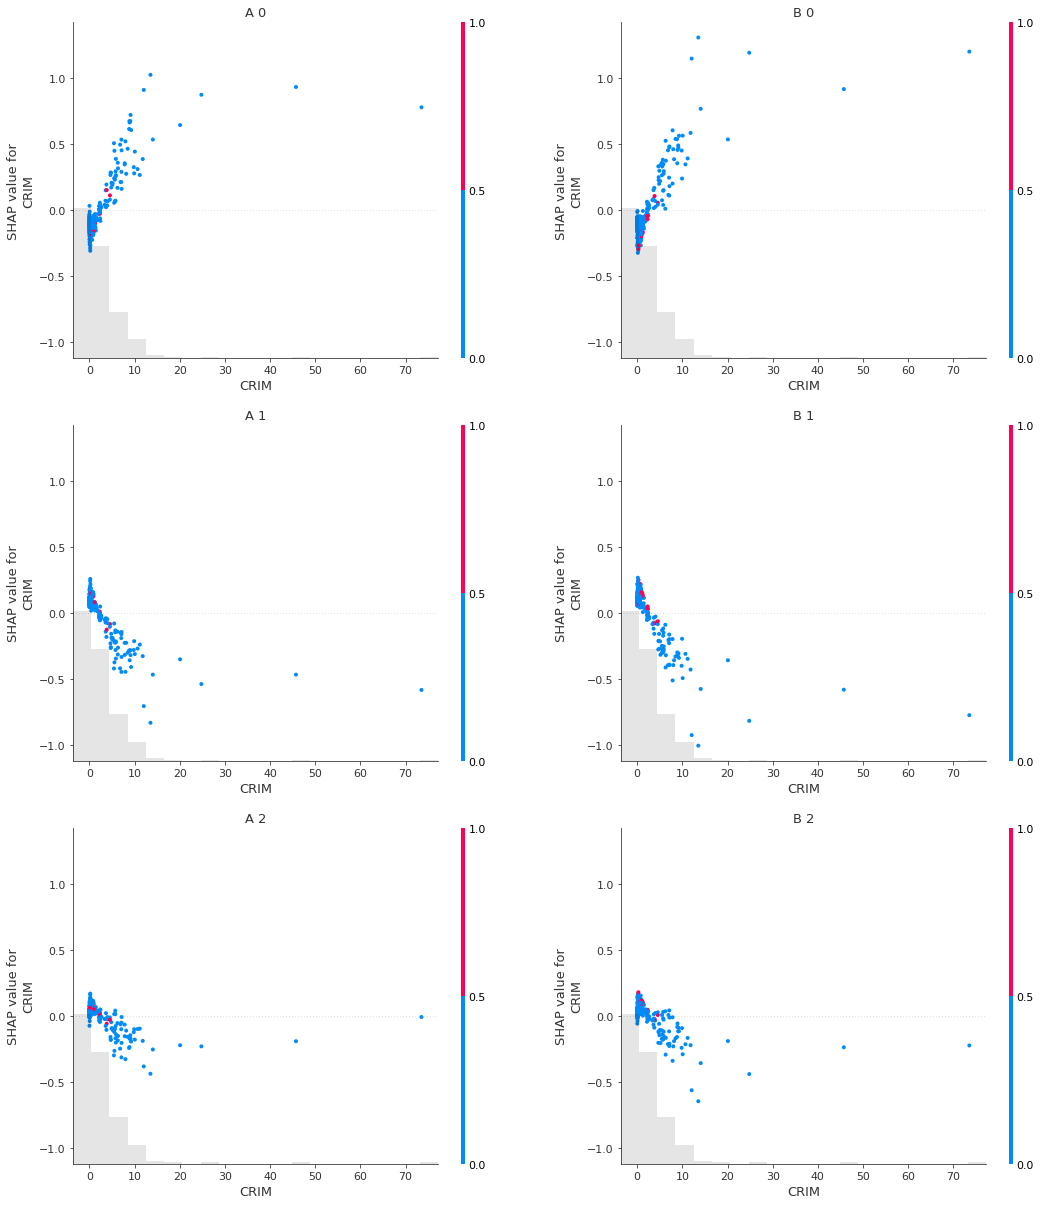

In [64]:
plot_next_feature()

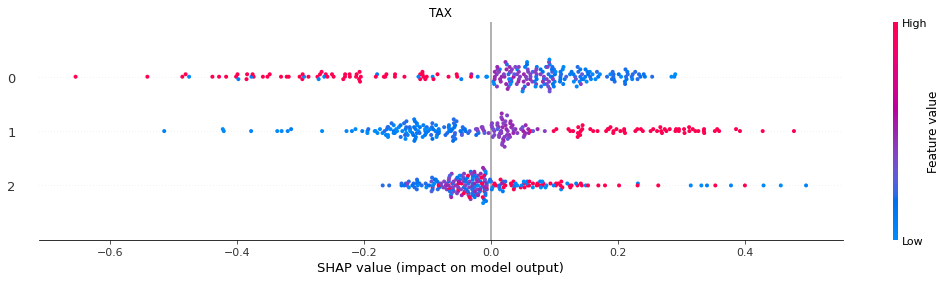

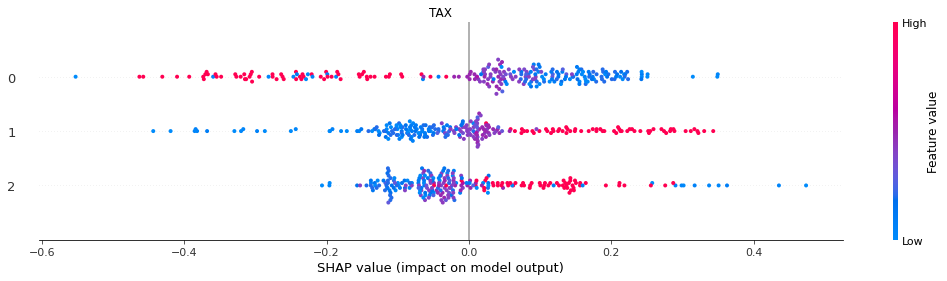

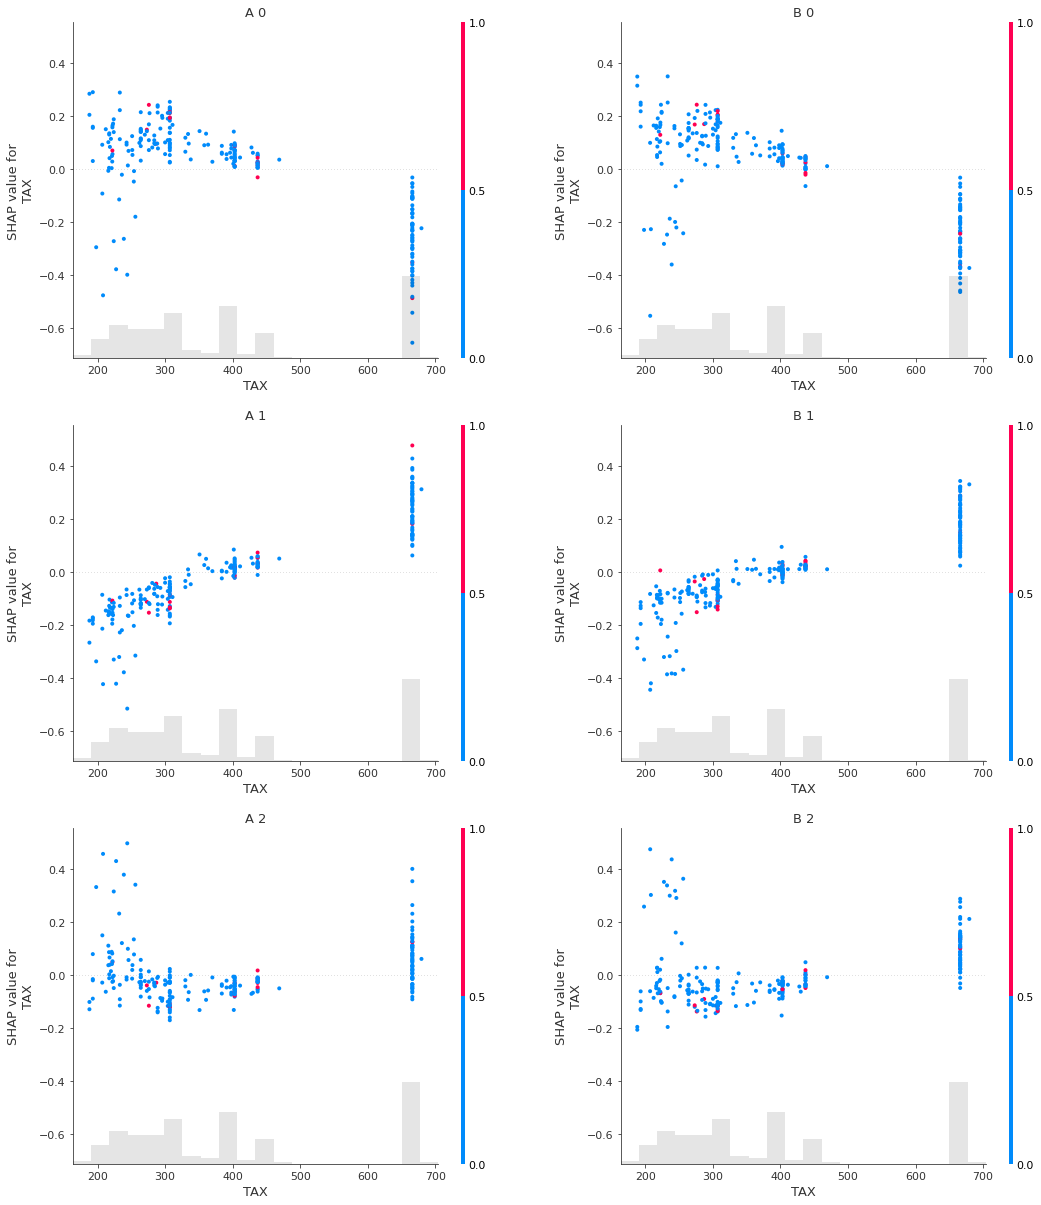

In [65]:
plot_next_feature()

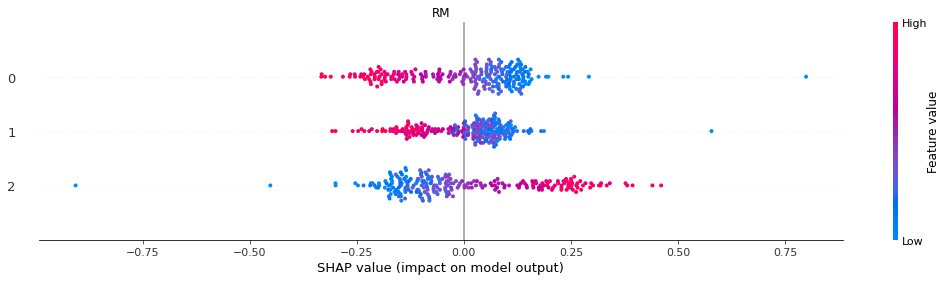

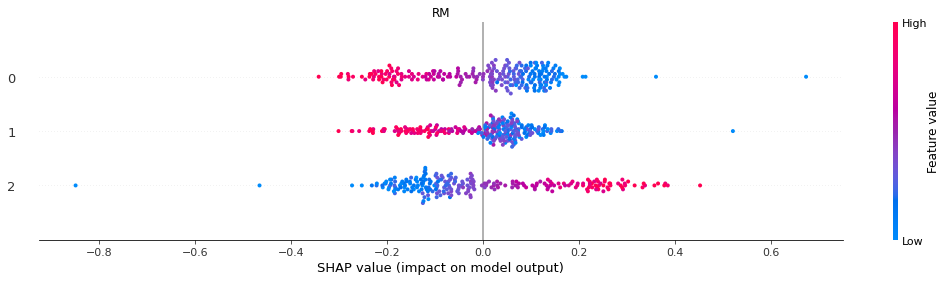

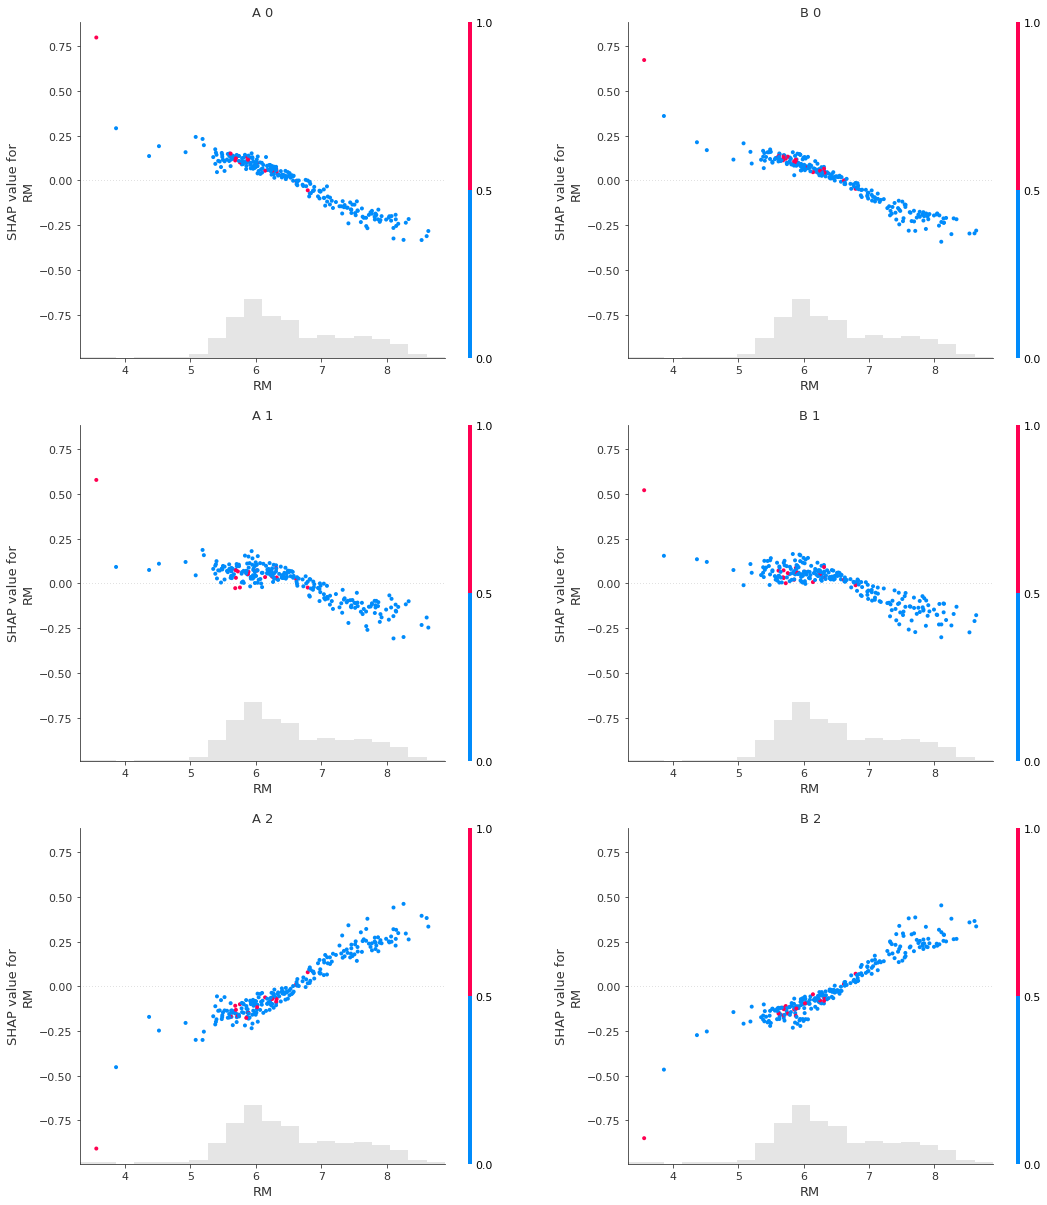

In [66]:
plot_next_feature()

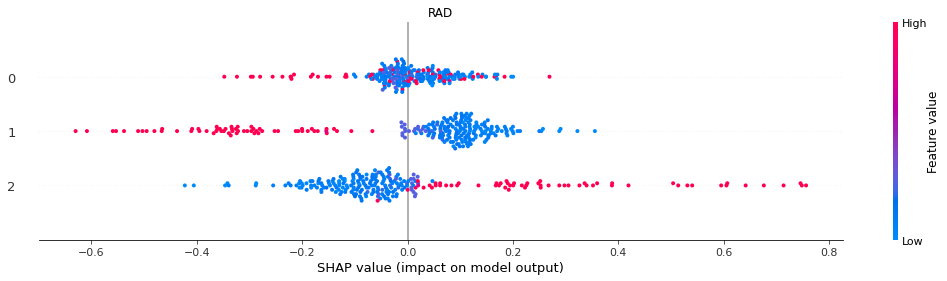

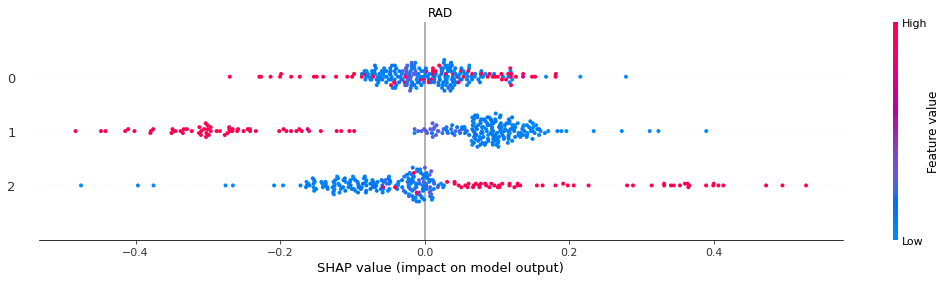

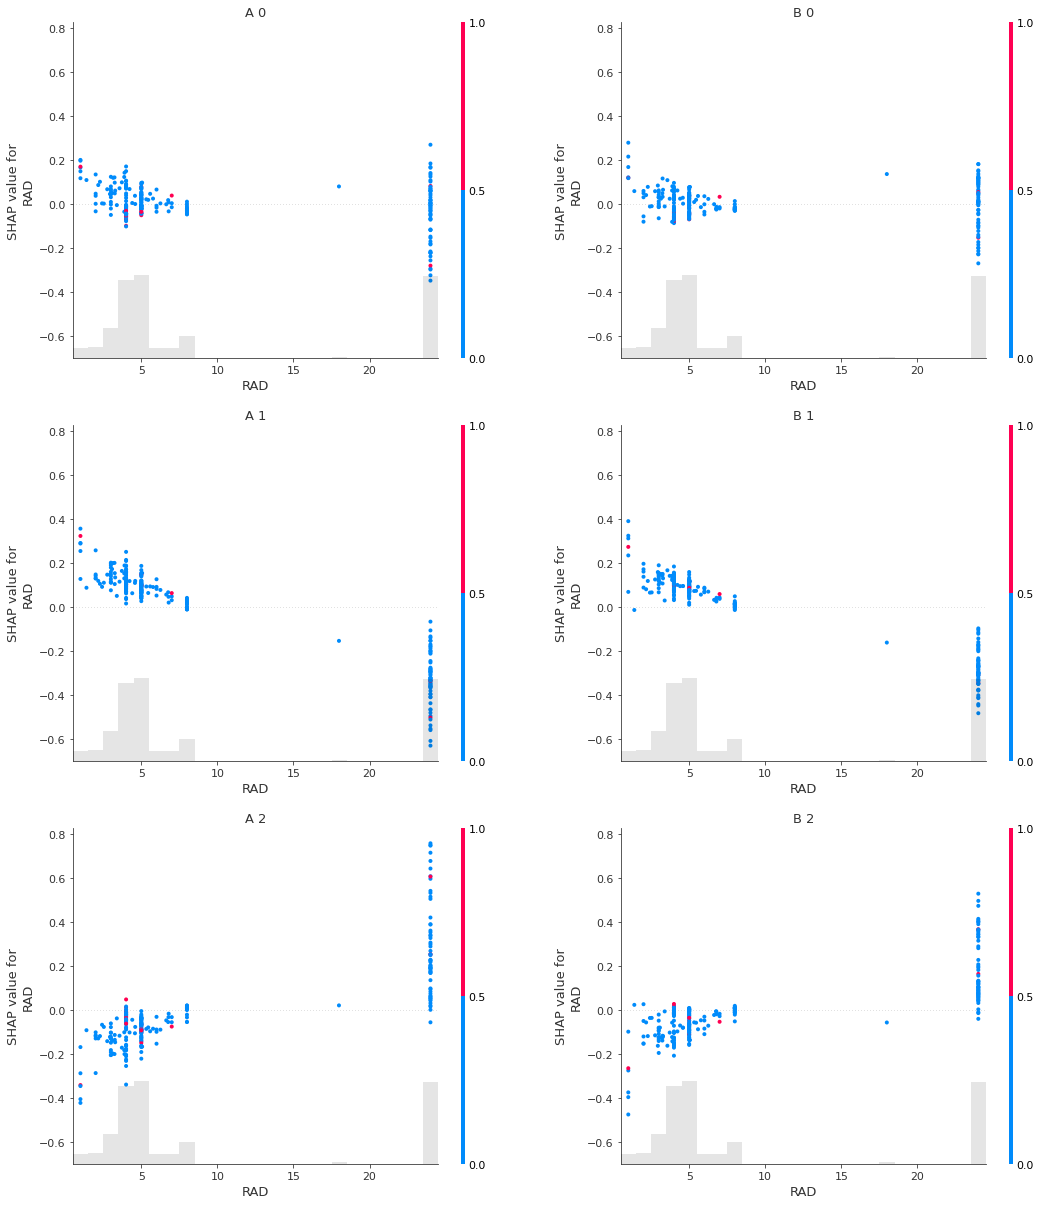

In [67]:
plot_next_feature()

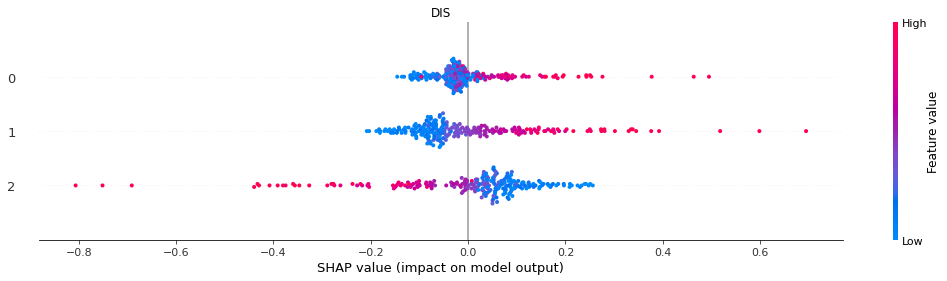

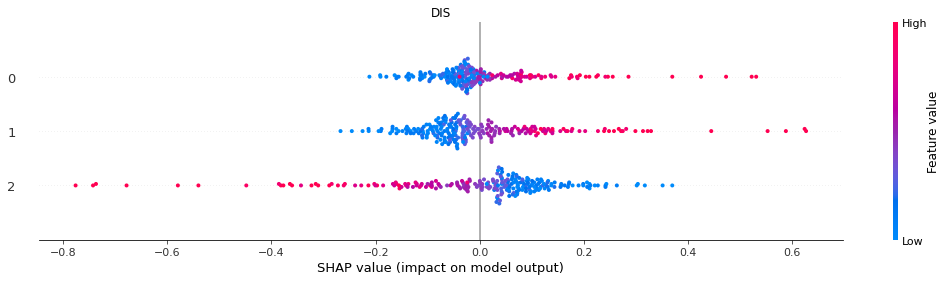

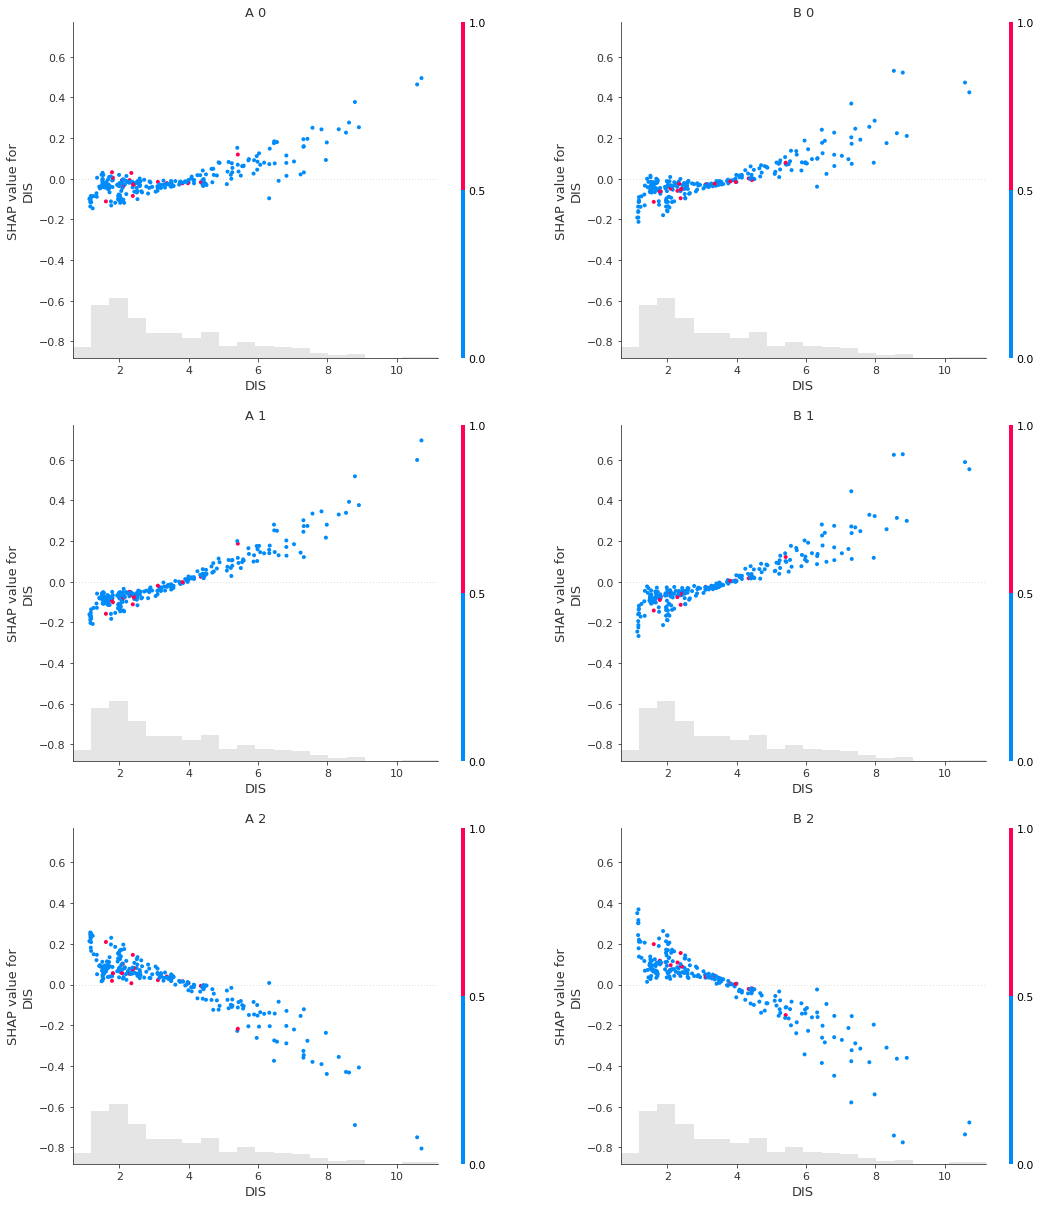

In [68]:
plot_next_feature()

AGE has more differences than the other features. It has linear effects for both classifiers, but with opposite directions.

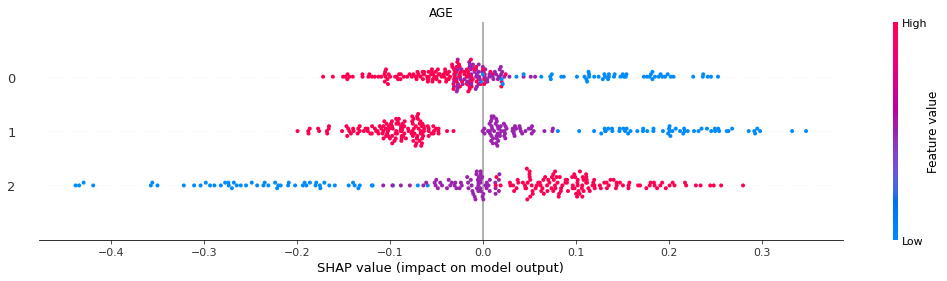

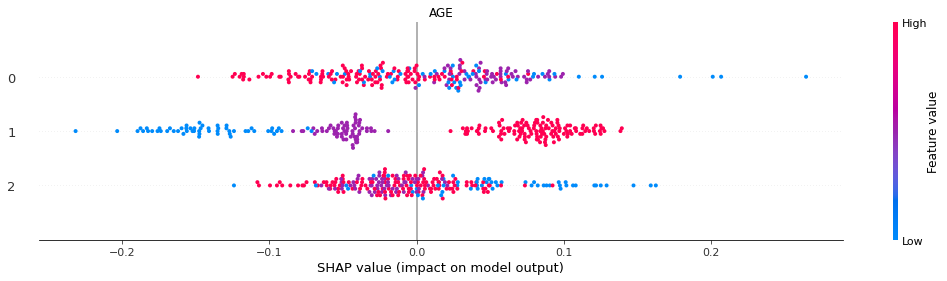

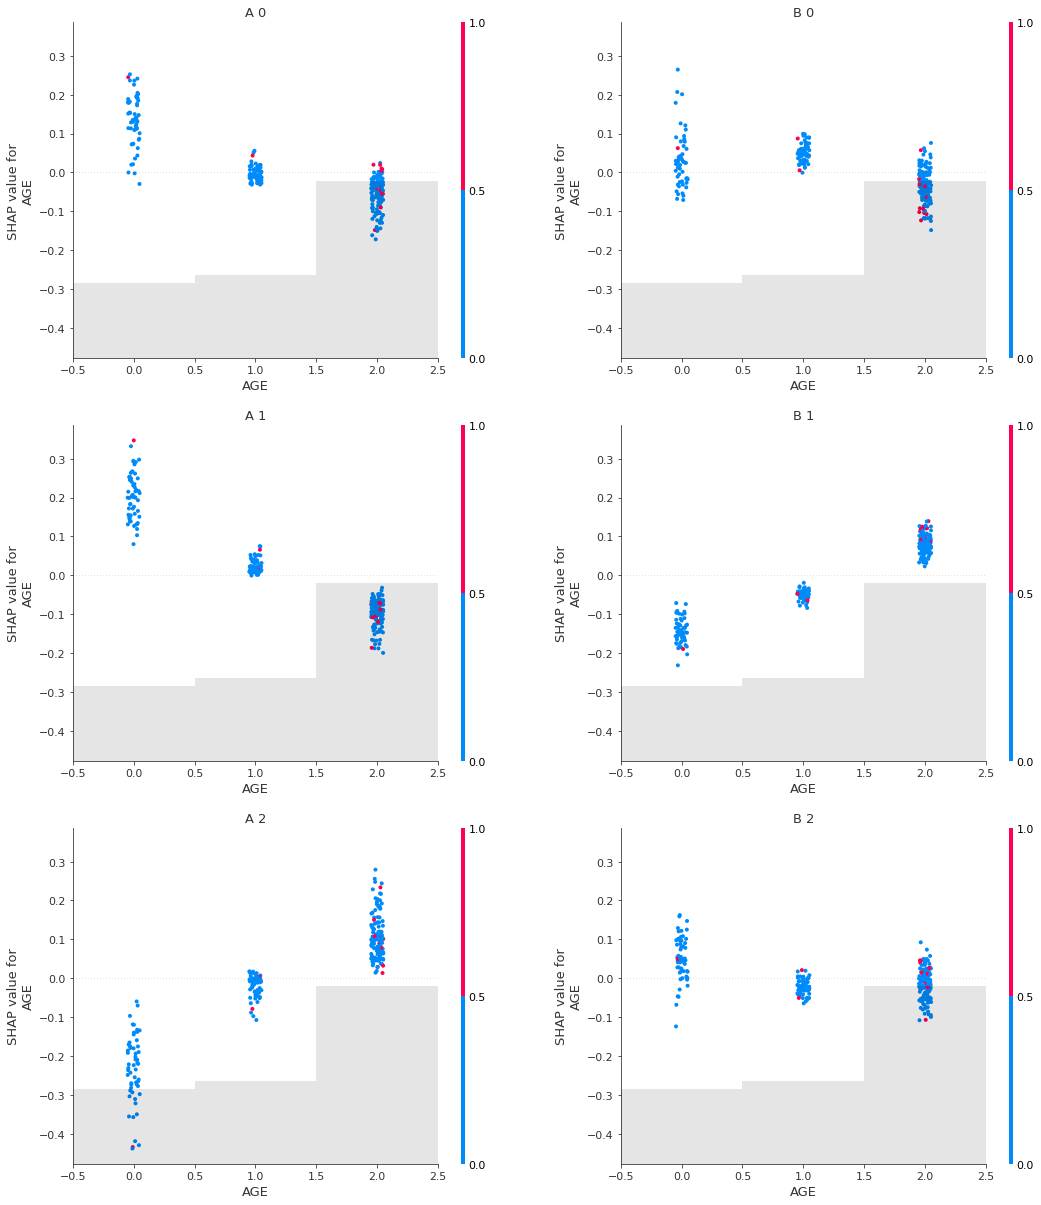

In [69]:
plot_next_feature()

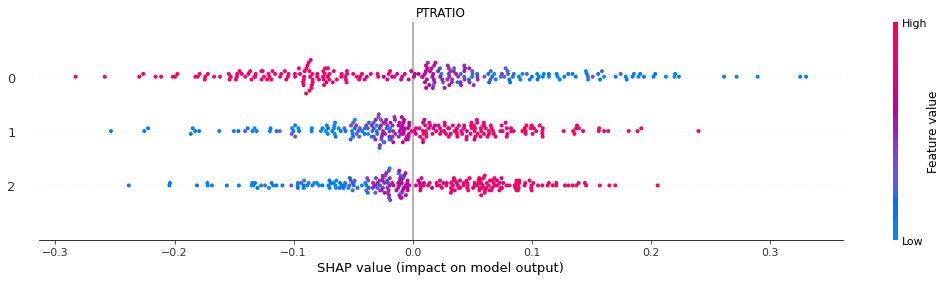

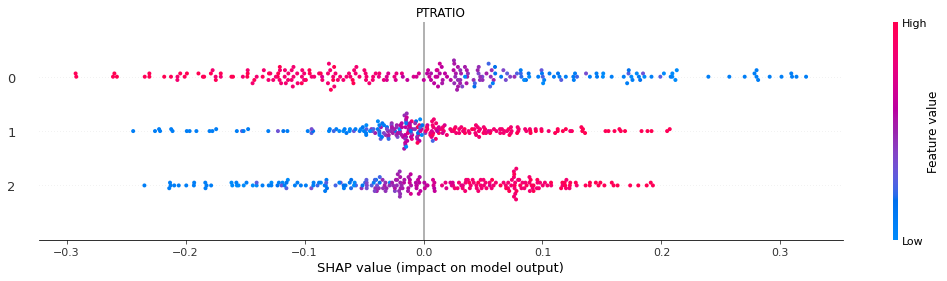

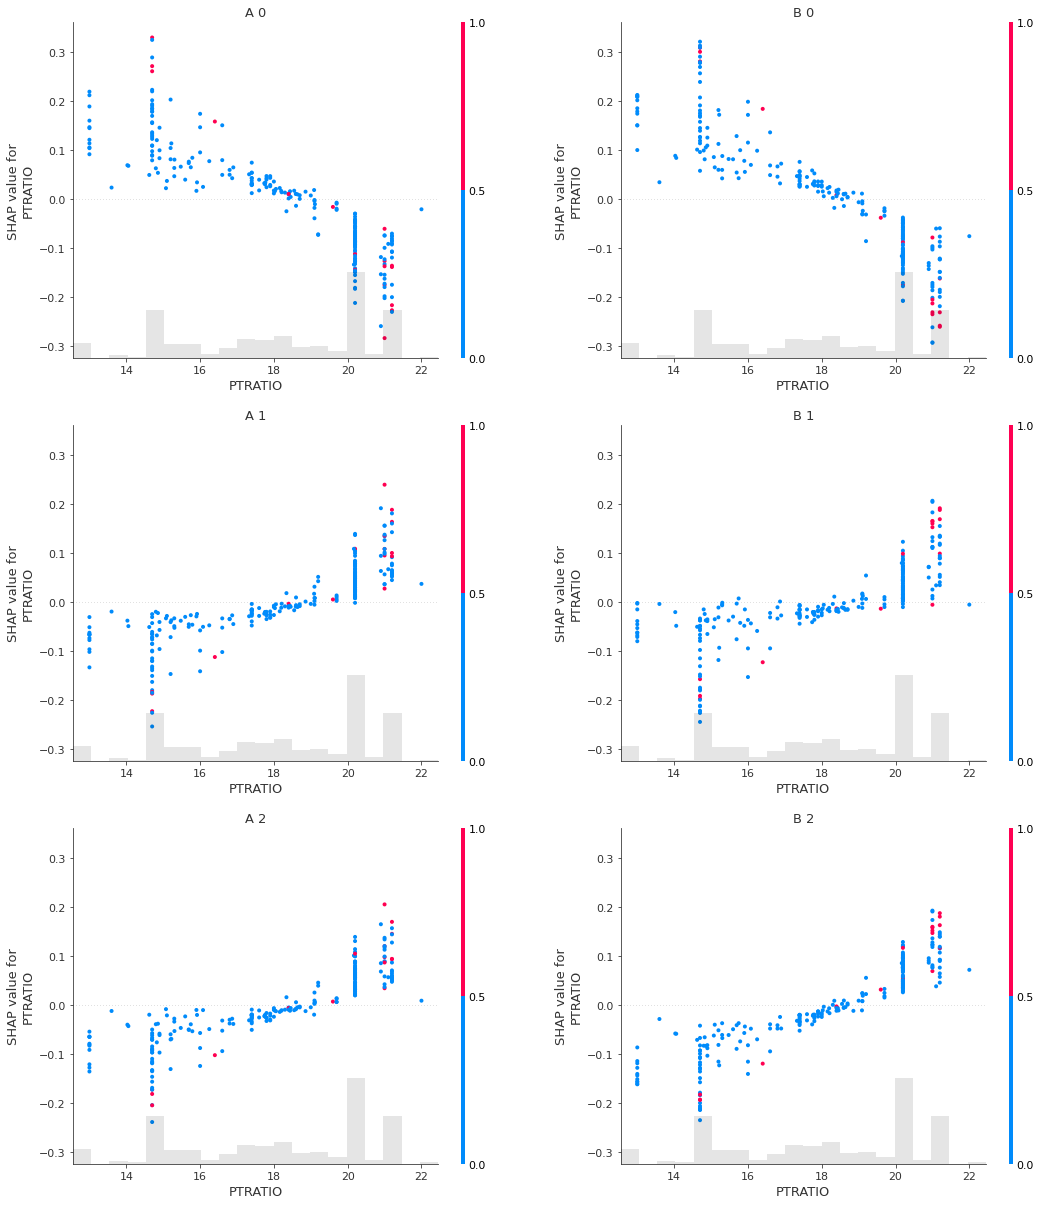

In [70]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

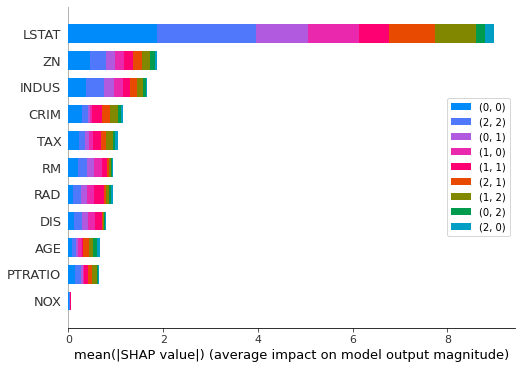

In [71]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(explanations.mclass_diff.log_odds)

4

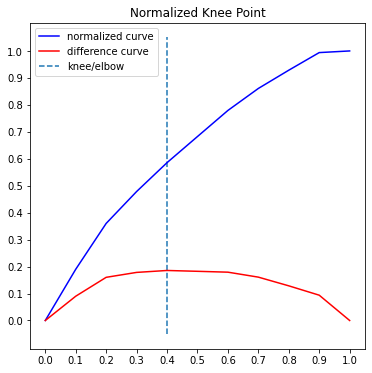

In [72]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
# feature_order = feature_order[:n_important_features]
n_important_features

We see three groups:
1. $(0,0)$ and $(2,2)$ are of highest importance
2. $(0,1)$, $(1,0)$, $(1,1)$, $(2,1)$, $(1,2)$ are of medium importance
3. $(0,2)$ and $(2,0)$ are of least importance

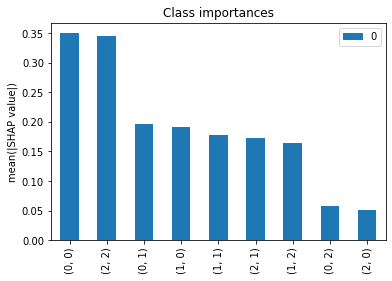

In [25]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

Although the knee locator says that I can cut off after the first 5 classes, I'll additionally include $(2,1)$ and $(1,2)$ because there are instances actually classified as this.

5

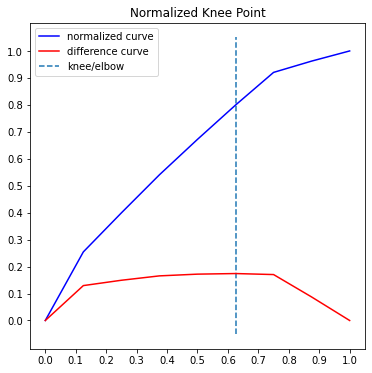

In [86]:
kneedle = KneeLocator(np.arange(class_importances.shape[0]),
                      np.cumsum(-np.sort(-class_importances)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_classes = kneedle.knee
n_important_classes

In [89]:
class_order = np.setdiff1d(np.arange(class_order.shape[0]), class_order[-2:])

In [108]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [feature_idx]], class_order=class_order)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[:4]], color=is_pred_diff)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx], class_order[3:]], color=is_pred_diff)
it = iter(feature_order)

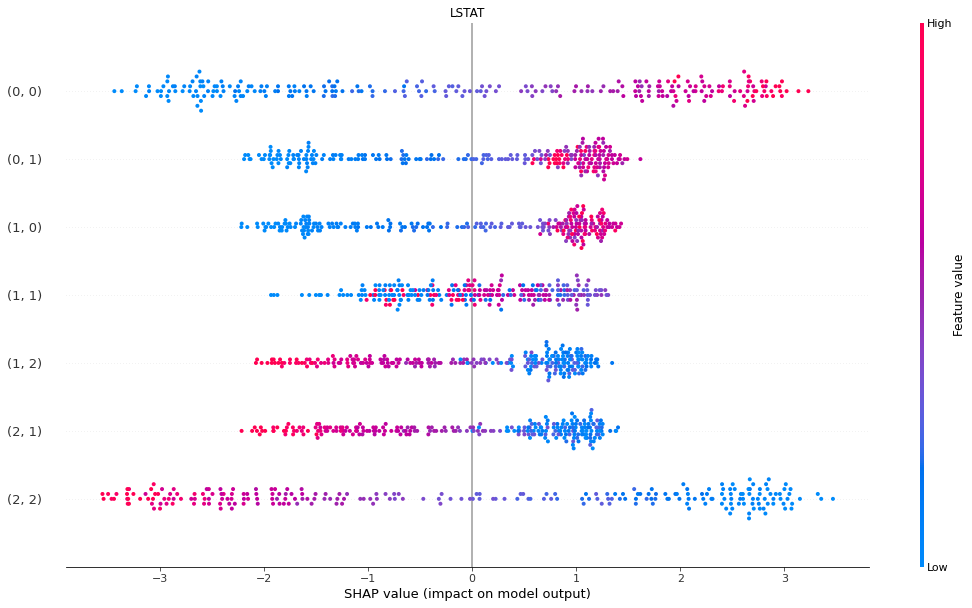

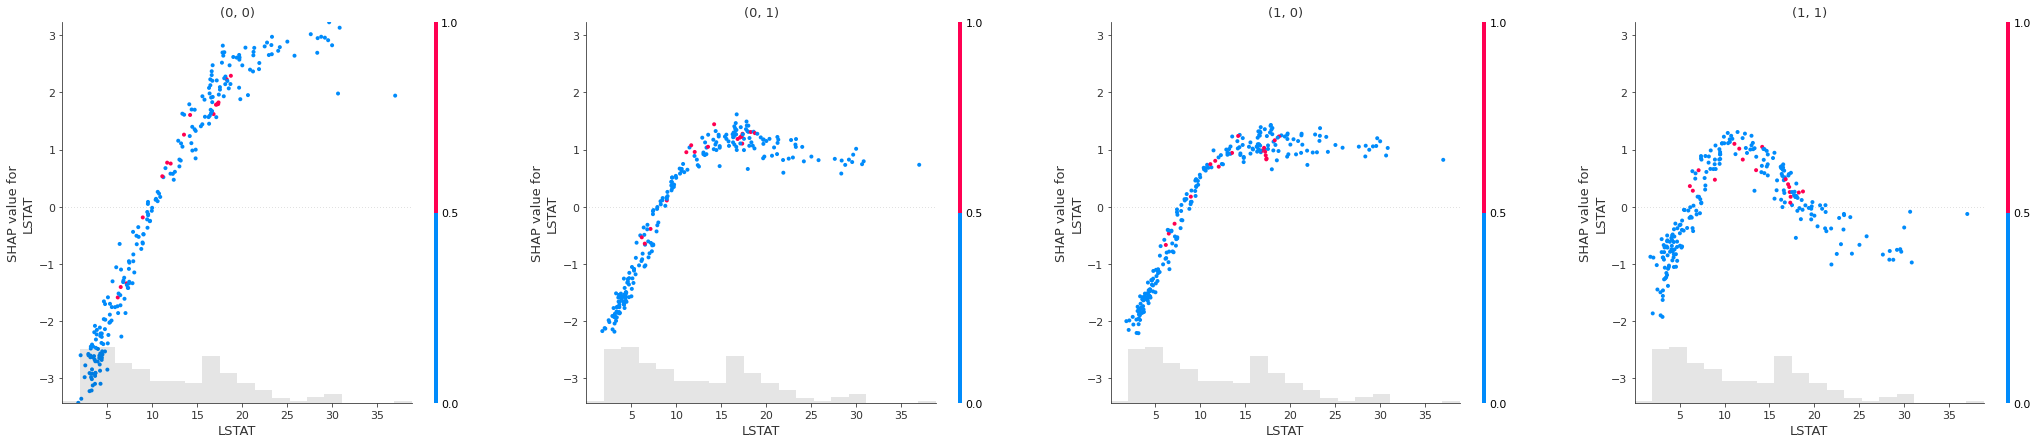

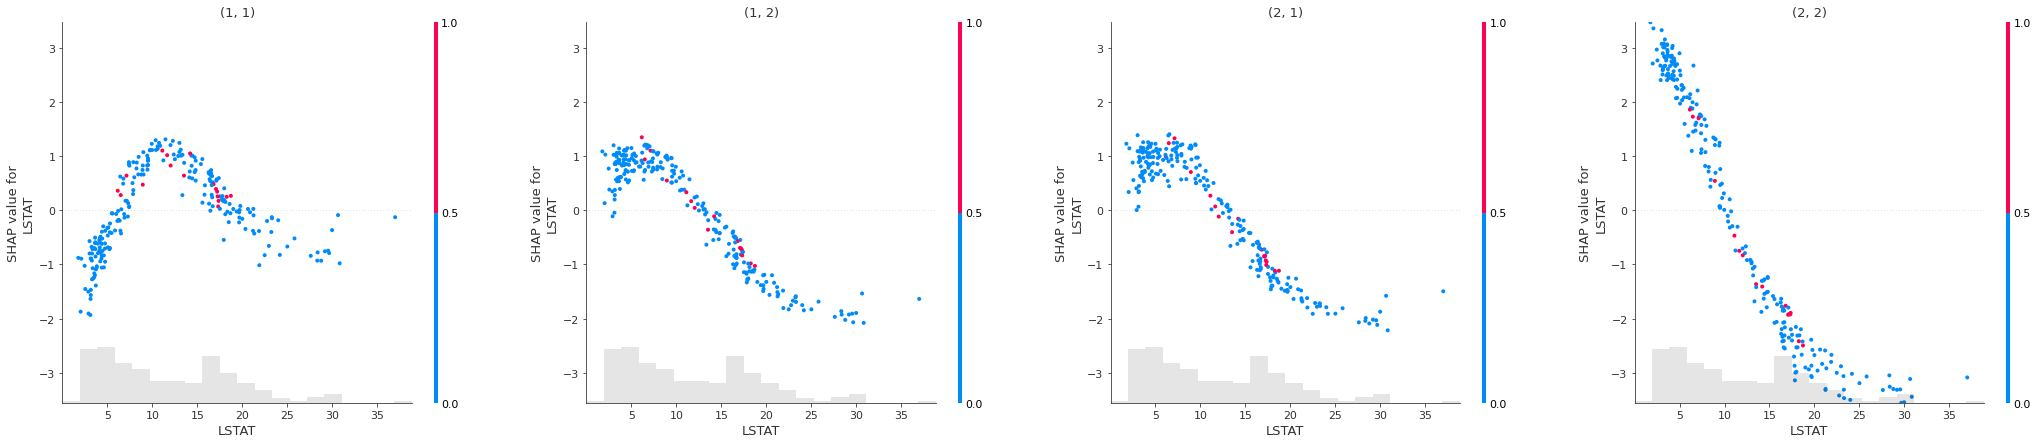

In [109]:
plot_next_feature()

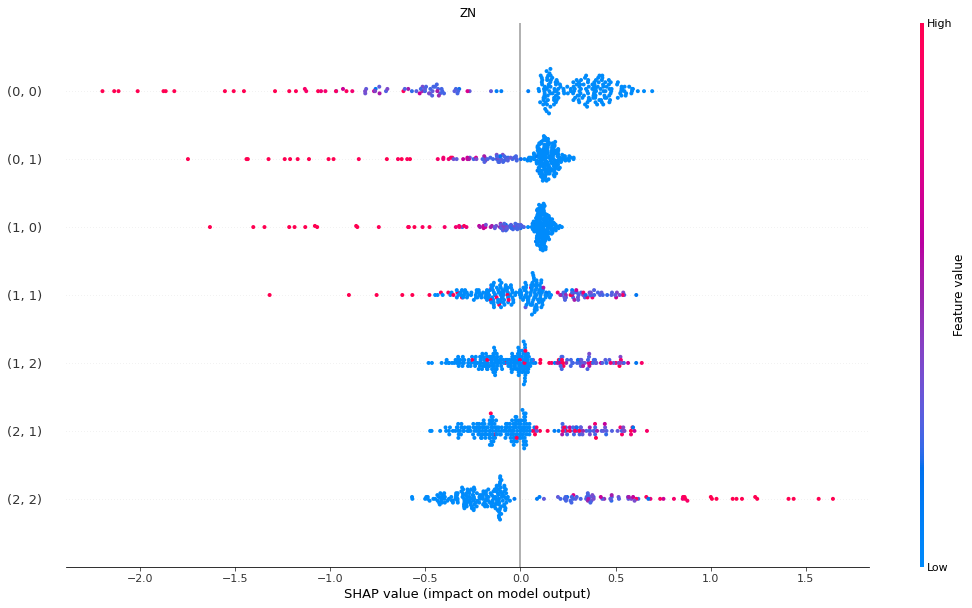

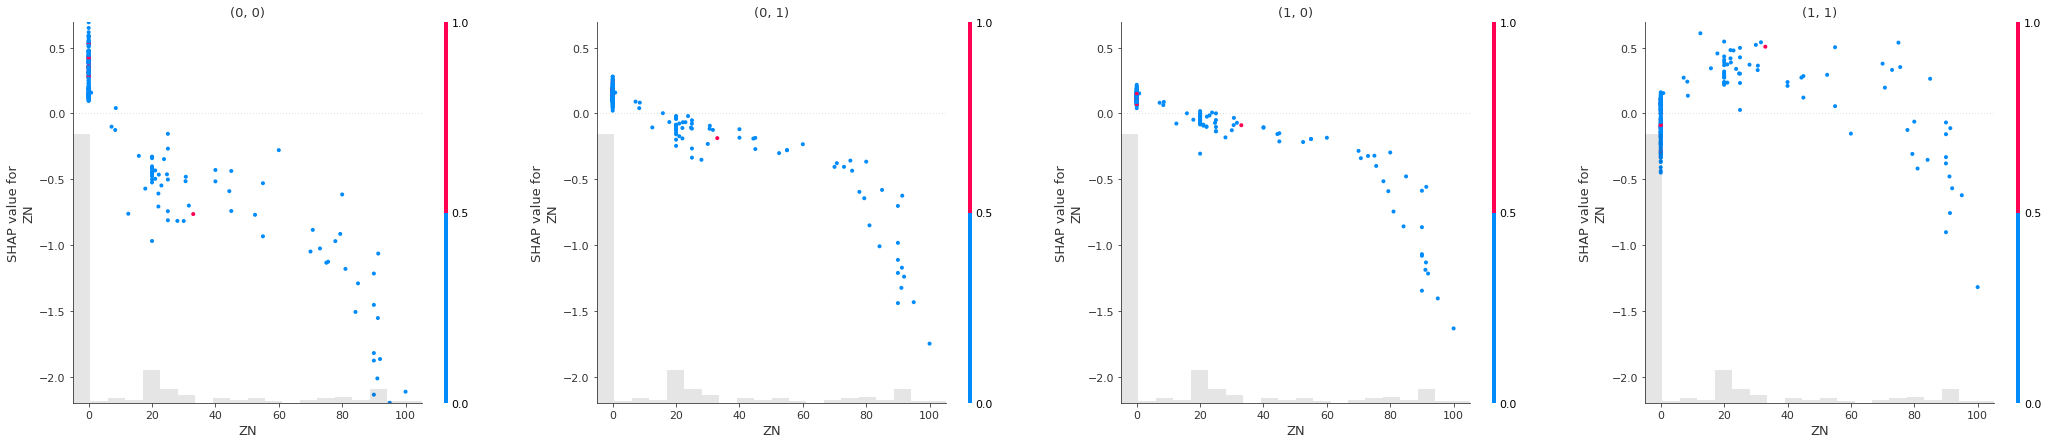

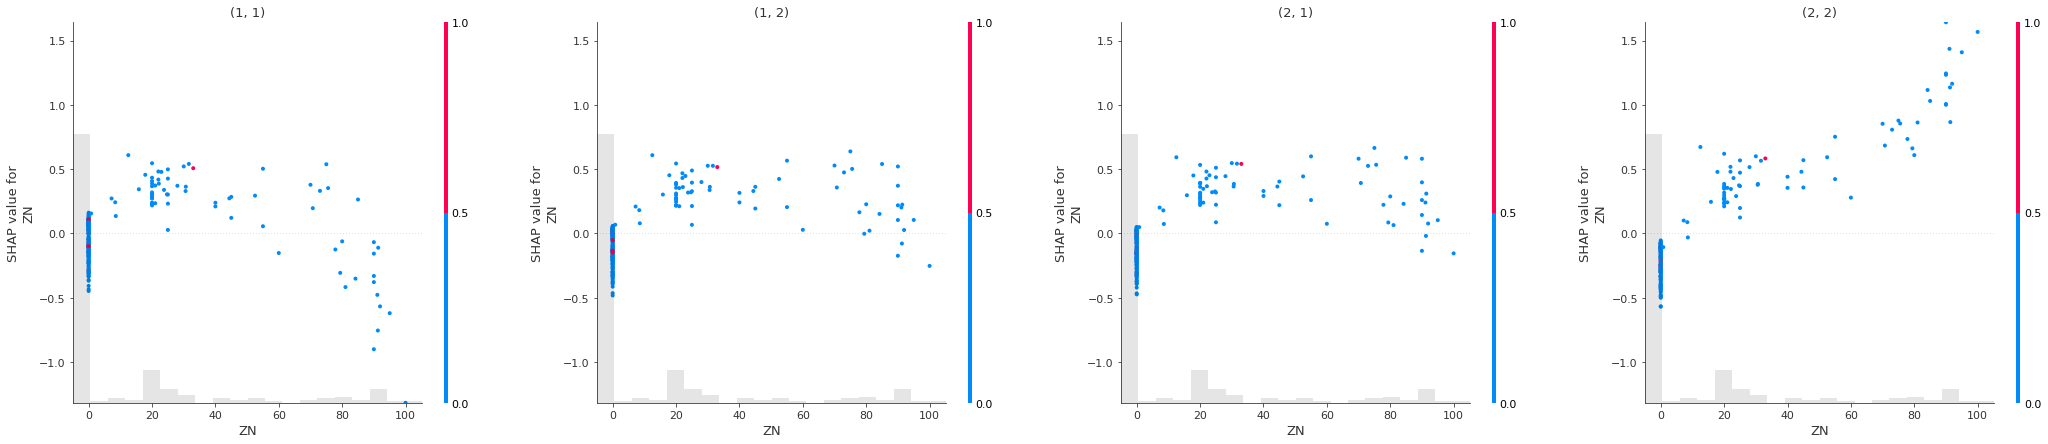

In [110]:
plot_next_feature()

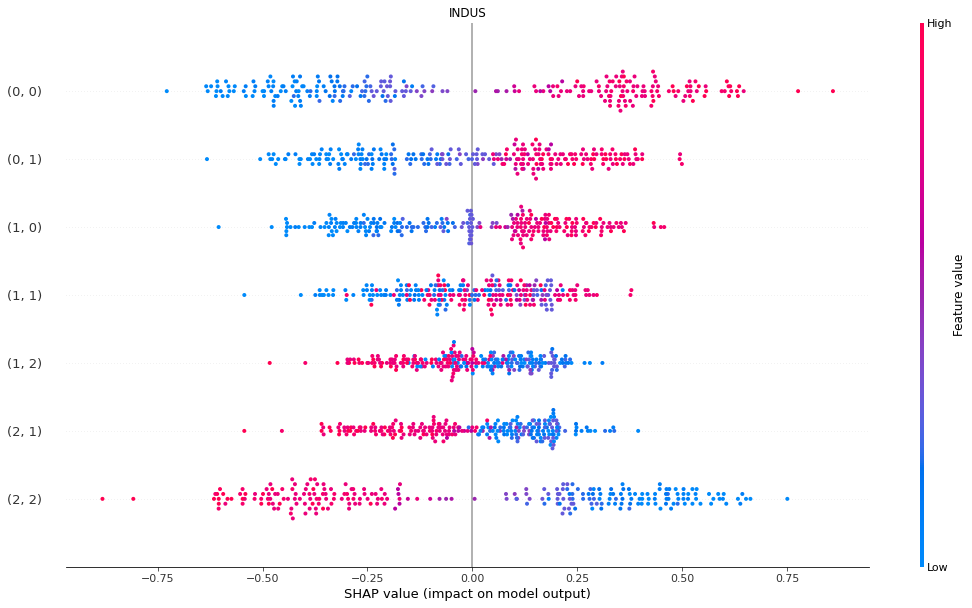

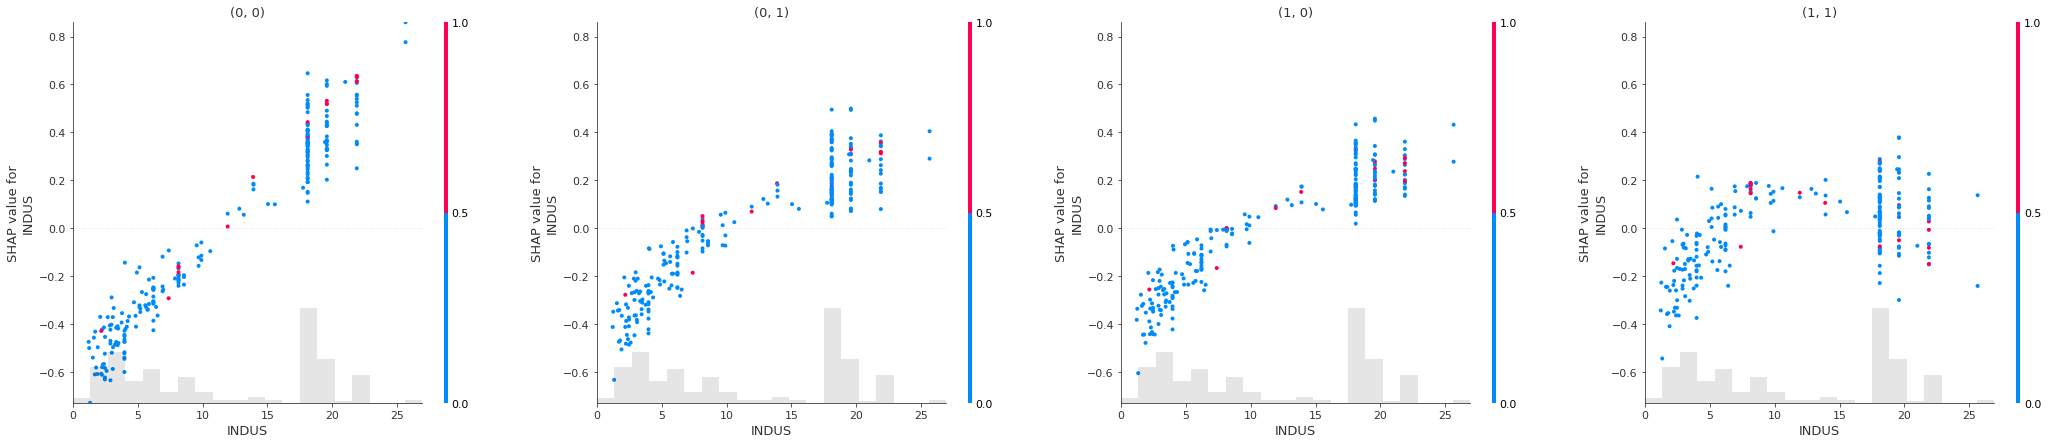

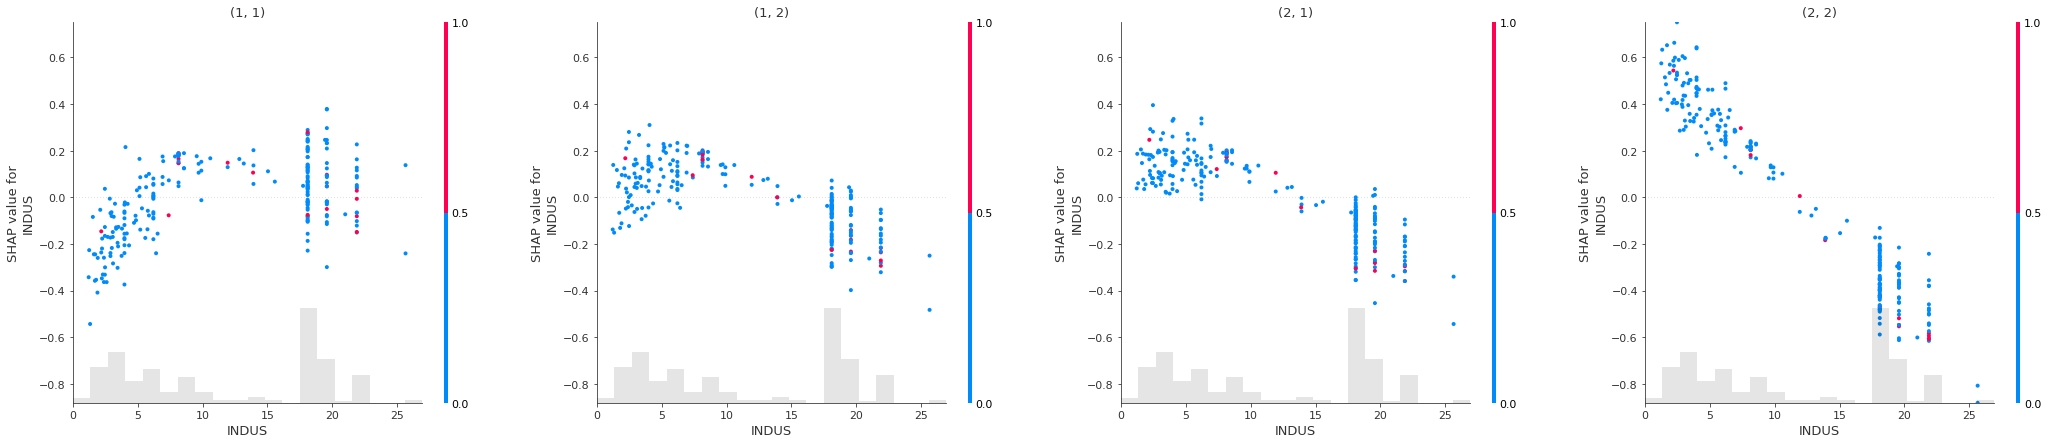

In [111]:
plot_next_feature()

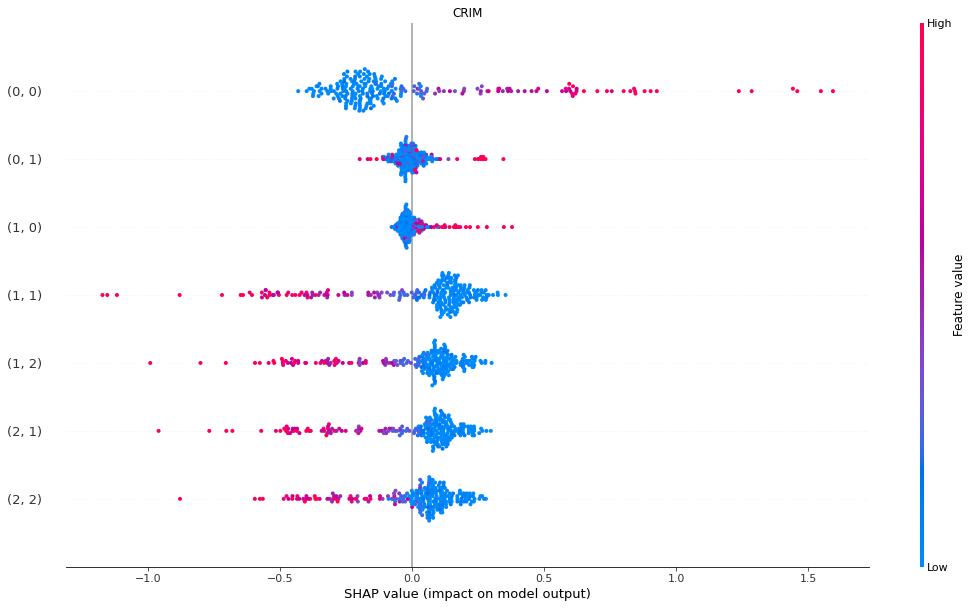

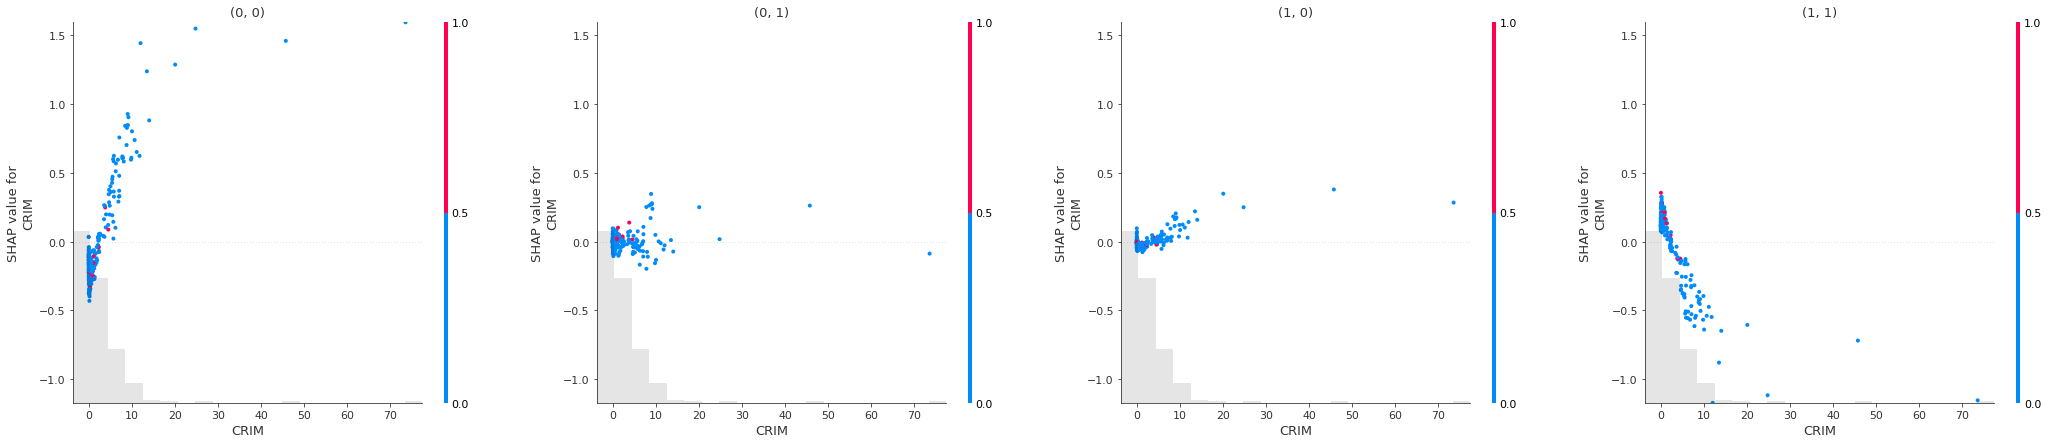

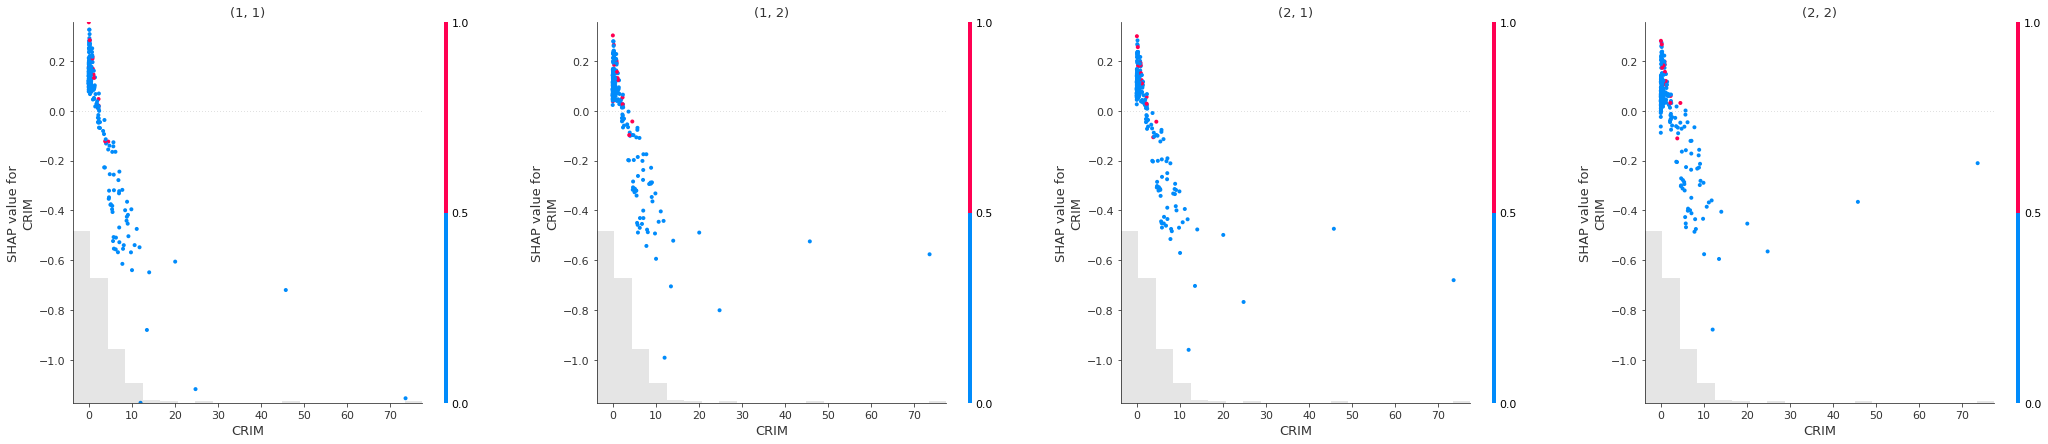

In [112]:
plot_next_feature()

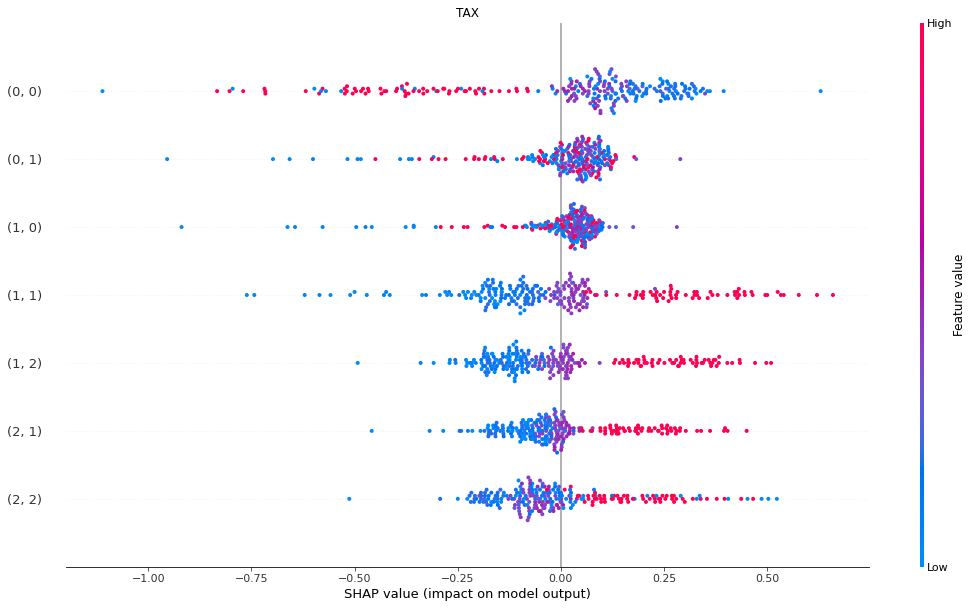

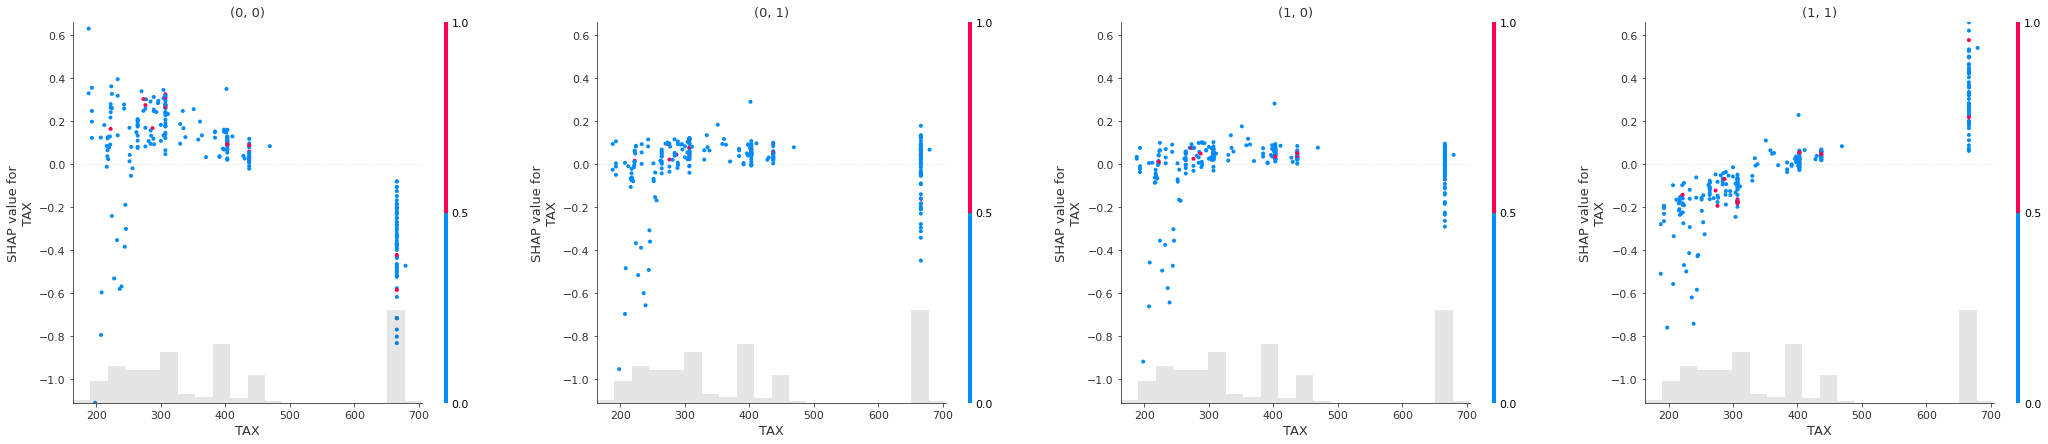

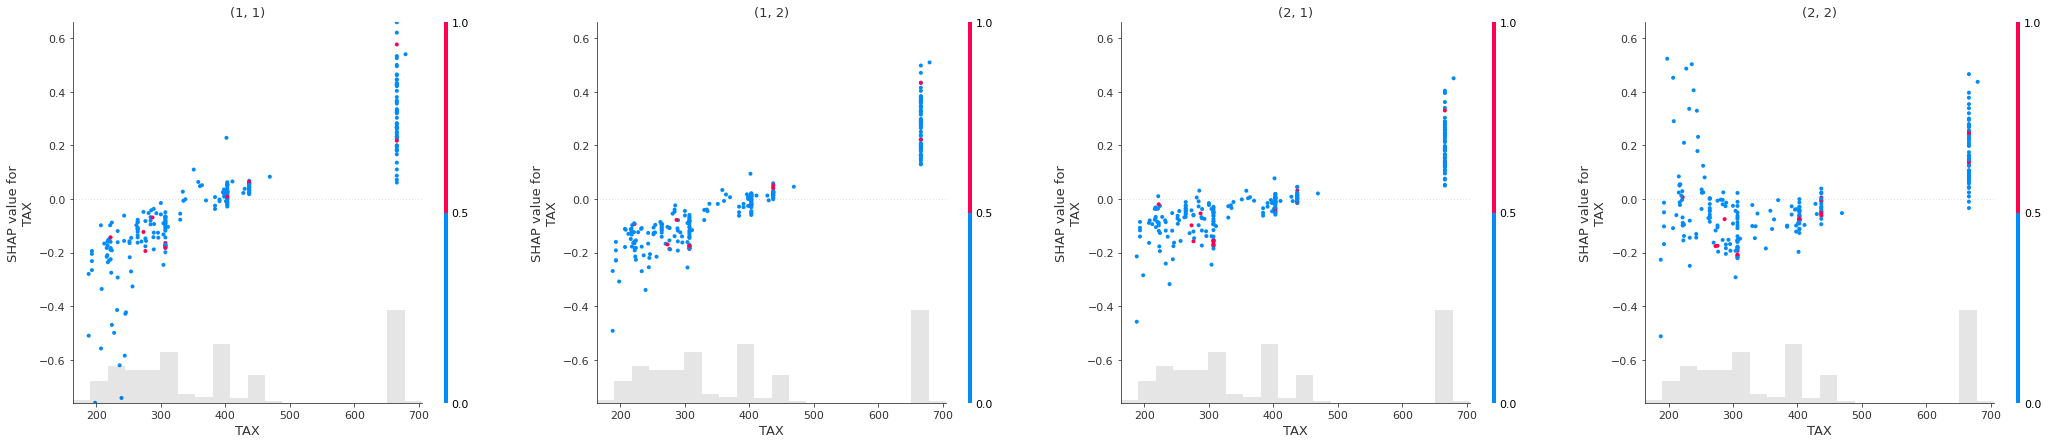

In [113]:
plot_next_feature()

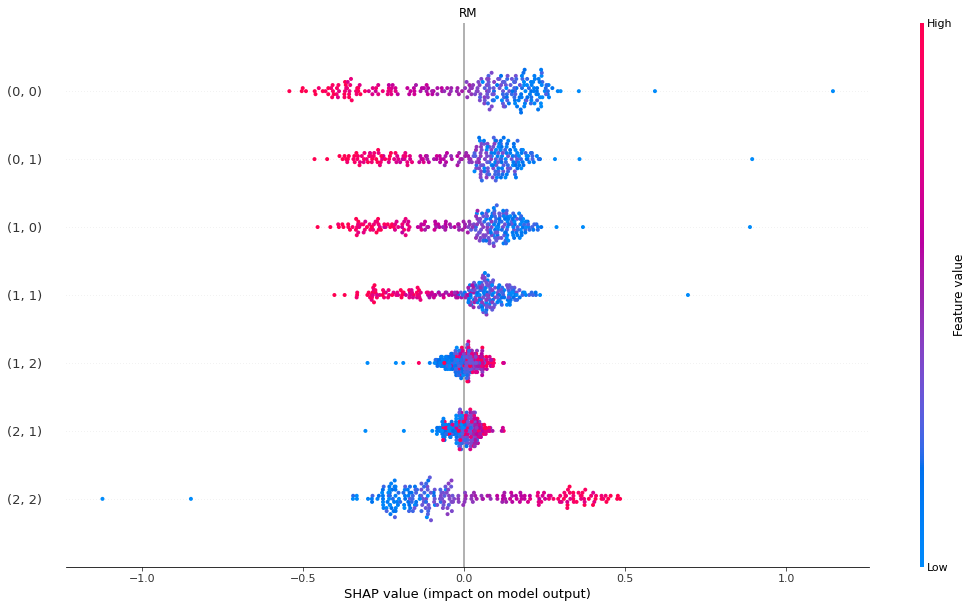

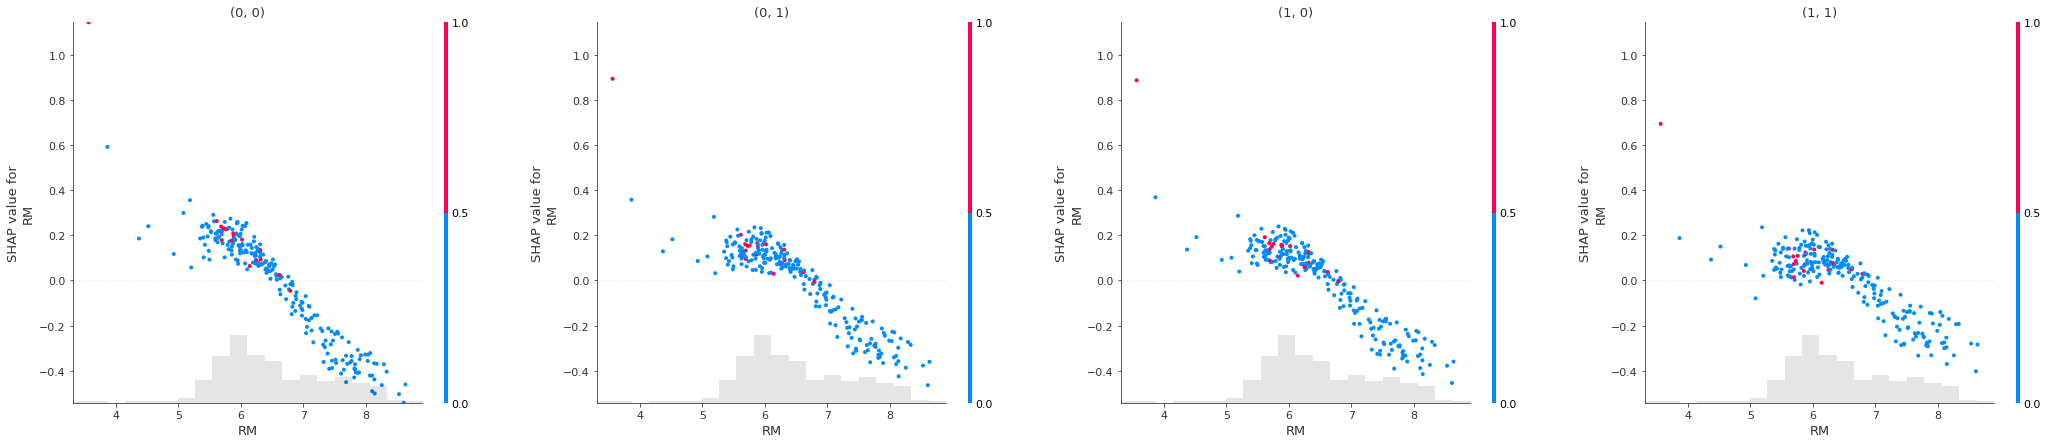

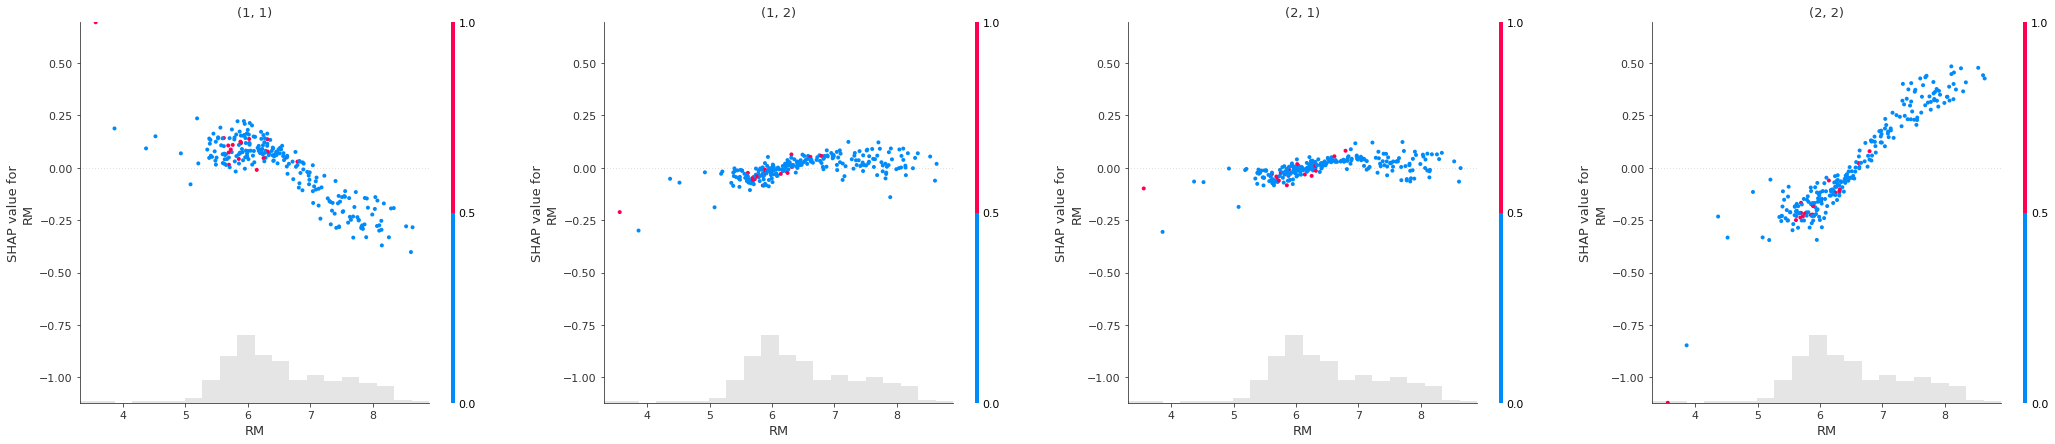

In [114]:
plot_next_feature()

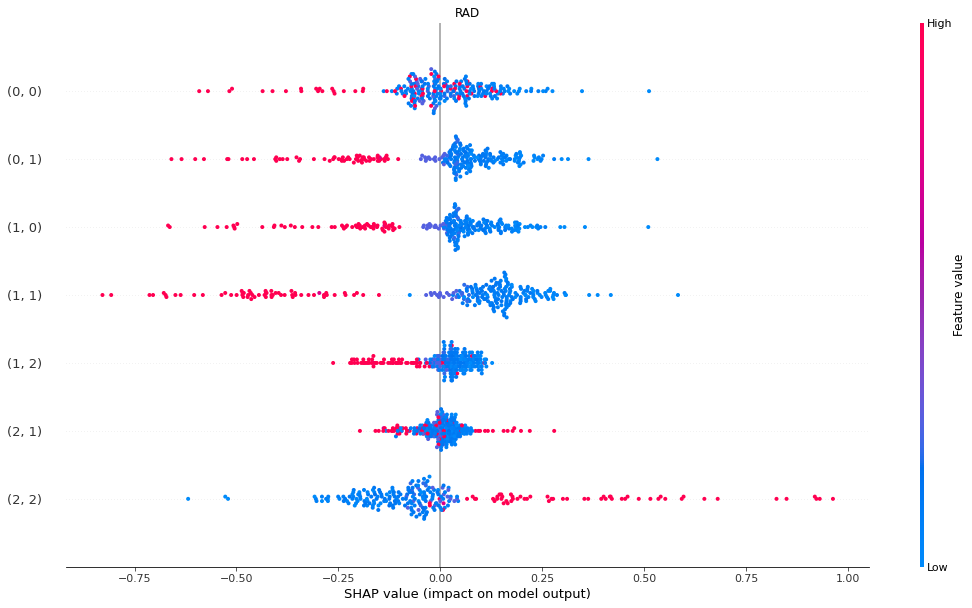

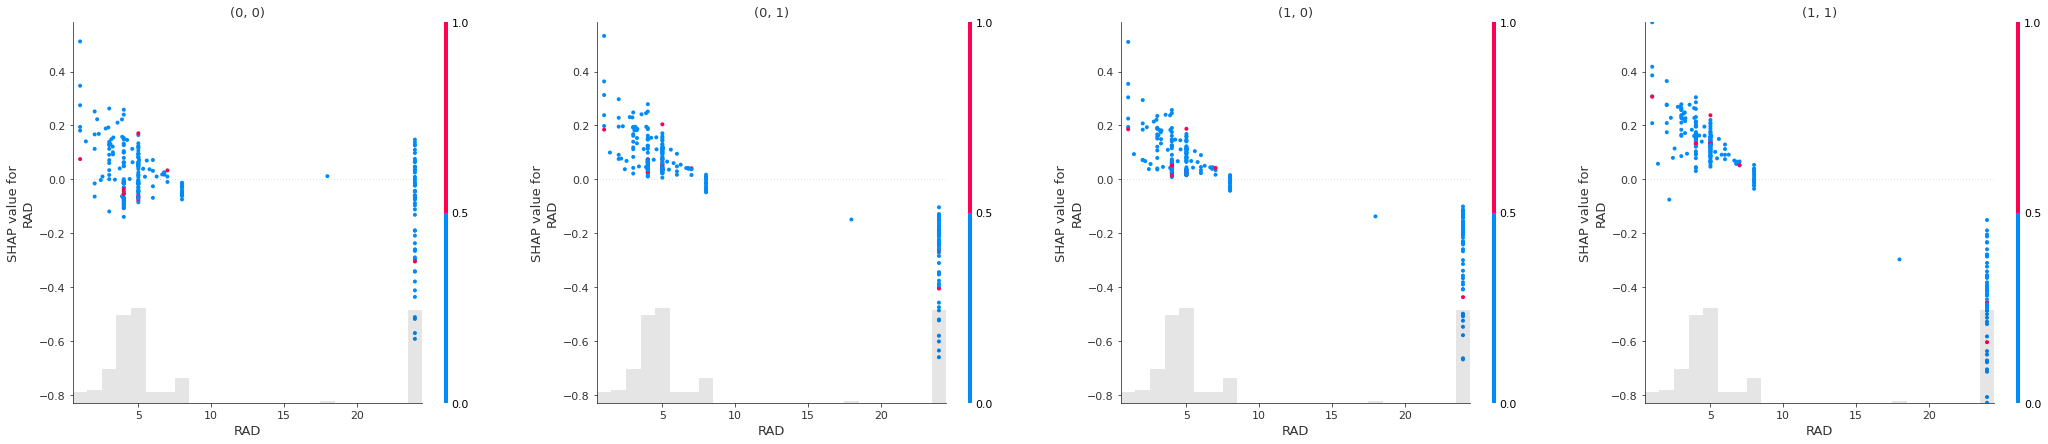

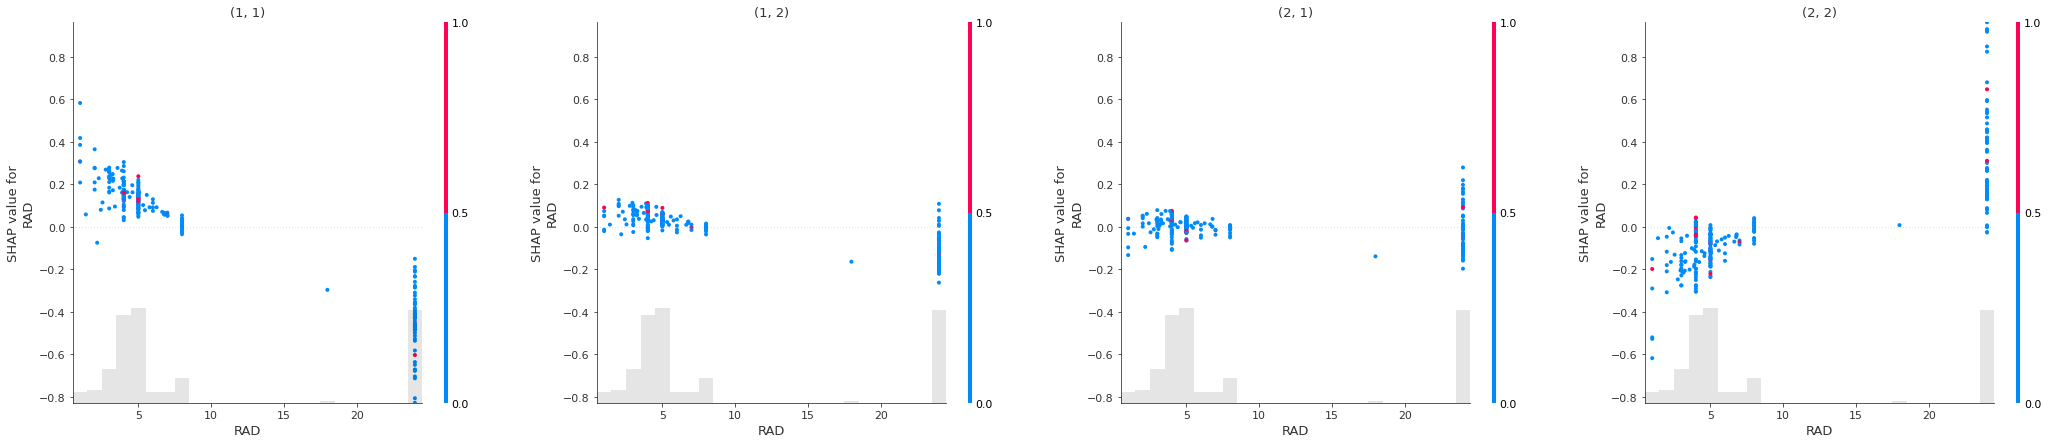

In [115]:
plot_next_feature()

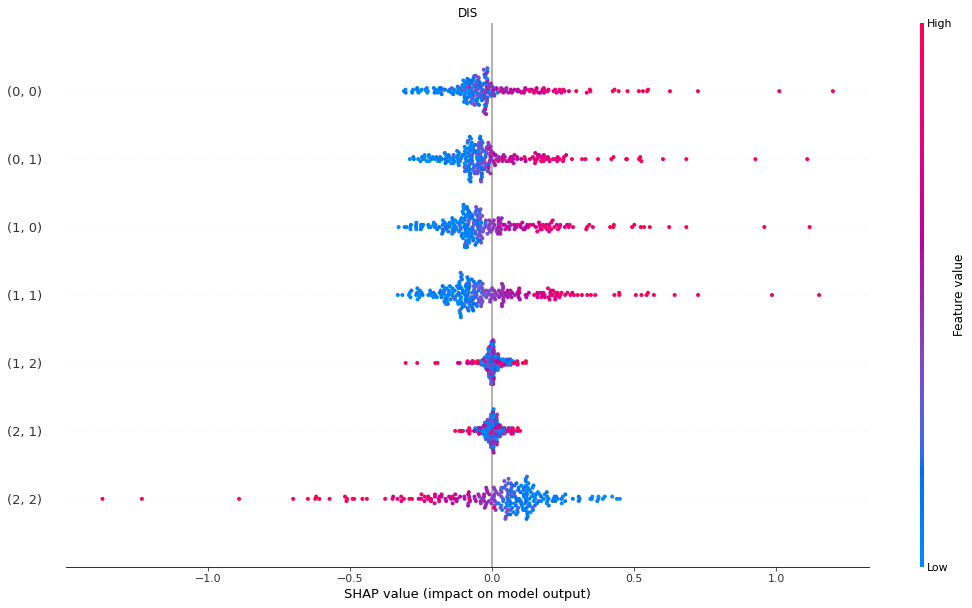

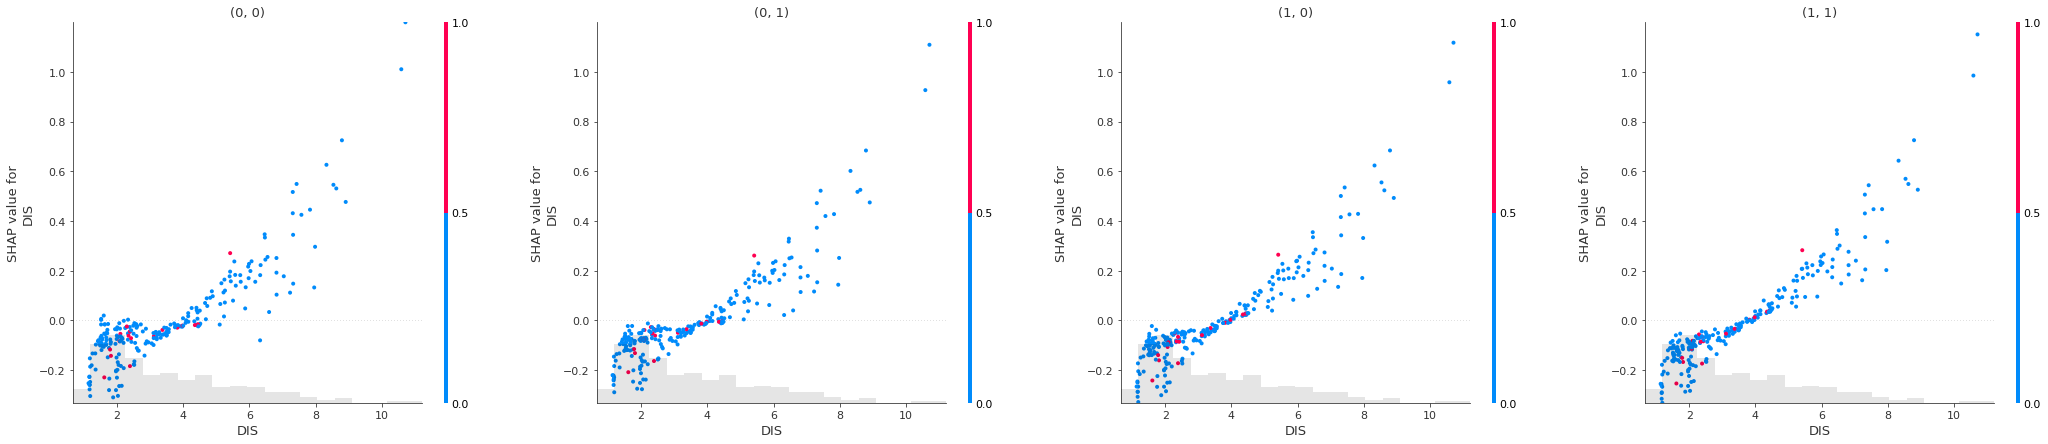

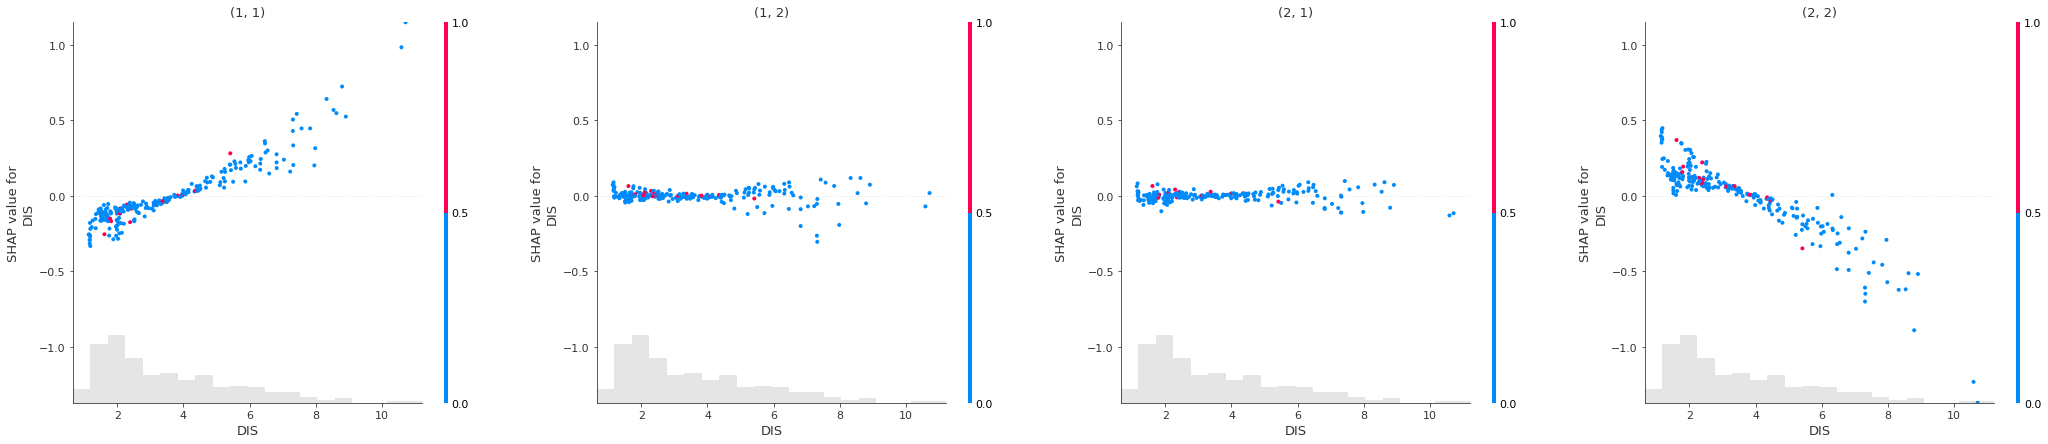

In [116]:
plot_next_feature()

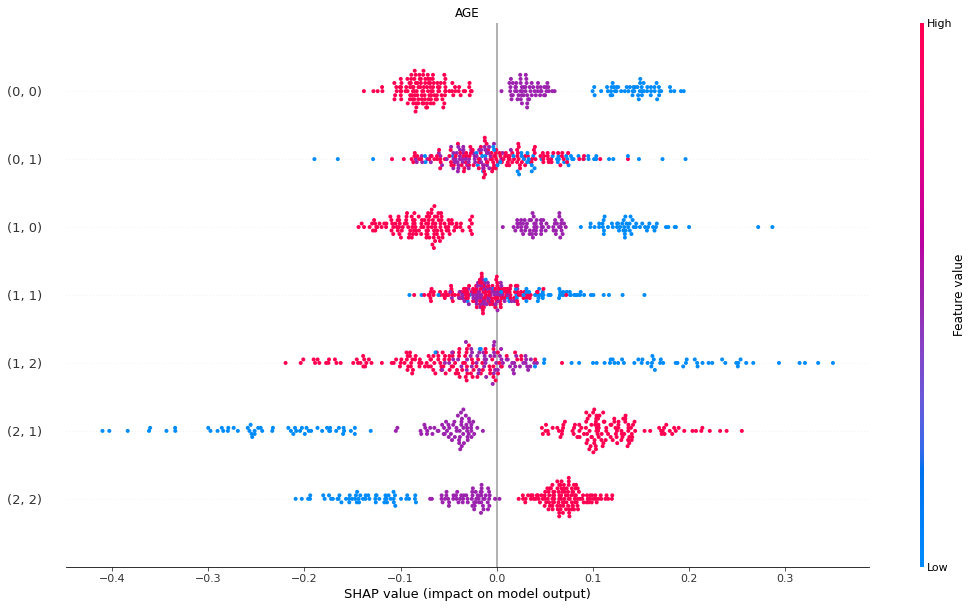

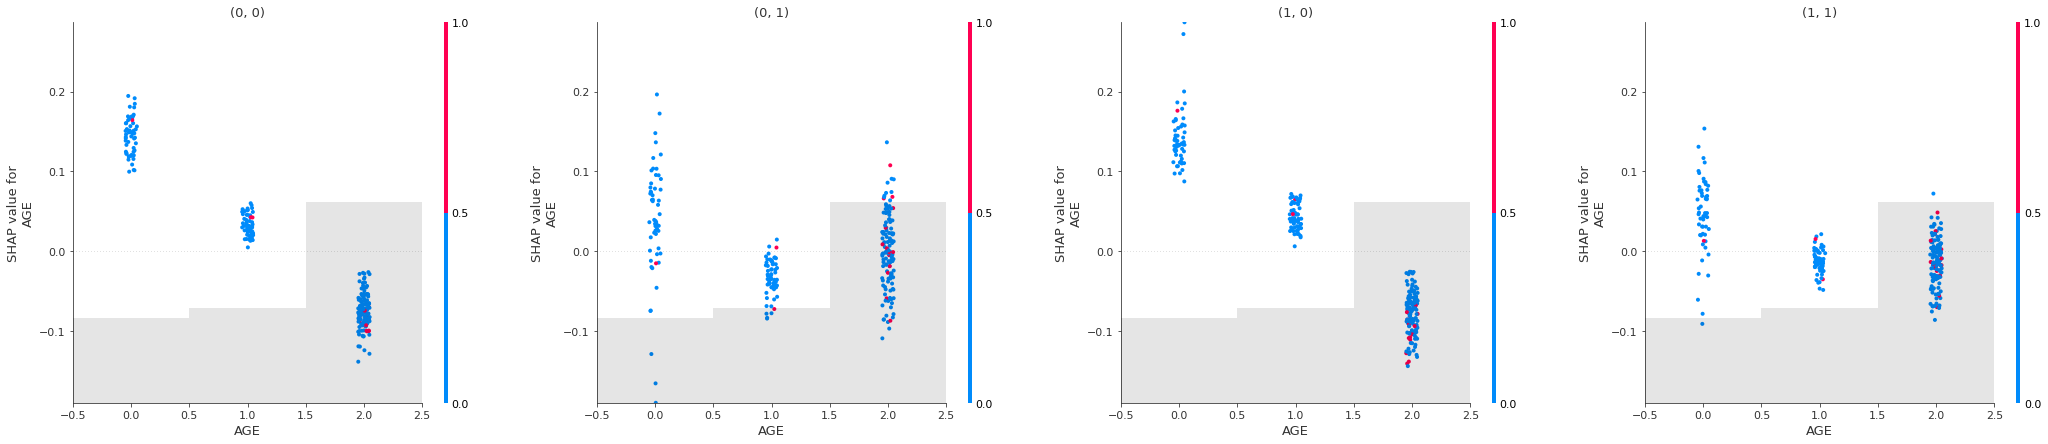

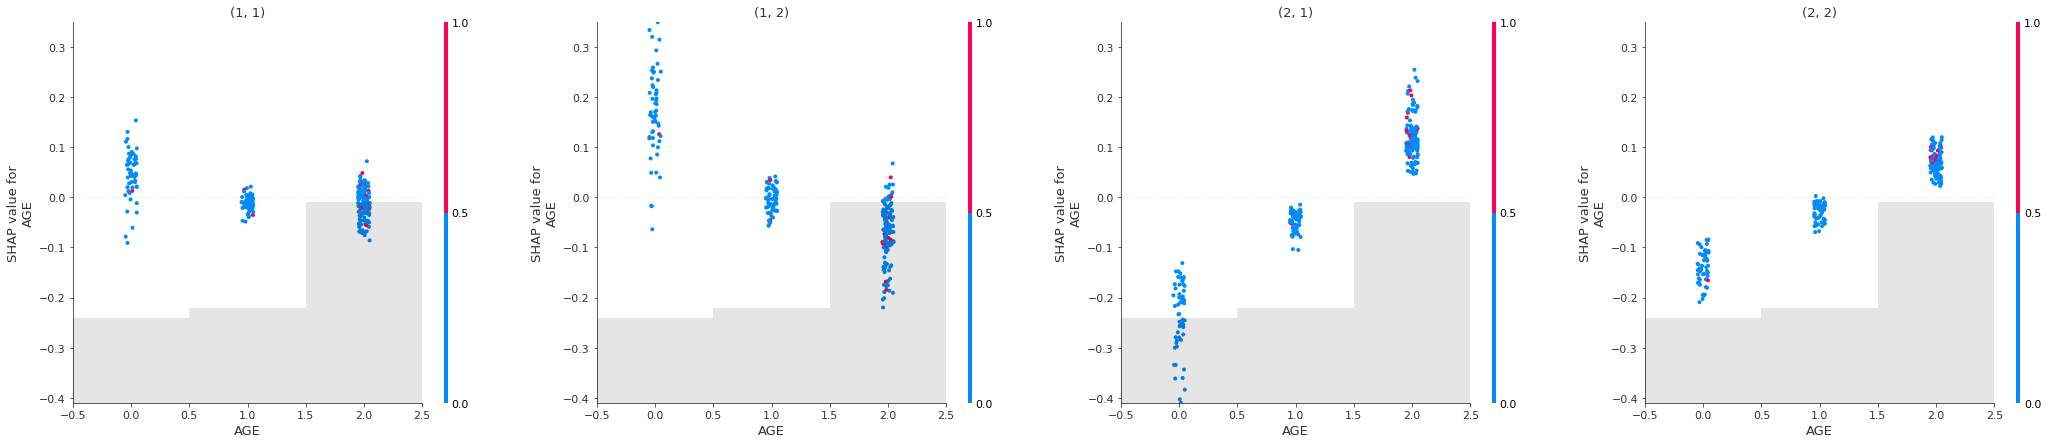

In [117]:
plot_next_feature()

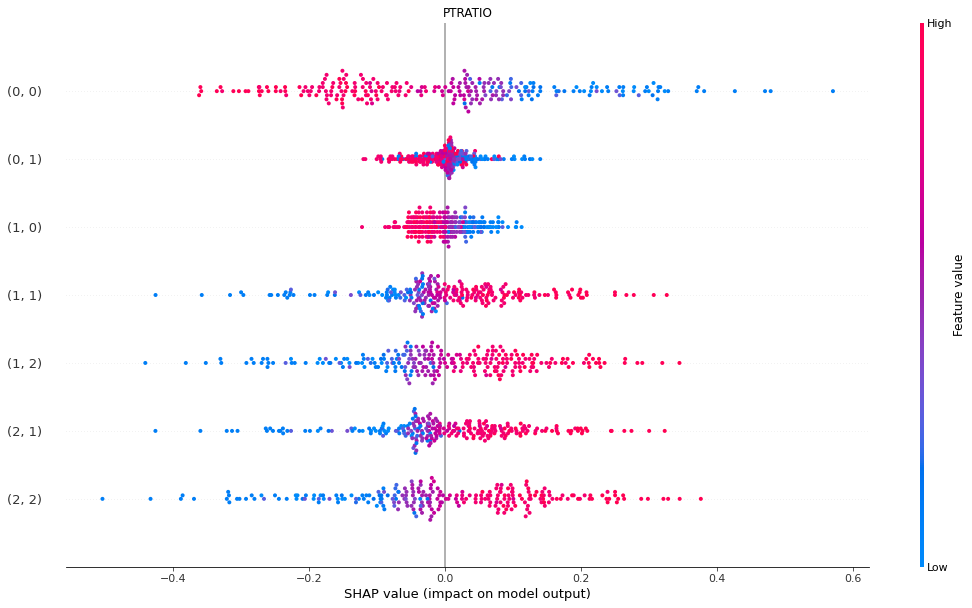

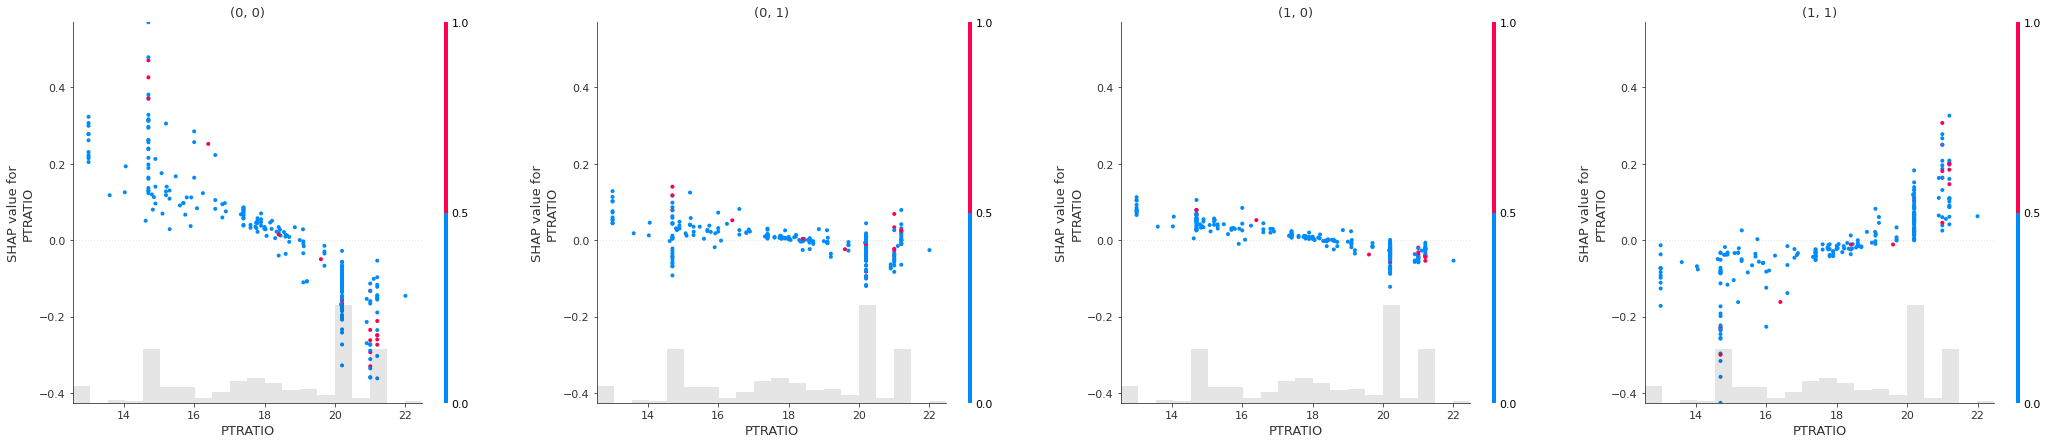

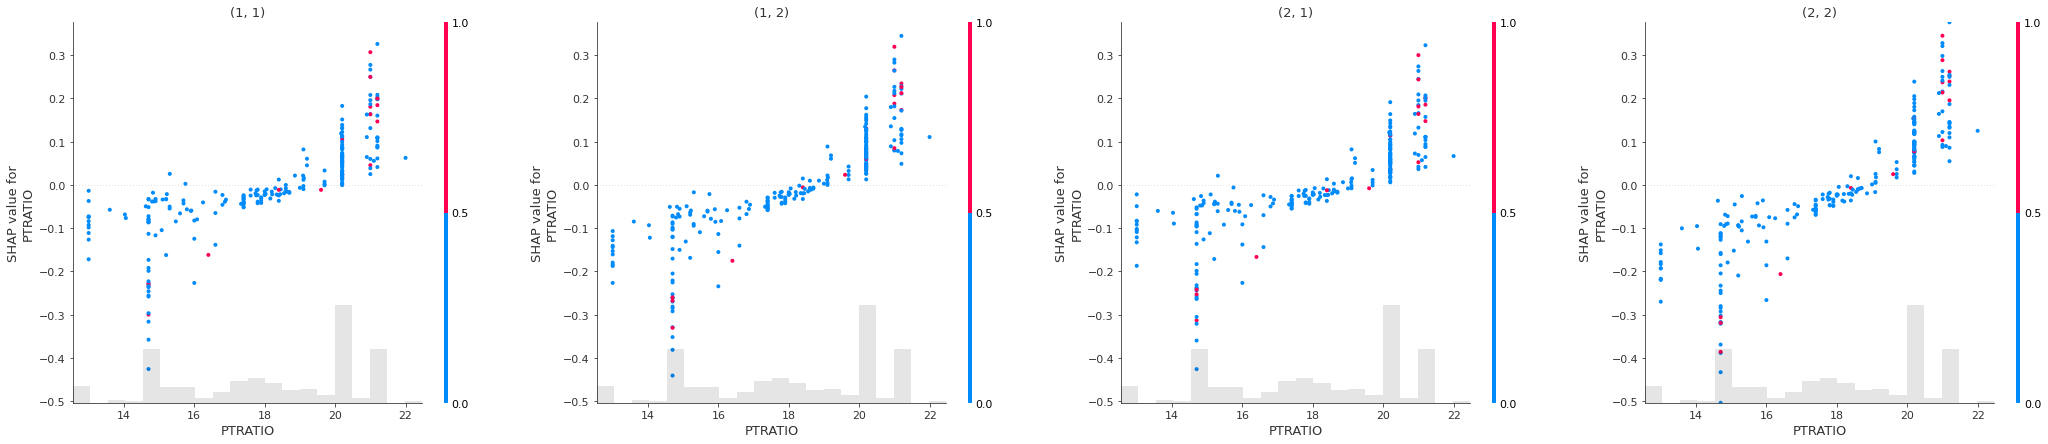

In [118]:
plot_next_feature()

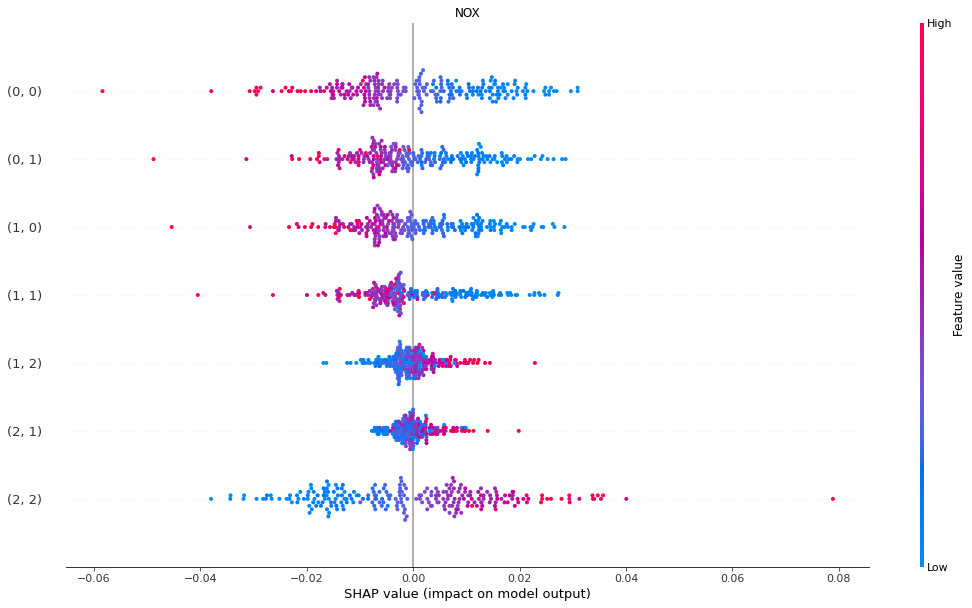

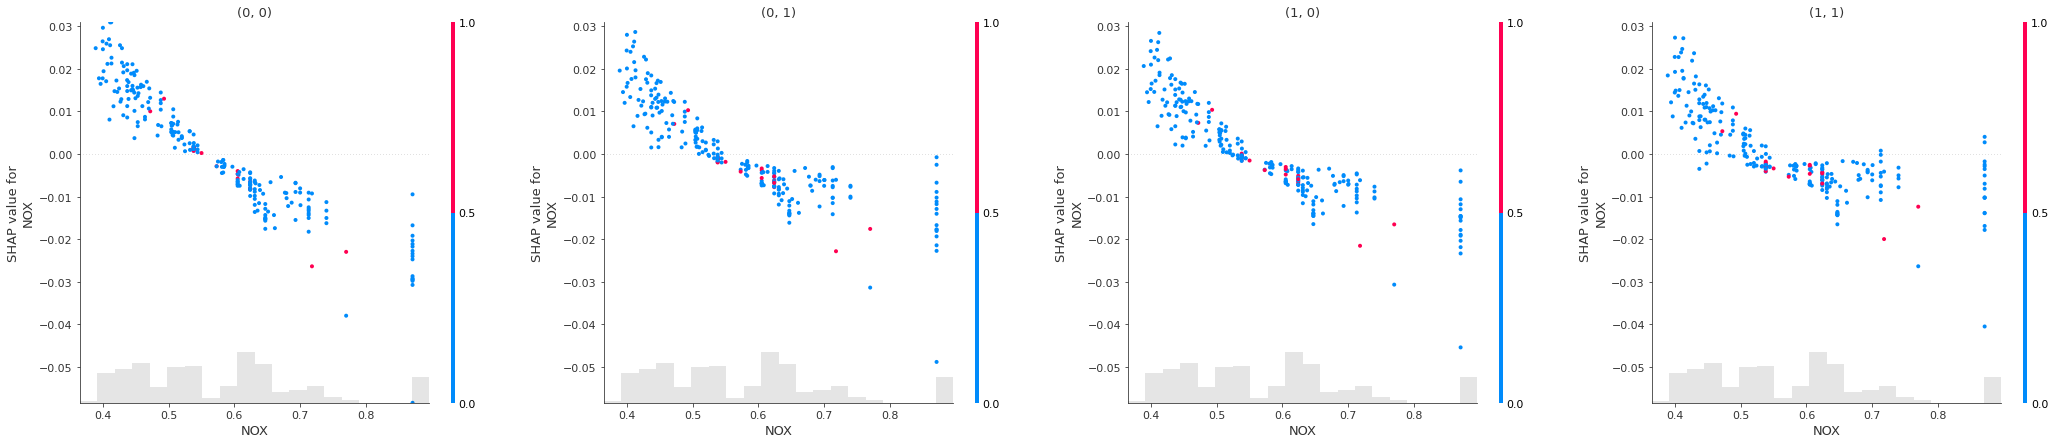

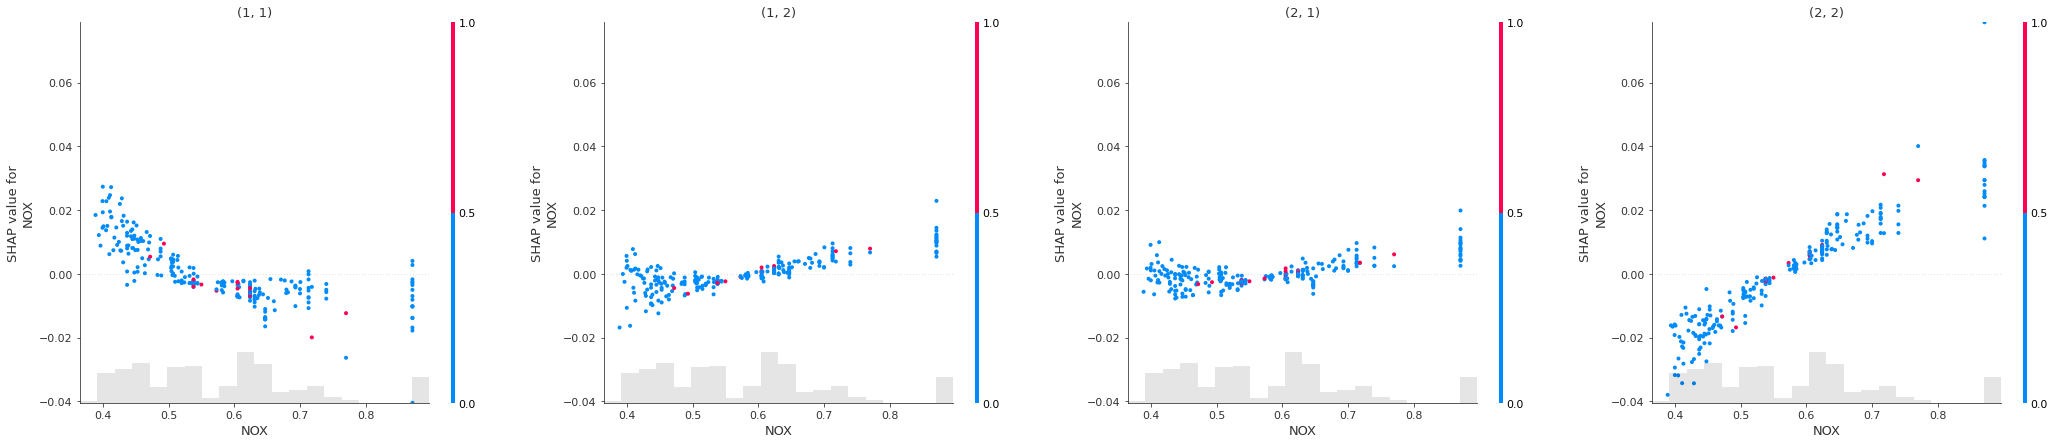

In [119]:
plot_next_feature()

# Local Explanations

In [3]:
scale_features = {'CRIM': 100, 'INDUS': 10, 'NOX': 100, 'RM': 10, 'DIS': 10, 'PTRATIO': 10, 'LSTAT': 10}

In [4]:
pred_classes = comparer.class_names[mclass_diff]

In [5]:
shap_values = explanations.mclass_diff.log_odds[:, :, :]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
        (shap_values.values.shape[0],
         shap_values.values.shape[1] * shap_values.values.shape[2]))
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

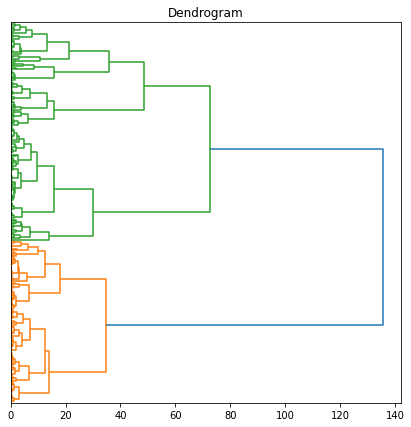

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

I start with a clustering with $n=3$, which yields 2 clusters that contain difference classes. When increasing to $n=4$, One instance of the $(2,1)$ group is separated, for $n=5$, a further one is separated. But one cluster with an instance $(1,2)$ and $(2,1)$ persists. At $n=6$, the $(0,1)$ cluster splits, and at $n=18$, it splits again. At $n=23$, the cluster containing one $(1,2)$ and one $(2,1)$ instance is finally split, but the at this point there is only a small number of instances in each cluster.
I choose $n=6$, because it is the earliest point where the bigger cluster of $(0,1)$ instances is split which enables me to create more detailled explanations while at the same time keeping the instance number per cluster high.

In [173]:
n_clusters = 6
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
clustering -= 1

In [174]:
explanations_clustered = explanations.cohorts(cluster_names[clustering])

In [175]:
occurences = pd.DataFrame(np.zeros((n_clusters, comparer.classes.shape[0]), dtype=int),
                          index=cluster_names, columns=comparer.class_names)
mclass_diff = comparer.predict_mclass_diff(explanations.data)
for cluster, data in explanations_clustered.mclass_diff.log_odds.data.cohorts.items():
    mclass_diff_ = comparer.predict_mclass_diff(data)
    indices, counts = np.unique(mclass_diff_, return_counts=True)
    occurences.loc[cluster, :].iloc[indices] = counts
has_diff_classes = occurences.loc[:, comparer.difference_class_names].sum(1) > 0
clusters_of_interest = occurences.index[has_diff_classes].to_numpy()
occurences.loc[clusters_of_interest, :]

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c1      55       6       0       0       0       0       0       0       0
c2      21       7       0       0      16       0       0       0       0
c4       0       0       0       0      28       0       0       1       0
c5       0       0       0       0       0       0       0       1      11
c6       0       0       0       0      14       1       0       1      10

In [448]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

### 1. Cluster

The following feature value distributions are different locally and globally:
- LSTAT ranges from 15.5 to 37, which is on the higher end
- ZN is 0
- INDUS ranges from 6.9 to 25.7, which is on the higher end
- RM ranges from 4.3 to 6.8, which is on the lower end
- DIS ranges from 1.3 to 5.9, which is on the lower end
- AGE ranges from 1 to 2, which is on the higher end

Comparing that to the global level, we can reason for instances in this cluster that:
- if LSTAT was decreased to ~12, the effect towards $(1,1)$ would be maximized
    - all instances originally classified $(0,1)$ flip to this prediction
- if ZN was increased, the effect would shift towards $(1,1)$
    - $ZN=6$ is the lowest value where all instances originally classified $(0,1)$ flip to this prediction
- if INDUS was decreased, its effect would shift towards $(1,1)$
    - at $INDUS=6$ 4/6 instances originally classified $(0,1)$ flip to this prediction
- if AGE was decreased to 0, the effect towards $(0,0)$ would be maximized
    - all instances originally classified $(0,1)$ flip to this prediction
    
Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if LSTAT was higher, its effect would shift towards $(0,0)$
  from $LSTAT=19$ all instances originally classified $(0,1)$ flip to this prediction
- if INDUS was higher, its effect would shift towards $(0,0)$
  $INDUS=25.65$ (the maximum value present in this cluster) changes 4/5 predictions of instances originally classified differently to this class. 
- if CRIM was higher, its effect would shift towards $(0,0)$
  $CRIM=2$ is enough to change all instances originally classified $(0,1)$ to this prediction

In [211]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c1      55       6       0       0       0       0       0       0       0

In [212]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

CRIM    ZN      INDUS        NOX         RM        AGE        DIS  \
count  61.000000  61.0  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    5.839402   0.0  18.613370   0.686869   5.784357   1.934426   2.093234   
std    11.433069   0.0   3.935412   0.120897   0.497087   0.249590   0.932763   
min     0.092990   0.0   6.910000   0.448000   4.368000   1.000000   1.358000   
25%     0.626837   0.0  18.100000   0.624000   5.485947   2.000000   1.545974   
50%     2.257990   0.0  19.580000   0.632222   5.695859   2.000000   1.718286   
75%     7.050420   0.0  21.890000   0.740000   6.069252   2.000000   2.088200   
max    73.534100   0.0  25.650000   0.871000   6.833000   2.000000   5.870000   

             RAD         TAX    PTRATIO      LSTAT  
count  61.000000   61.000000  61.000000  61.000000  
mean   10.694275  477.395486  19.007550  21.574328  
std     9.390941  145.643075   2.589986   4.713614  
min     2.000000  188.000000  14.700000  15.558027  
25%     4.000000  403.000000  17.900000  17.992613  
50%     5.000000  437.000000  20.200000  19.991915  
75%    24.000000  666.000000  21.200000  23.290000  
max    24.000000  666.000000  21.200000  36.980000

In [189]:
df[pred_classes == '(0, 1)']

CRIM   ZN  INDUS    NOX        RM  AGE       DIS  RAD    TAX  PTRATIO  \
9   1.136037  0.0   8.14  0.538  5.695859  2.0  3.820836  4.0  307.0     21.0   
18  0.626837  0.0  21.89  0.624  5.725819  2.0  2.074288  4.0  437.0     21.2   
40  0.976170  0.0  21.89  0.624  5.757000  2.0  2.346000  4.0  437.0     21.2   
43  0.259150  0.0  21.89  0.624  5.693000  2.0  1.788300  4.0  437.0     21.2   
59  0.344745  0.0  21.89  0.624  5.685295  2.0  1.814662  4.0  437.0     21.2   
60  1.232470  0.0   8.14  0.538  6.142000  2.0  3.976900  4.0  307.0     21.0   

        LSTAT  
9   18.257266  
18  17.251536  
40  17.310000  
43  17.190000  
59  17.348228  
60  18.720000

In [194]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 12
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    55.0     14
(0, 1)     NaN     18
(1, 1)     NaN     23

before  after
(0, 1)     6.0    NaN
(1, 1)     NaN    6.0

In [198]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['ZN'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    55.0     49
(0, 1)     NaN      6

before  after
(0, 1)     6.0    NaN
(1, 1)     NaN    6.0

In [208]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)    55.0     47
(0, 1)     NaN      6
(1, 1)     NaN      2

before  after
(0, 1)     6.0      2
(1, 1)     NaN      4

In [200]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      55     55

before  after
(0, 0)     NaN    6.0
(0, 1)     6.0    NaN

#### SHAP-based Difference Classifier Explanations

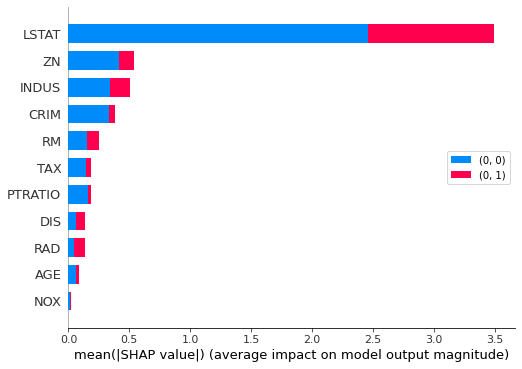

In [190]:
classes = np.unique(pred_classes)
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

4

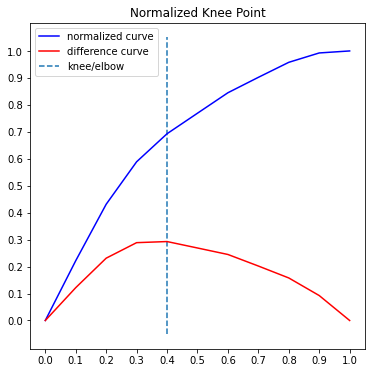

In [191]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

In [192]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

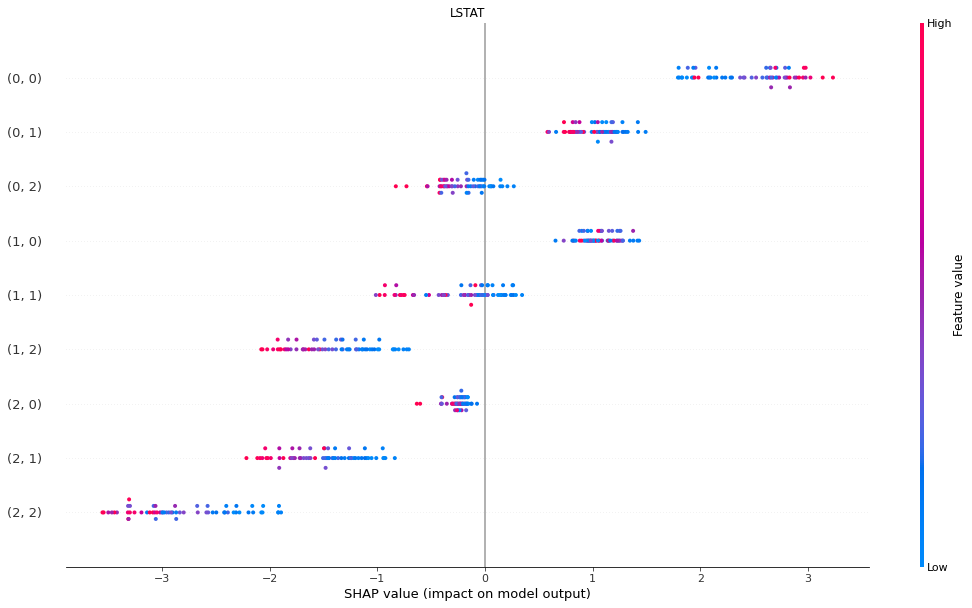

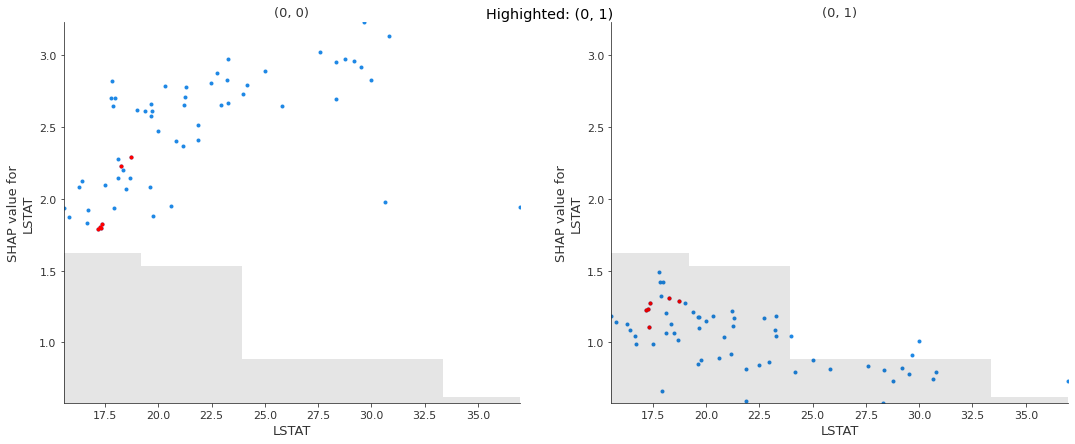

In [193]:
plot_next_feature()

In [219]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 19
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      55     55

before  after
(0, 0)     NaN    6.0
(0, 1)     6.0    NaN

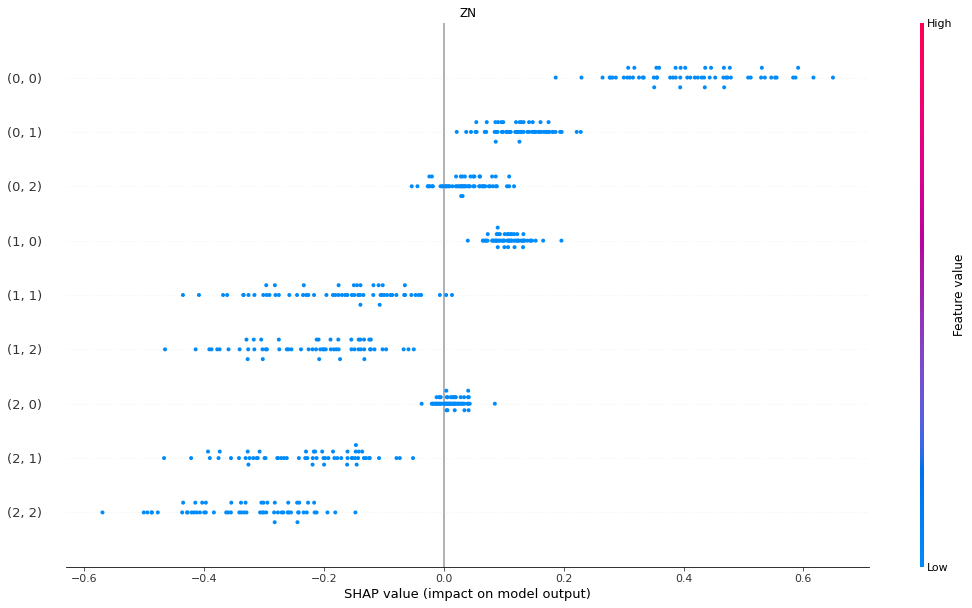

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


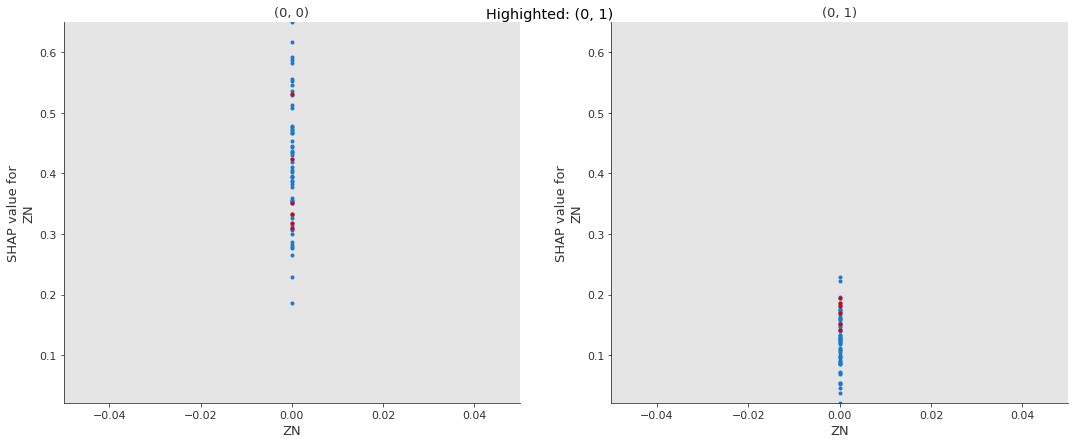

In [133]:
plot_next_feature()

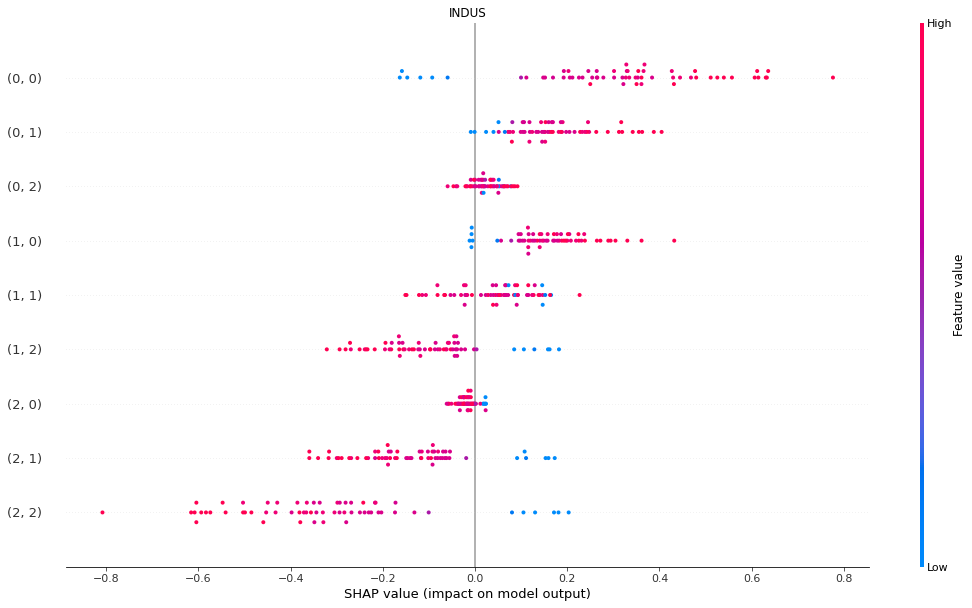

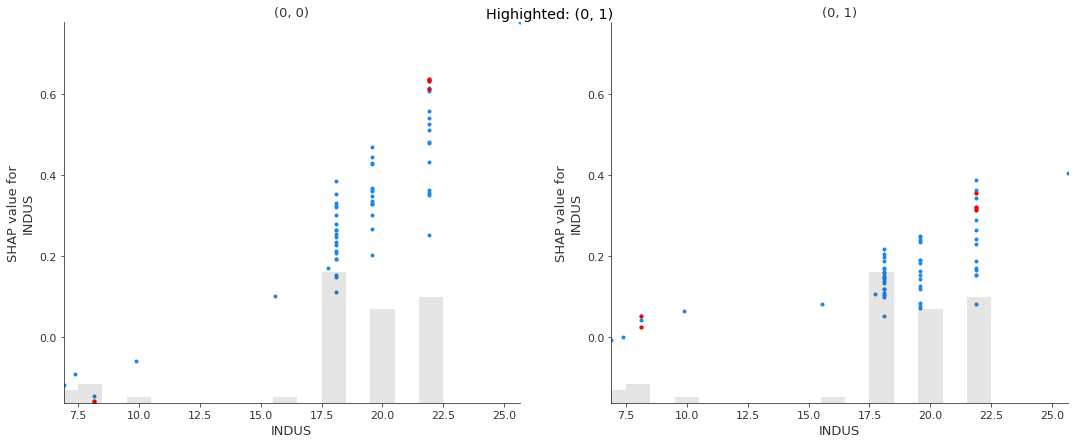

In [134]:
plot_next_feature()

In [229]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 25.65
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      55     55

before  after
(0, 0)     NaN      5
(0, 1)     6.0      1

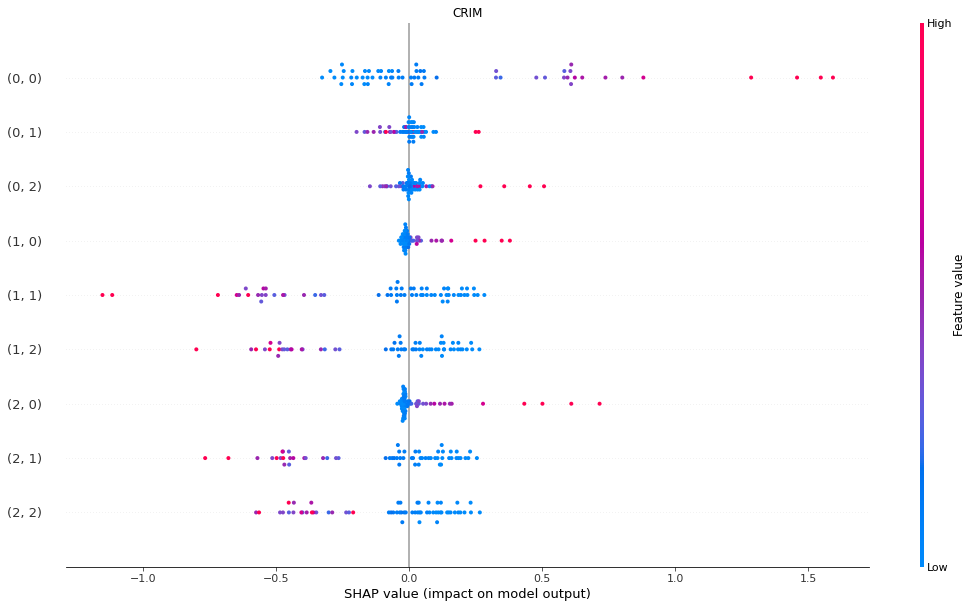

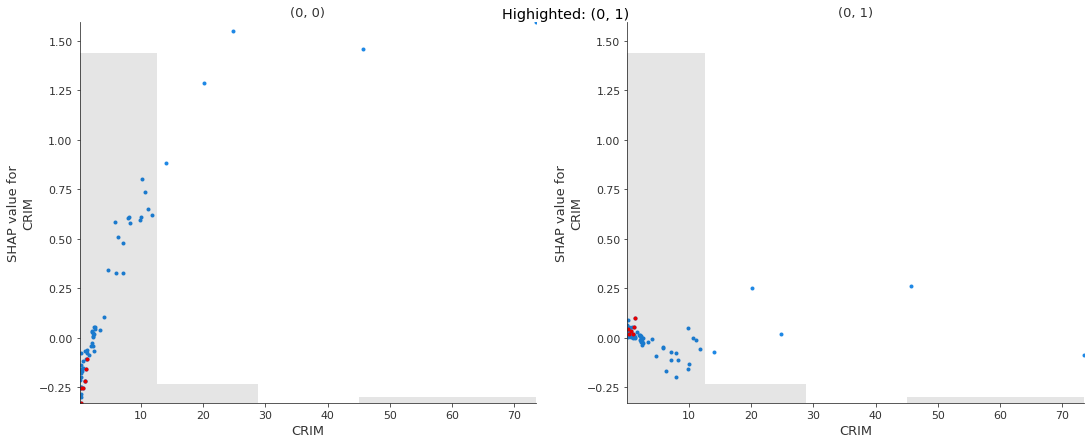

In [135]:
plot_next_feature()

In [226]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['CRIM'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      55     55

before  after
(0, 0)     NaN    6.0
(0, 1)     6.0    NaN

#### diro2c

In [230]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [187]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 24.5 s, sys: 507 ms, total: 25 s
Wall time: 26.9 s


In [231]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

- additionally, it found out:
    - if RAD was $>7.5$, its effect shifts away from this difference class: $RAD=8$ changes 2/6 predictions of instances originally classified differently to $(0,0)$

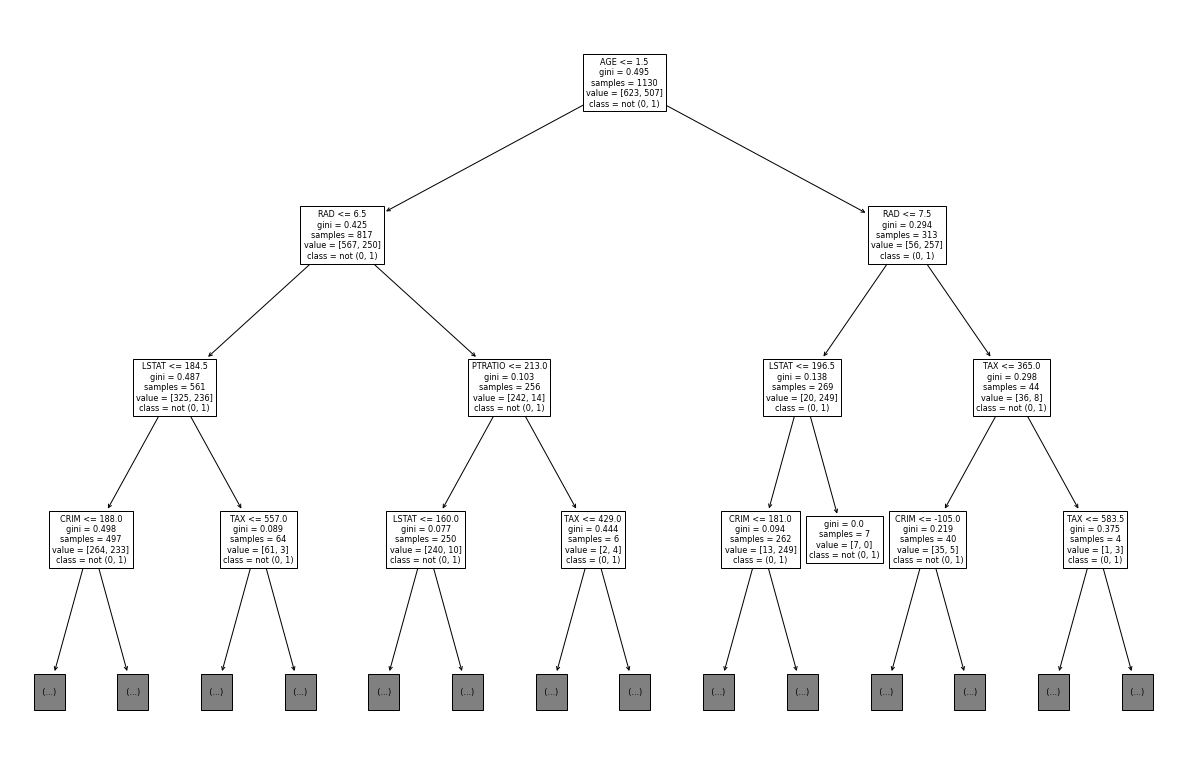

In [251]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

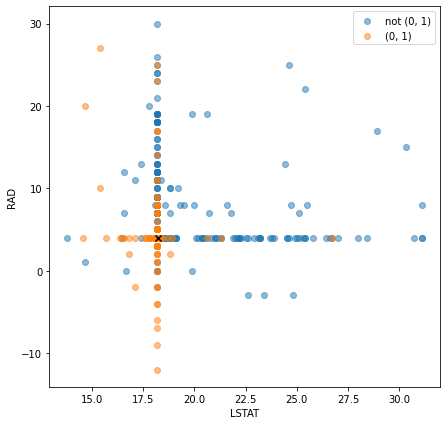

In [235]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'LSTAT', 'RAD', highlight=x)

In [254]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['RAD'] = 8
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      55     55

before  after
(0, 0)     NaN      2
(0, 1)     6.0      4

### 2. Cluster

The following feature value distributions are different locally and globally:
- LSTAT ranges up to 18.5
- ZN ranges up to 12.5
- INDUS ranges from 4 upwards
- CRIM ranges up to 13.5
- RM ranges up to 6.6
- RAD ranges from 2 upwards
- DIS ranges up to 6.5

Comparing that to the global level, we can reason for instances in this cluster that:
- if LSTAT was higher (>18.5), its effect towards $(0,0)$ would be maximized: setting $LSTAT=20$ changes all predictions of instances classified differently to this class and also many instances classified $(1,1)$

Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if CRIM was higher, its effect would shift towards $(0,0)$: setting $CRIM=7$ changes all predictions of instances classified differently to this class and most instances classified $(1,1)$

In [262]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c2      21       7       0       0      16       0       0       0       0

In [140]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

CRIM         ZN      INDUS        NOX         RM        AGE  \
count  44.000000  44.000000  44.000000  44.000000  44.000000  44.000000   
mean    3.140730   0.284091  15.149721   0.614859   5.983925   1.750000   
std     3.093628   1.884446   5.336916   0.091895   0.455269   0.533745   
min     0.045600   0.000000   4.050000   0.437000   3.863000   0.000000   
25%     0.772699   0.000000   8.140000   0.538000   5.815472   2.000000   
50%     2.307150   0.000000  18.100000   0.605000   6.012114   2.000000   
75%     5.084718   0.000000  18.100000   0.703649   6.266802   2.000000   
max    13.522200  12.500000  25.650000   0.871000   6.630226   2.000000   

             DIS        RAD         TAX    PTRATIO      LSTAT  
count  44.000000  44.000000   44.000000  44.000000  44.000000  
mean    3.080837  13.590639  490.511971  19.299317  15.399159  
std     1.223129   9.843581  175.978847   2.158524   1.789277  
min     1.510600   2.000000  188.000000  14.700000  11.100000  
25%     2.294218   4.000000  307.000000  19.175000  14.180000  
50%     2.566201   5.500000  420.000000  20.200000  16.042537  
75%     4.362779  24.000000  666.000000  20.375000  16.641653  
max     6.592100  24.000000  679.526743  21.200000  18.577295

In [141]:
df[pred_classes == '(0, 1)']

CRIM   ZN  INDUS    NOX        RM  AGE       DIS   RAD    TAX  \
2   3.836840  0.0  18.10  0.770  6.251000  2.0  2.295500  24.0  666.0   
6   2.242360  0.0  19.58  0.605  5.854000  2.0  2.422000   5.0  403.0   
10  2.300400  0.0  19.58  0.605  6.319000  2.0  2.100000   5.0  403.0   
26  0.911039  0.0   8.14  0.538  6.020228  2.0  4.441690   4.0  307.0   
27  2.313900  0.0  19.58  0.605  5.880000  2.0  2.388700   5.0  403.0   
37  0.889075  0.0   8.14  0.538  5.614909  2.0  4.350506   4.0  307.0   
41  0.045600  0.0  13.89  0.550  5.888000  1.0  3.112100   5.0  276.0   

    PTRATIO      LSTAT  
2      20.2  14.190000  
6      14.7  11.640000  
10     14.7  11.100000  
26     21.0  17.066695  
27     14.7  12.030000  
37     21.0  16.796984  
41     16.4  13.510000

In [277]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 20
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      21     21

before  after
(0, 0)     NaN    7.0
(0, 1)     7.0    NaN

before  after
(0, 0)     NaN   14.0
(0, 1)     NaN    2.0
(1, 1)    16.0    NaN

#### SHAP-based Difference Classifier Explanations

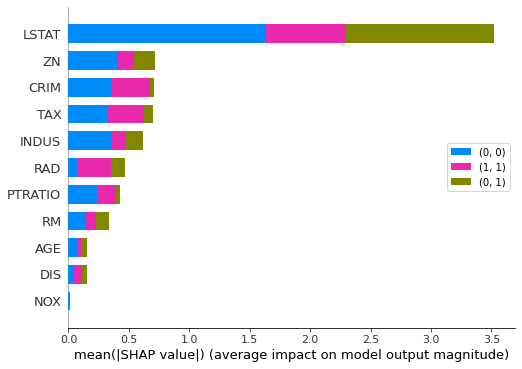

In [143]:
classes = np.unique(pred_classes)
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

6

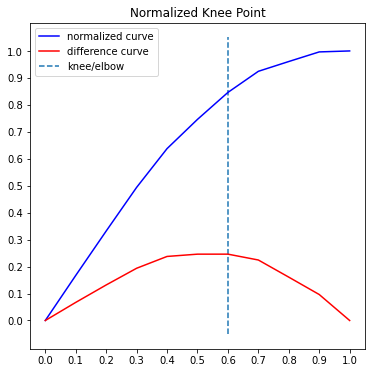

In [144]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

In [145]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

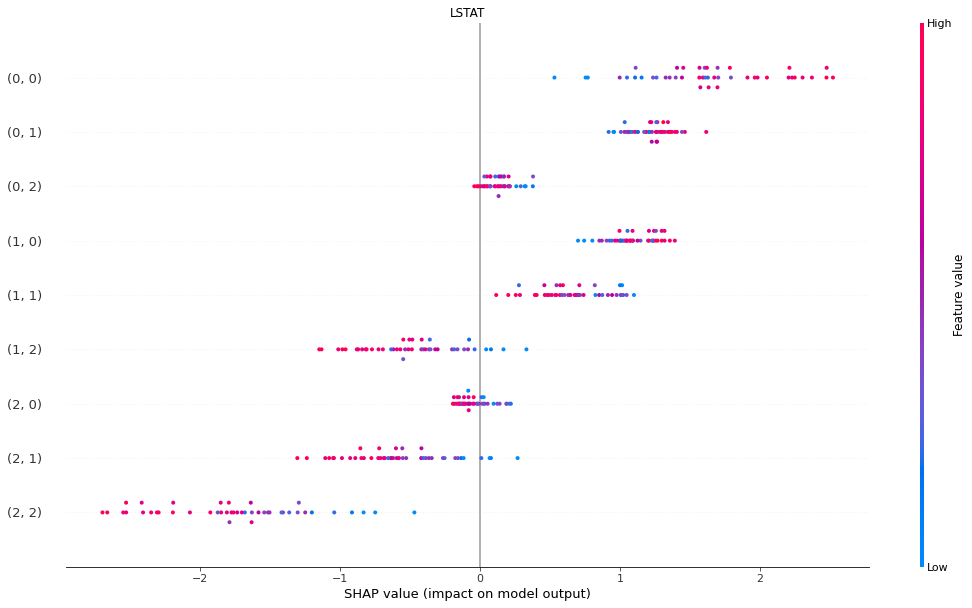

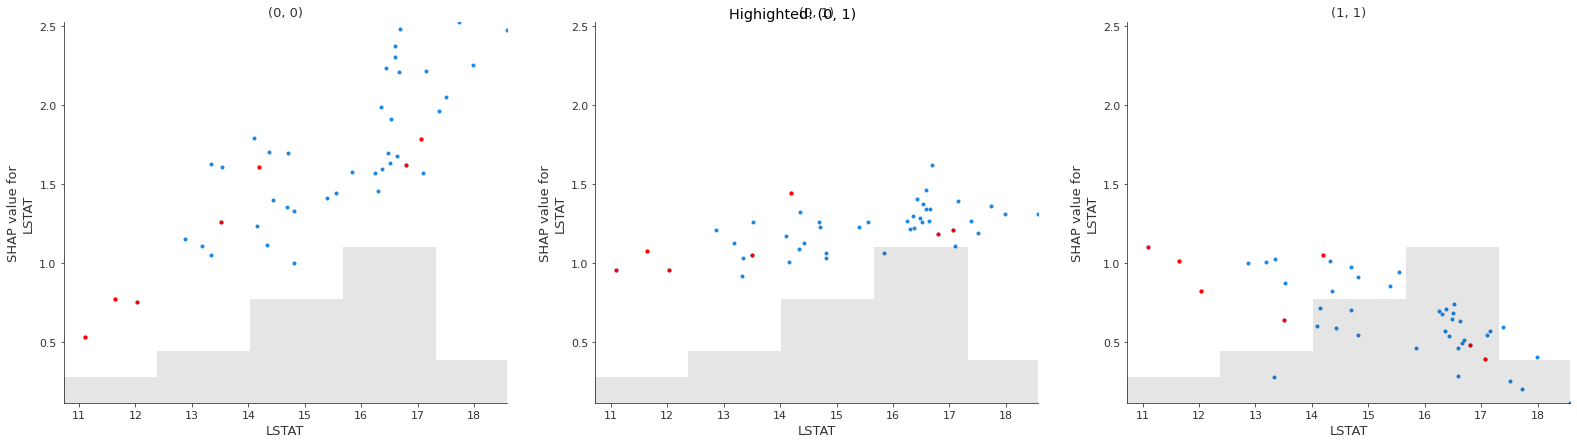

In [146]:
plot_next_feature()

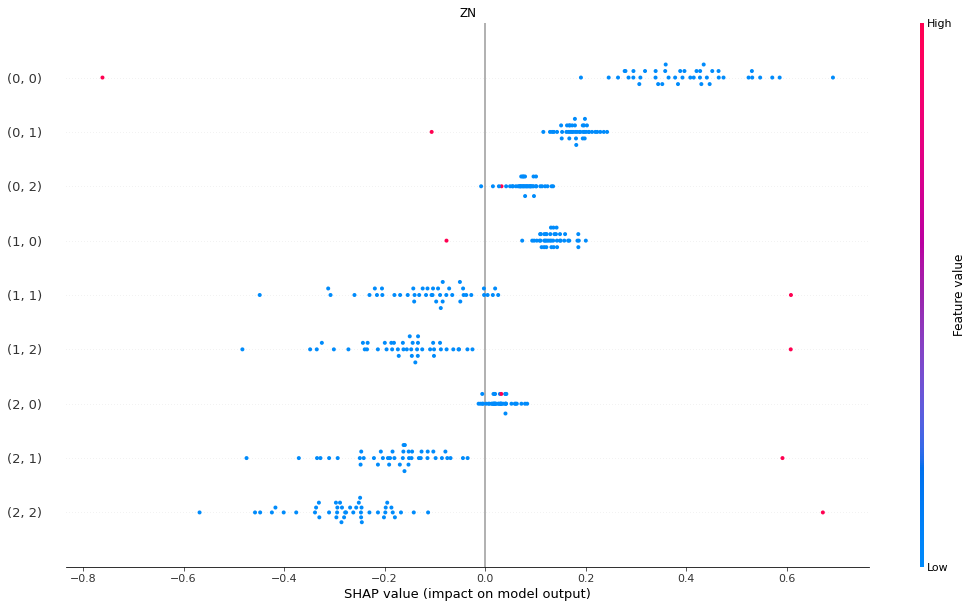

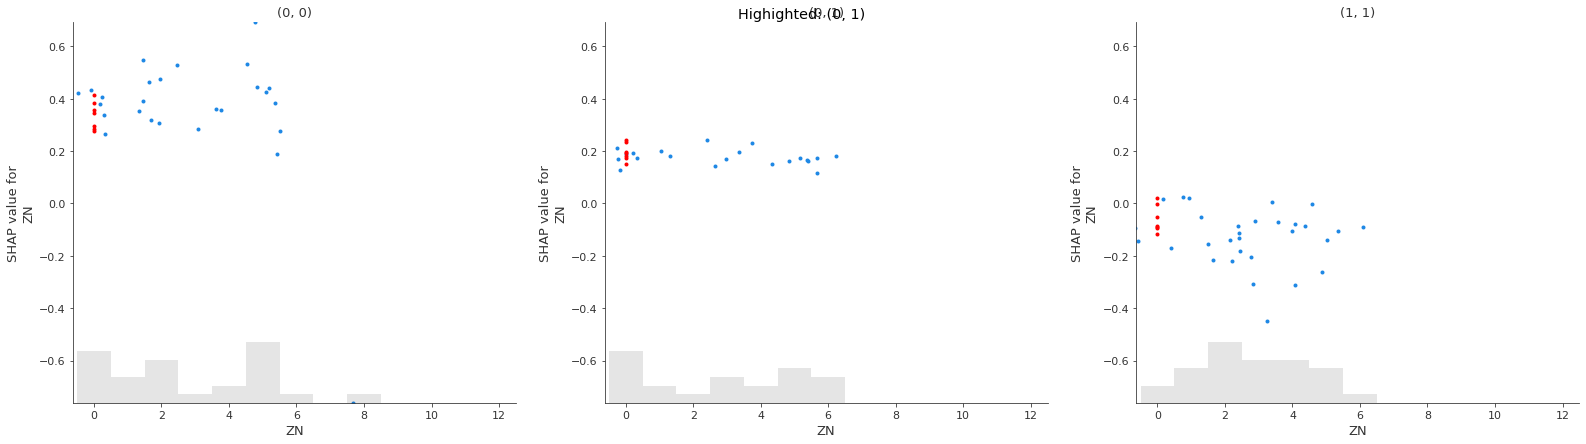

In [147]:
plot_next_feature()

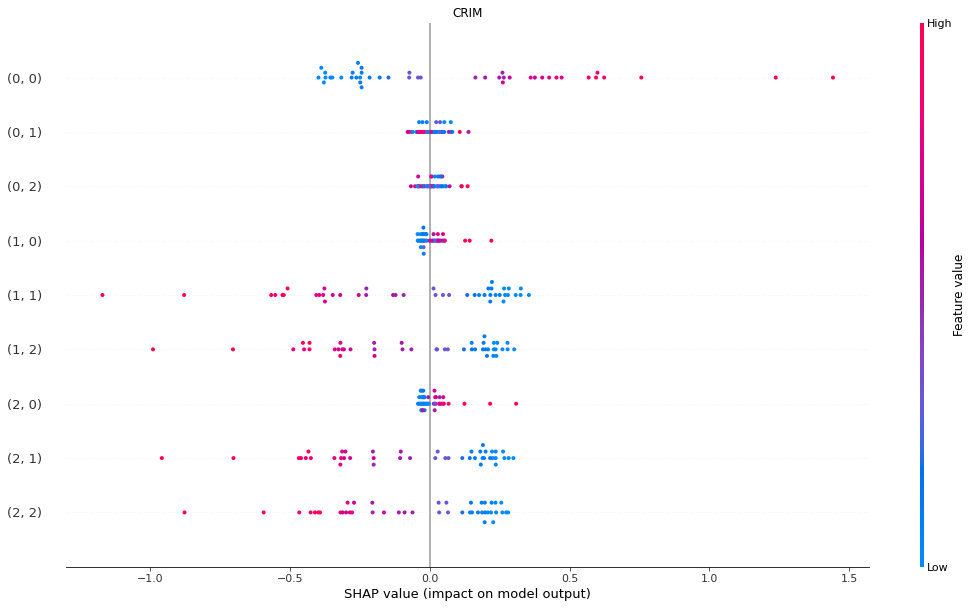

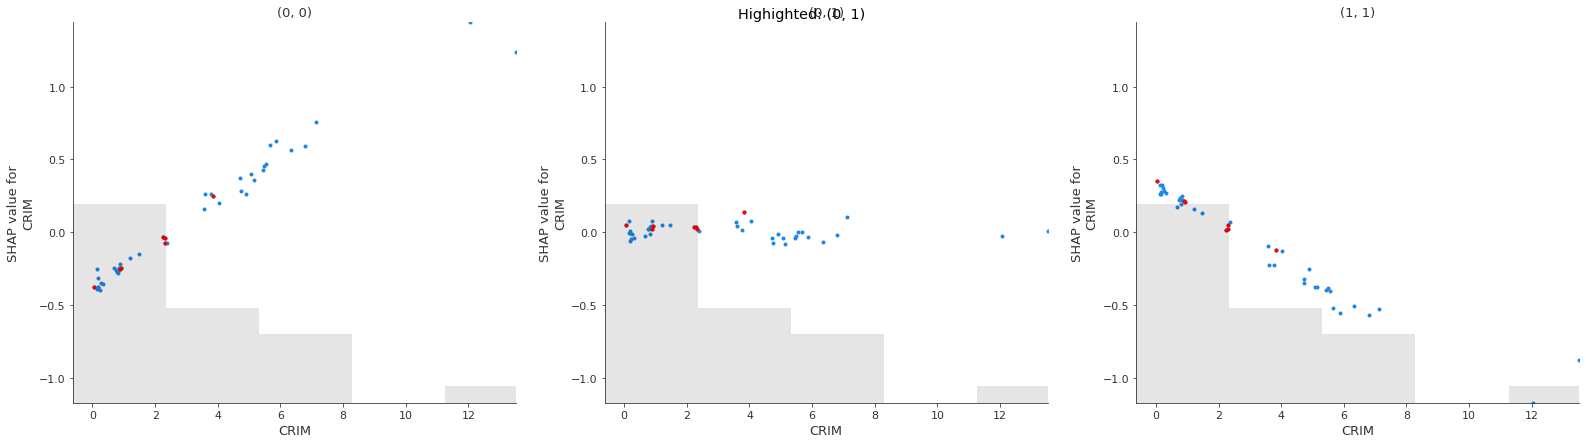

In [148]:
plot_next_feature()

In [280]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['CRIM'] = 7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      21     21

before  after
(0, 0)     NaN    7.0
(0, 1)     7.0    NaN

before  after
(0, 0)     NaN   15.0
(0, 1)     NaN    1.0
(1, 1)    16.0    NaN

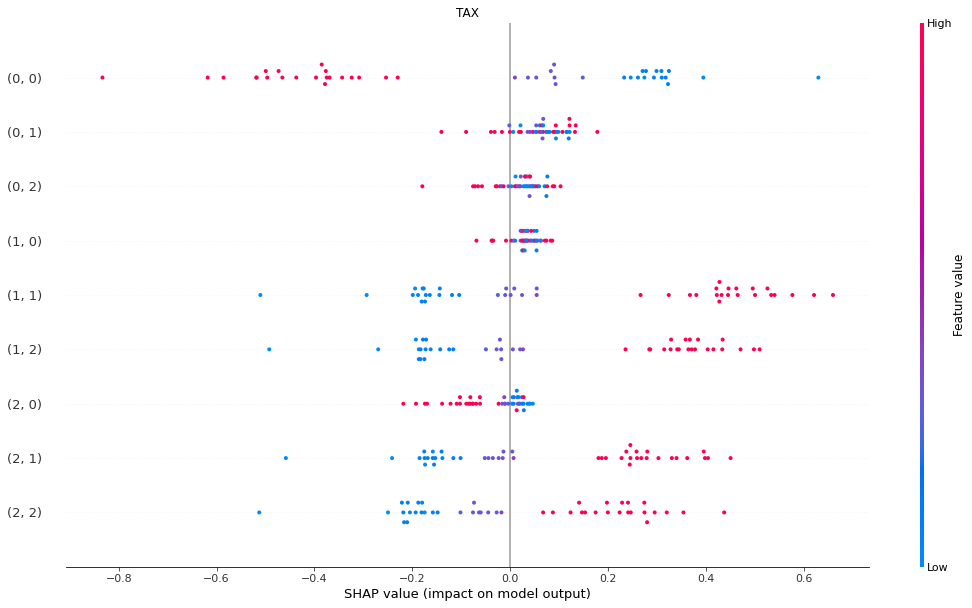

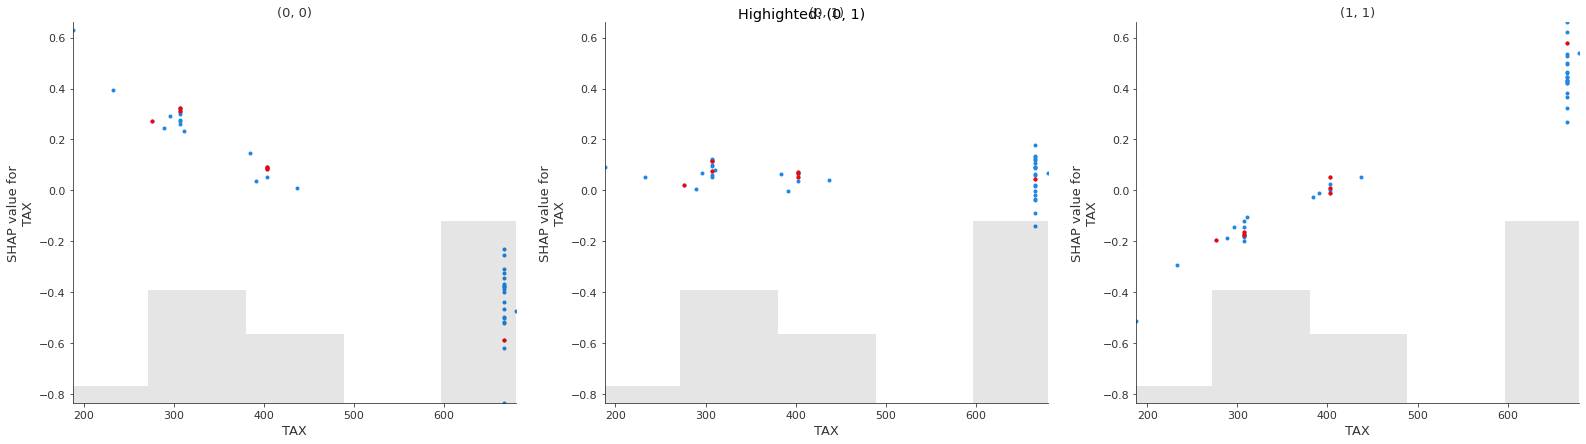

In [149]:
plot_next_feature()

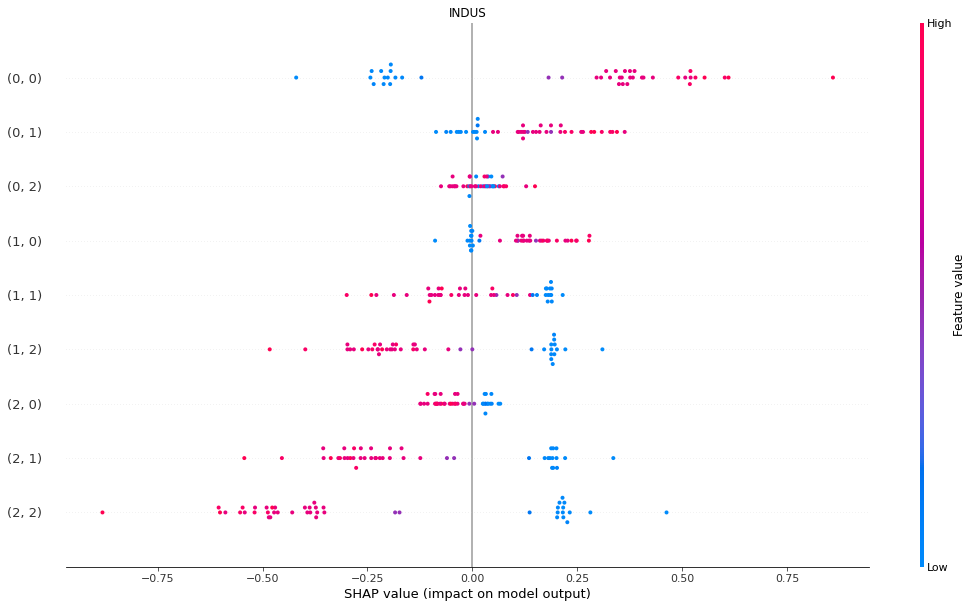

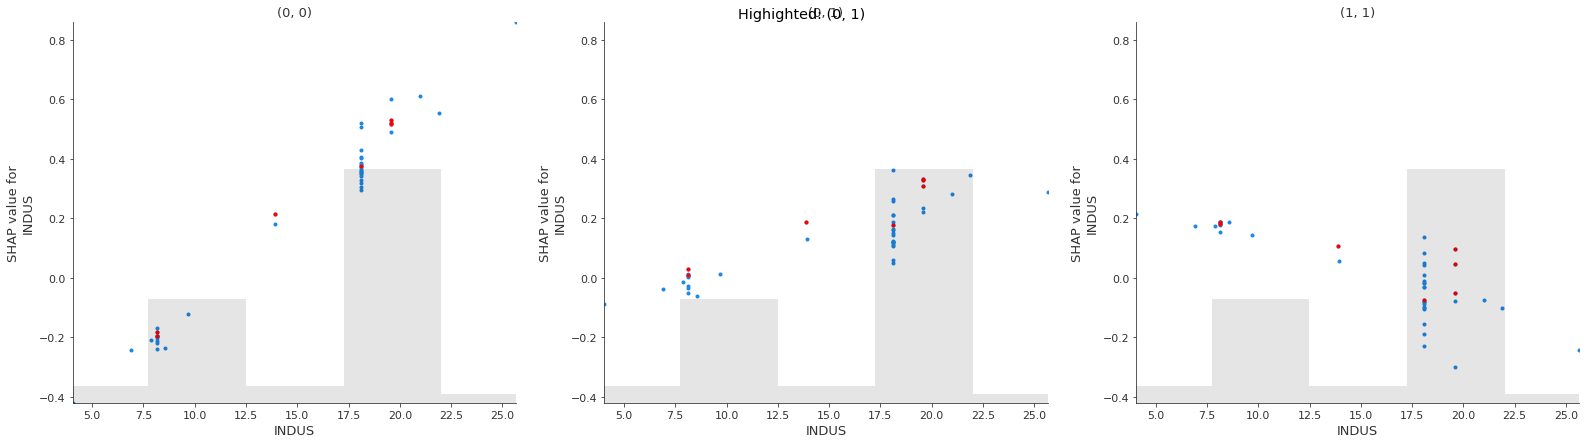

In [150]:
plot_next_feature()

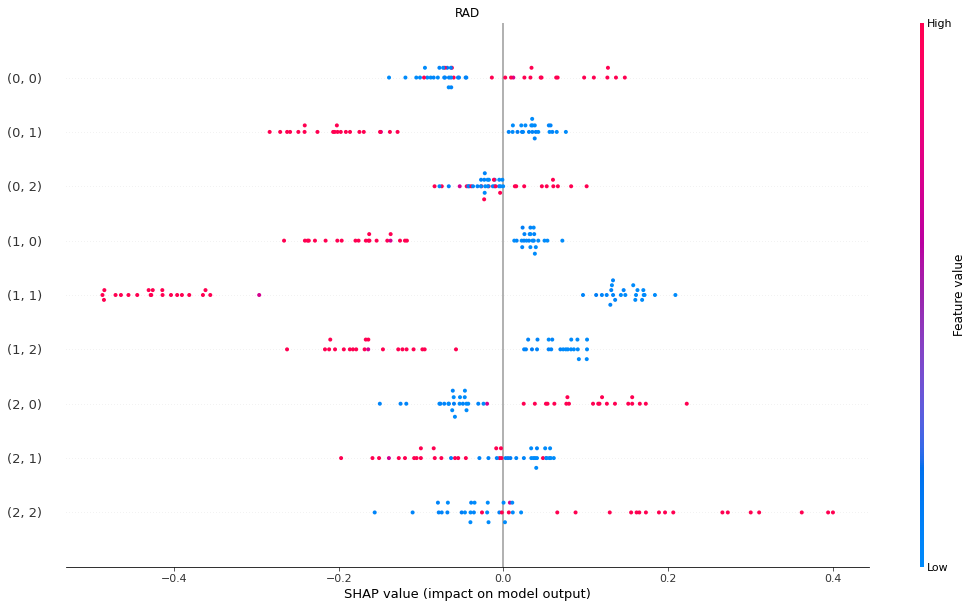

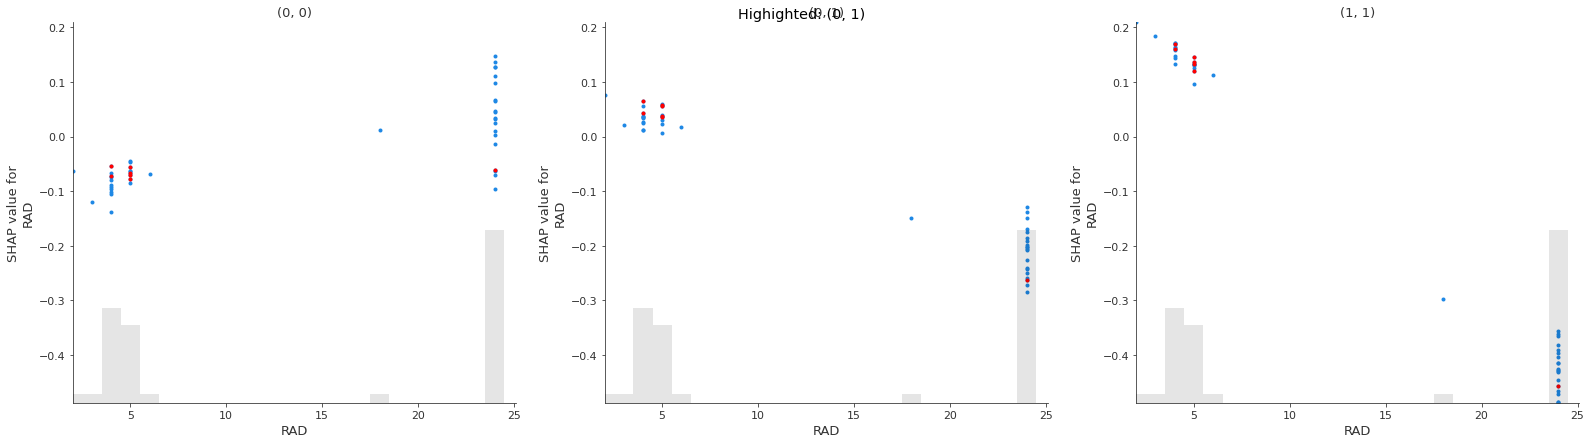

In [151]:
plot_next_feature()

#### diro2c

In [263]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [265]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 21.1 s, sys: 367 ms, total: 21.5 s
Wall time: 21.7 s


In [266]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

We see less instances classified differently above $CRIM=6$, confirming my previous finding. AGE is in the root node, but upon further investigation it turns out that if setting $AGE=0$ changes 5/7 predictions of instances classified $(0,1)$ to $(1,0)$, the rest to $(0,0)$.

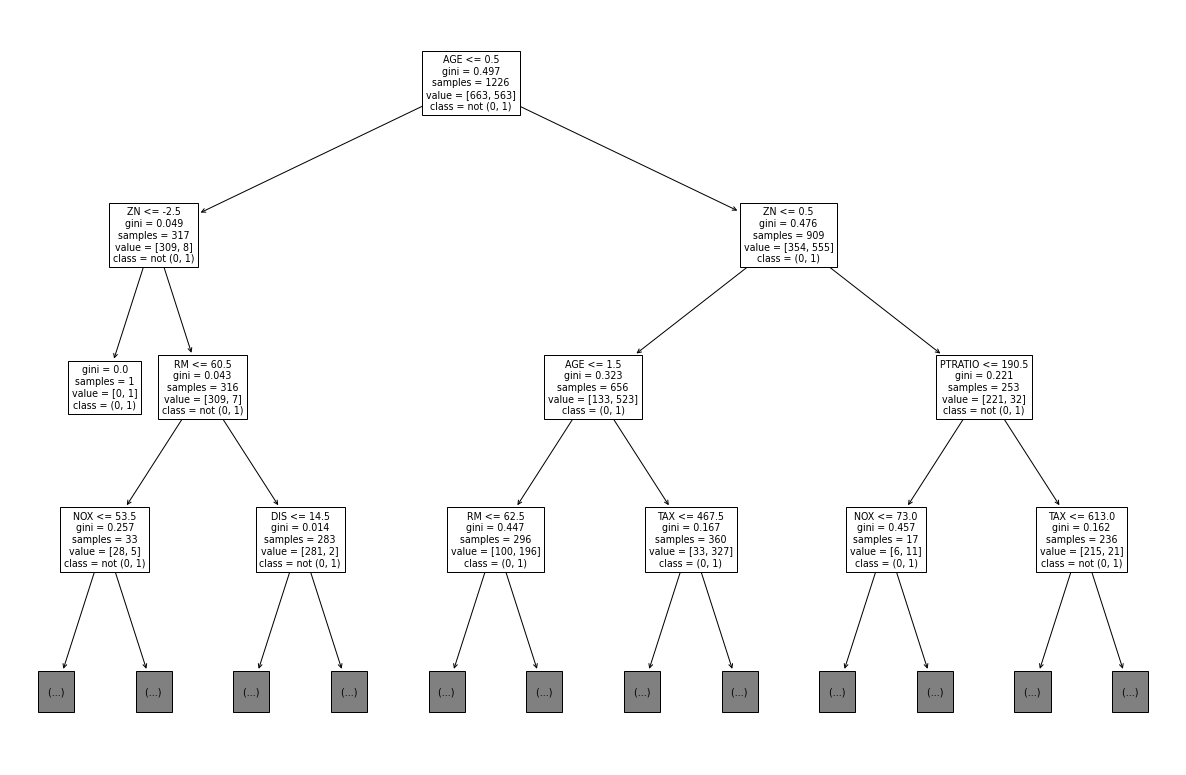

In [267]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

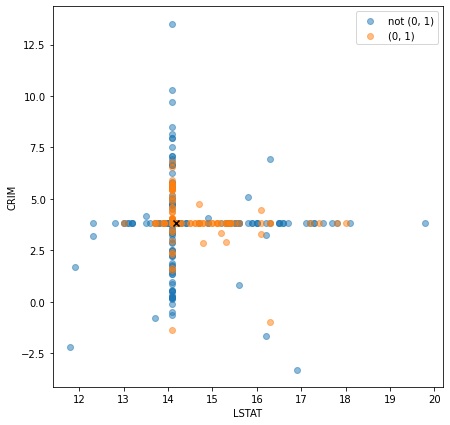

In [270]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'LSTAT', 'CRIM', highlight=x)

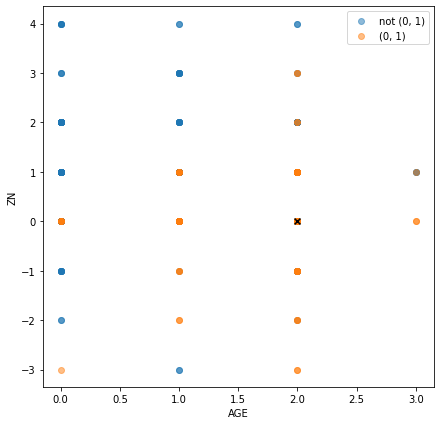

In [271]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'AGE', 'ZN', highlight=x)

In [272]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(0, 0)      21     21

before  after
(0, 0)     NaN    2.0
(0, 1)     7.0    NaN
(1, 0)     NaN    5.0

before  after
(1, 0)     NaN      6
(1, 1)    16.0     10

### 3. Cluster

The following feature value distributions are different locally and globally:
- LSTAT only ranges from 8 to 15 ($(1,1)$ is at its maximum here)
- ZN only ranges from 0 to 75
- INDUS only ranges up to 18
- CRIM only ranges up to 5
- RM only ranges from 5.5 to 7.2
- DIS only ranges up to 8

Comparing that to the global level, we can reason for instances in this cluster that:
- if LSTAT was lower, its effect would shift towards $(2,2)$: setting $LSTAT=7$ flips the prediction of the instance classified differently to this class
- if ZN was higher, its effect would shift towards $(2,2)$: setting $(ZN=80)$ flips the prediction of the instance classified differently to this class
- if INDUS was higher, its effect would shift towards $(1,1)$: setting $(INDUS=19)$ flips the prediction of the instance classified differently to this class
- if RM was higher, its effect would shift towards $(2,2)$: setting $(RM=7.5)$ flips the prediction of the instance classified differently to this class
- if DIS was higher, its effect would shift towards $(1,1)$: setting $(DIS=9)$ flips the prediction of the instance classified differently to this class

Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if LSTAT was higher, its effect would shift towards $(1,1)$: setting $(LSTAT=9.1)$ flips the prediction of the instance classified differently to this class
- if INDUS was higher, its effect would shift towards $(1,1)$: setting $(INDUS=2.9)$ flips the prediction of the instance classified differently to this class
- if RAD was lower, its effect would shift towards $(1,1)$: setting $(RAD=6)$ flips the prediction of the instance classified differently to this class

In [281]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c4       0       0       0       0      28       0       0       1       0

In [282]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

CRIM         ZN      INDUS        NOX         RM        AGE  \
count  29.000000  29.000000  29.000000  29.000000  29.000000  29.000000   
mean    0.642707  15.603448   7.776996   0.487915   6.222778   0.758621   
std     1.465917  19.963976   4.744912   0.061583   0.411048   0.635563   
min     0.010960   0.000000   2.180000   0.389000   5.593000   0.000000   
25%     0.054970   0.000000   5.130000   0.439000   5.891000   0.000000   
50%     0.128020   0.000000   5.860000   0.472000   6.195000   1.000000   
75%     0.299160  25.000000   9.690000   0.520000   6.474000   1.000000   
max     5.824010  75.000000  18.100000   0.647000   7.225003   2.000000   

             DIS        RAD         TAX    PTRATIO      LSTAT  
count  29.000000  29.000000   29.000000  29.000000  29.000000  
mean    4.834670   7.099330  337.673104  18.353113  10.884553  
std     1.962949   6.116269  129.421301   1.887457   1.730725  
min     2.115348   1.000000  193.000000  13.000000   8.230000  
25%     3.272100   4.000000  270.000000  16.900000   9.522242  
50%     4.153345   5.000000  295.520027  18.400000  10.580000  
75%     6.818500   8.000000  384.000000  19.700000  12.270000  
max     7.980900  24.000000  666.000000  21.100000  14.800000

In [284]:
df[pred_classes == diff_classes[0]]

CRIM    ZN  INDUS    NOX     RM  AGE   DIS  RAD    TAX  PTRATIO  LSTAT
11  0.05479  33.0   2.18  0.472  6.616  1.0  3.37  7.0  222.0     18.4   8.93

In [286]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 7
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     19
(2, 1)     NaN      2
(2, 2)     NaN      7

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

In [287]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['ZN'] = 80
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     25
(2, 1)     NaN      1
(2, 2)     NaN      2

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

In [288]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 19
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      28     28

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

In [289]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['RM'] = 7.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     25
(2, 1)     NaN      3

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

In [290]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['DIS'] = 9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      28     28

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

#### SHAP-based Difference Classifier Explanations

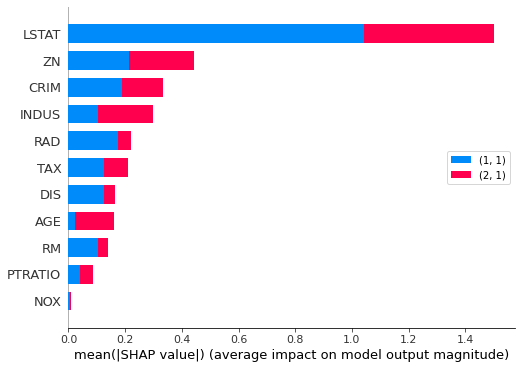

In [292]:
classes = np.unique(pred_classes)
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

5

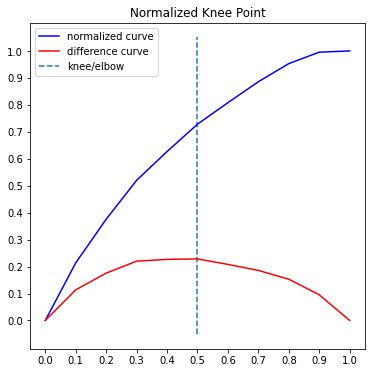

In [293]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

In [294]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

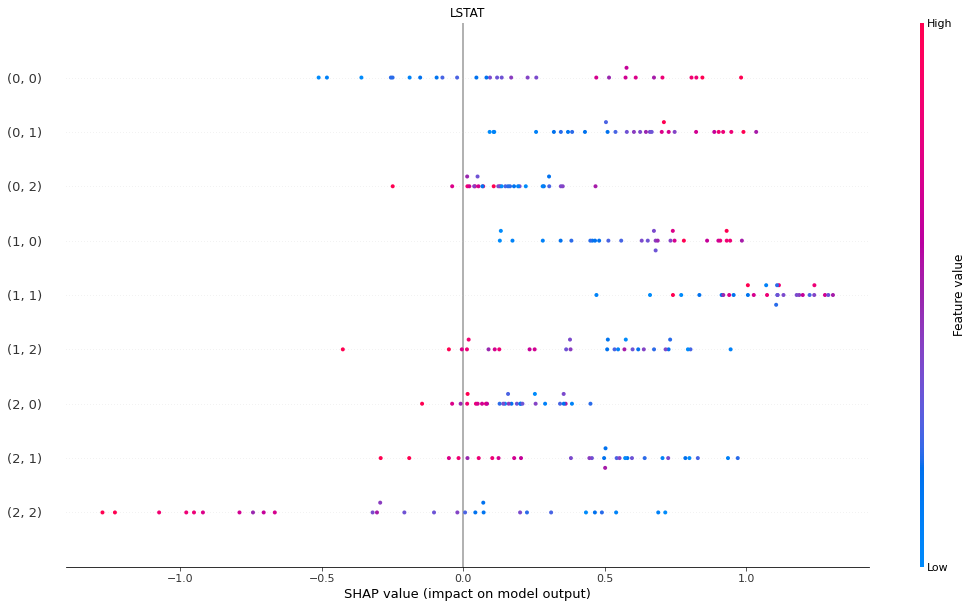

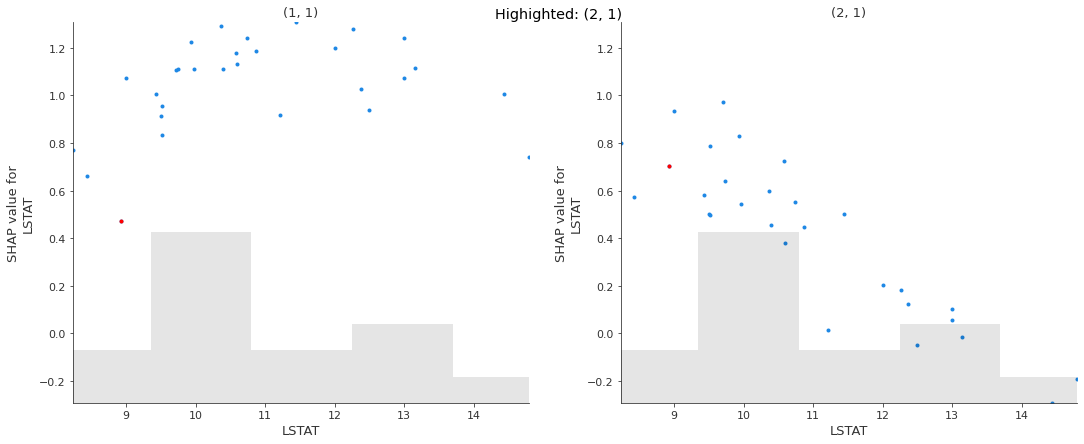

In [295]:
plot_next_feature()

In [303]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 9.1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     26
(2, 1)     NaN      2

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

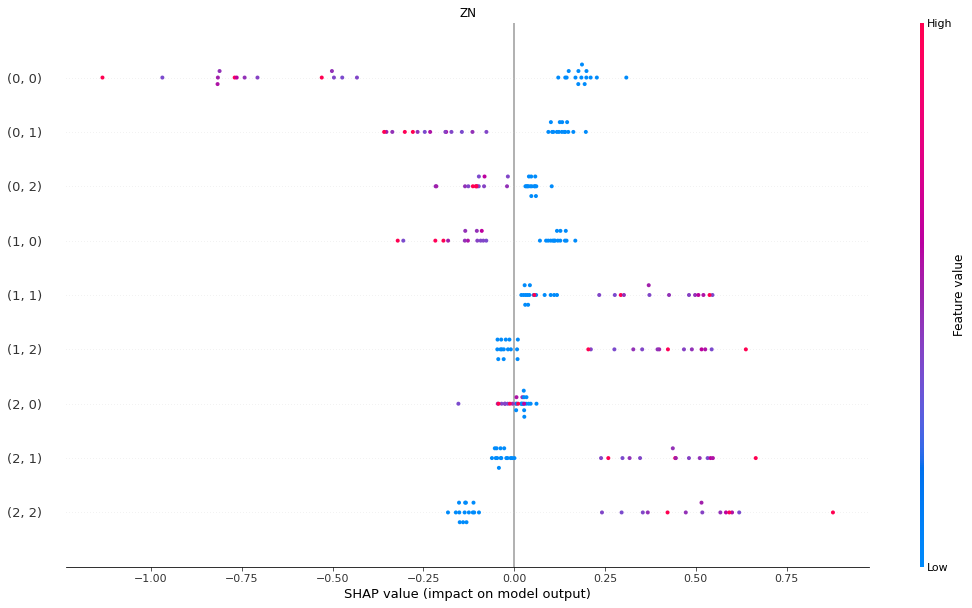

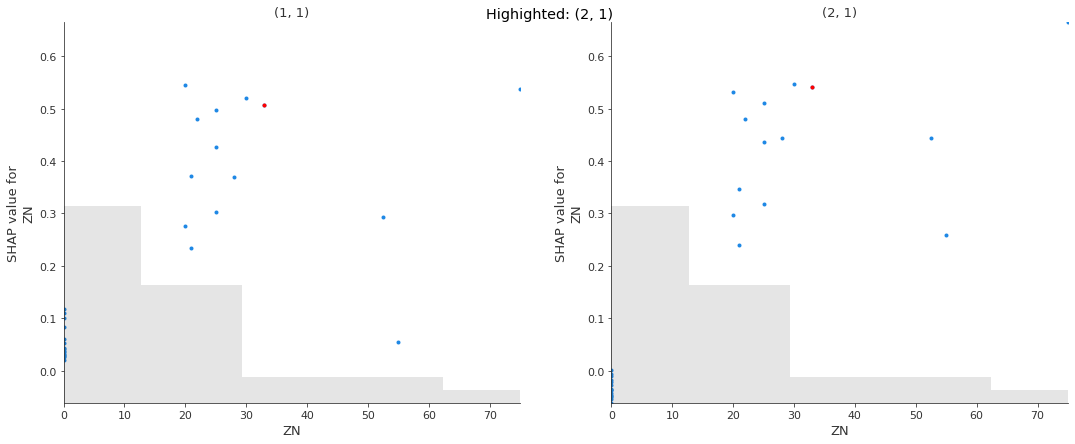

In [296]:
plot_next_feature()

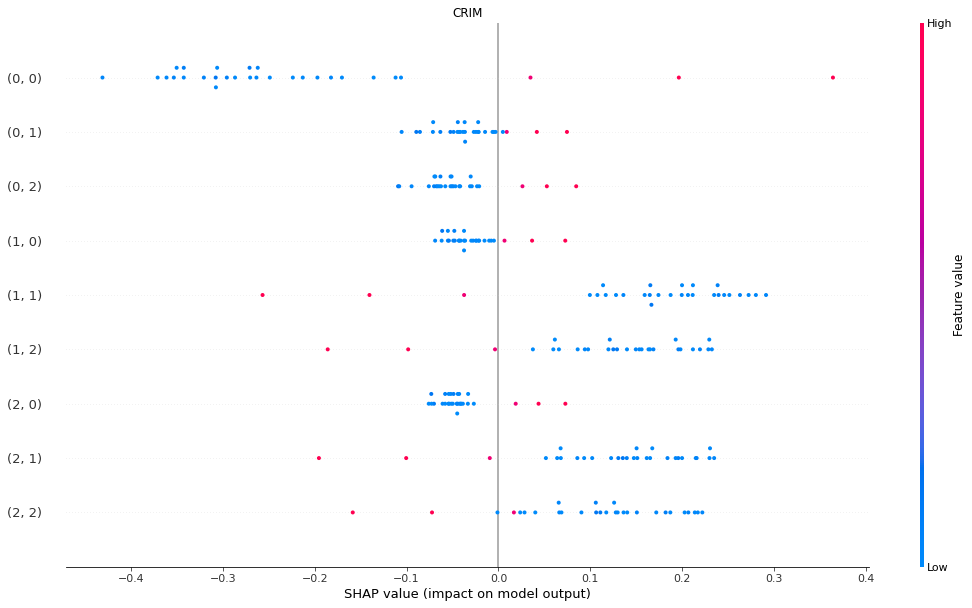

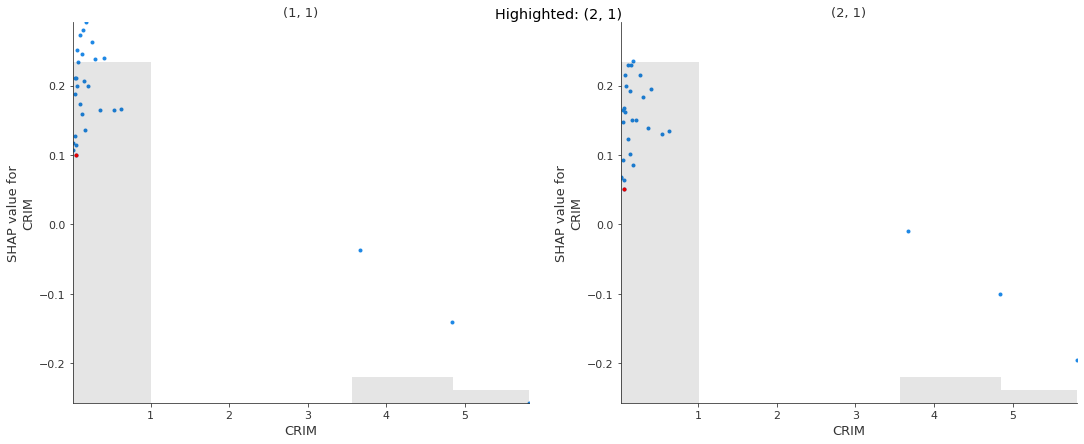

In [297]:
plot_next_feature()

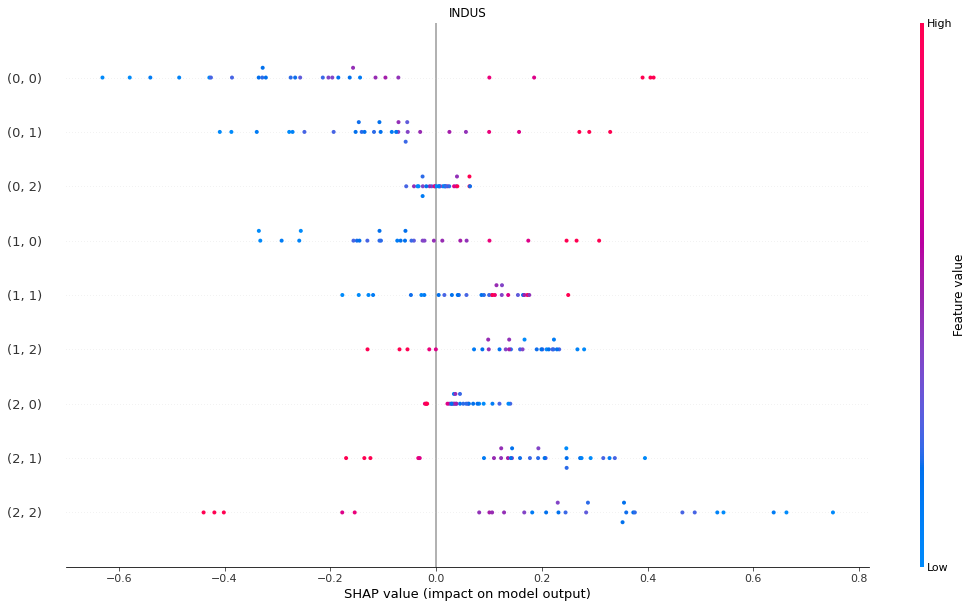

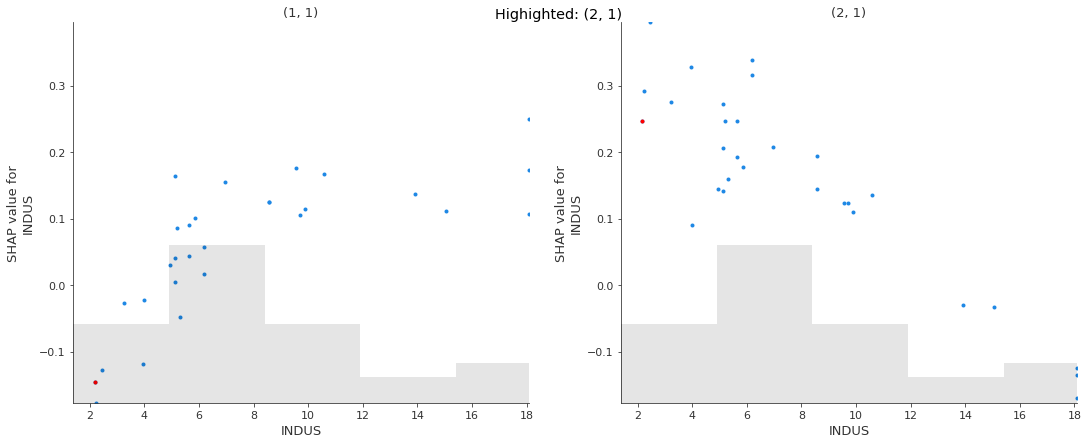

In [298]:
plot_next_feature()

In [309]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 2.9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     24
(2, 1)     NaN      2
(2, 2)     NaN      2

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

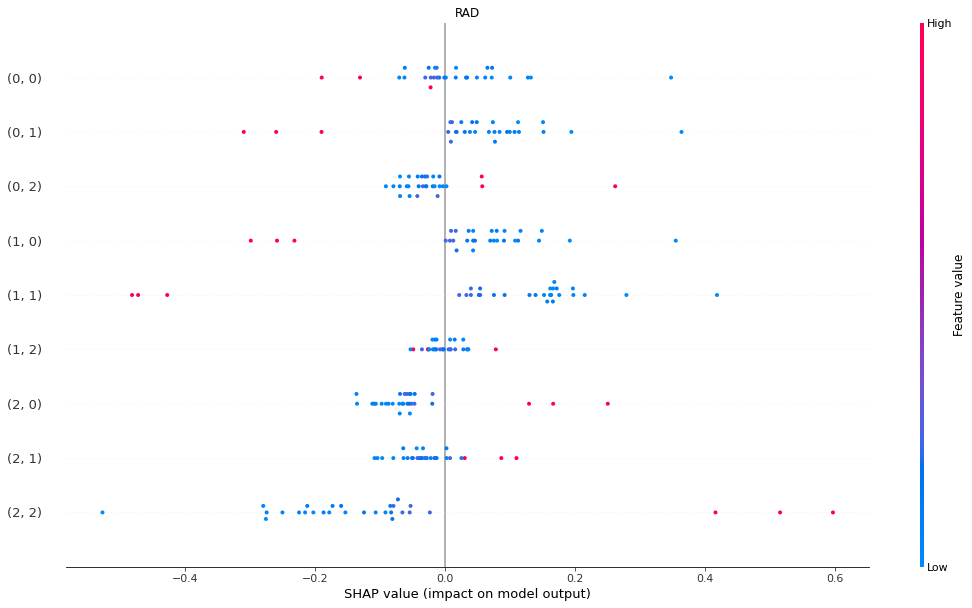

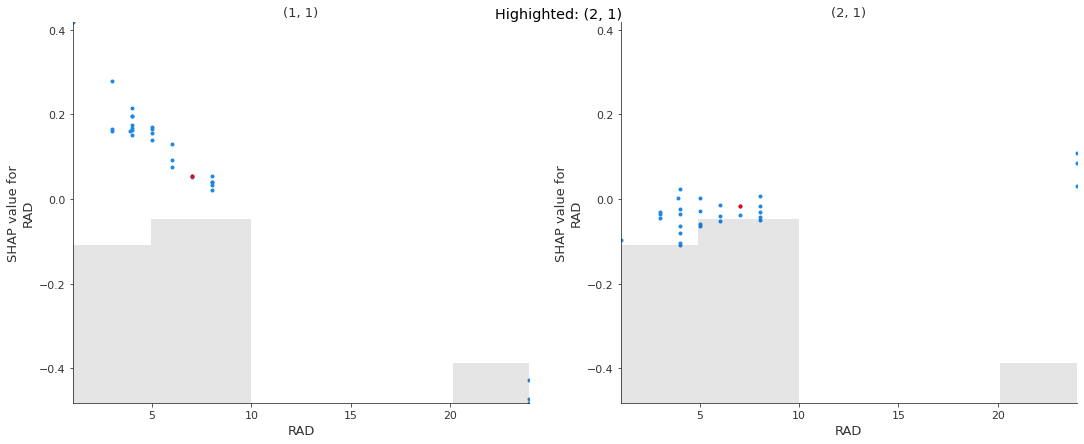

In [299]:
plot_next_feature()

In [312]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['RAD'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    28.0     27
(2, 1)     NaN      1

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

### 4. Cluster

The following feature value distributions are different locally and globally:
- LSTAT ranges only from 6.5 to 9.5 ($(2,1)$ is at its peak in this range)
- ZN is just 0
- INDUS is just 18.1, which is on the lower end
- CRIM is just 4.5 to 9.2
- TAX is just 666, which is on the higher end
- RAD is just 24, which is on the higher end
- DIS only ranges up to 3.4
- AGE ranges from 1 to 2, which is on the higher end
- PTRATIO is just 20.2

Comparing that to the global level, we can reason for instances in this cluster that:
- if LSTAT was lower, its effect would shift towards $(2,2)$: setting $LSTAT=6$ changes the prediction of the instance classified differently to this class.
- if LSTAT was higher, its effect would shift towards $(1,1)$: setting $LSTAT=10$ changes the prediction of the instance classified differently to this class.
- if ZN was higher, its effect would shift towards $(2,2)$: setting it to 90 changes the prediction of the instance classified differently to this class.
- if INDUS was lower, its effect would shift towards $(2,2)$: setting it to 12 changes the prediction of the instance classified differently to this class.
- if RAD was lower, its effect would shift towards $(1,1)$: setting it to 22 changes the prediction of the instance classified differently to this class.
- if DIS was higher, its effect would shift towards $(1,1)$: setting it to 4 changes the prediction of the instance classified differently to this class.

Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if DIS was higher, its effect would shift towards $(2,2)$: setting it to 2.5 changes the prediction of the instance classified differently to this class. (Please note, that the local effect is different from the global, which is not apparent when just interpreting the global explanations)


In [452]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c5       0       0       0       0       0       0       0       1      11

In [314]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

CRIM    ZN         INDUS        NOX         RM        AGE  \
count  12.000000  12.0  1.200000e+01  12.000000  12.000000  12.000000   
mean    7.684149   0.0  1.810000e+01   0.649154   6.036292   1.916667   
std     1.783436   0.0  3.710688e-15   0.056405   0.828679   0.288675   
min     4.541920   0.0  1.810000e+01   0.532000   3.561000   1.000000   
25%     6.752076   0.0  1.810000e+01   0.631000   6.072401   2.000000   
50%     8.634923   0.0  1.810000e+01   0.636389   6.196351   2.000000   
75%     8.954520   0.0  1.810000e+01   0.660560   6.275256   2.000000   
max     9.232300   0.0  1.810000e+01   0.770000   7.061000   2.000000   

             DIS   RAD    TAX       PTRATIO      LSTAT  
count  12.000000  12.0   12.0  1.200000e+01  12.000000  
mean    1.510308  24.0  666.0  2.020000e+01   8.373300  
std     0.716699   0.0    0.0  3.710688e-15   1.044418  
min     1.137912  24.0  666.0  2.020000e+01   6.550410  
25%     1.167818  24.0  666.0  2.020000e+01   7.622500  
50%     1.179197  24.0  666.0  2.020000e+01   8.834316  
75%     1.327546  24.0  666.0  2.020000e+01   9.116477  
max     3.410600  24.0  666.0  2.020000e+01   9.530000

In [316]:
df[pred_classes == diff_classes[0]]

CRIM   ZN  INDUS    NOX     RM  AGE     DIS   RAD    TAX  PTRATIO  LSTAT
3  4.55587  0.0   18.1  0.718  3.561  2.0  1.6132  24.0  666.0     20.2   7.12

In [317]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 6
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      11     11

In [318]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 10
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(1, 1)     NaN    1.0
(2, 1)     NaN   10.0
(2, 2)    11.0    NaN

In [331]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['ZN'] = 90
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      11     11

In [336]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 12
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      11     11

In [343]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['RAD'] = 22
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 1)     NaN      3
(2, 2)    11.0      8

In [344]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['DIS'] = 4
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(1, 1)     NaN      3
(2, 1)     NaN      4
(2, 2)    11.0      4

#### SHAP-based Difference Classifier Explanations

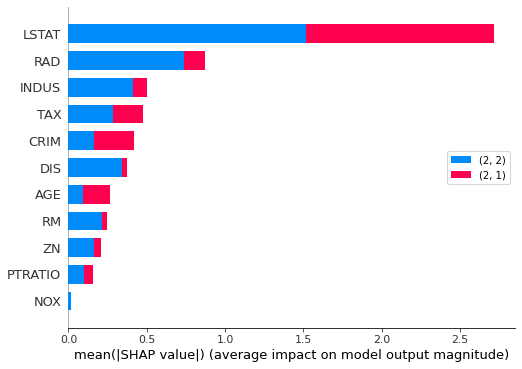

In [367]:
classes = np.unique(pred_classes)
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

Please note: I added one more feature to the set of important features because the first ones did not allow interpreting any effect.

5

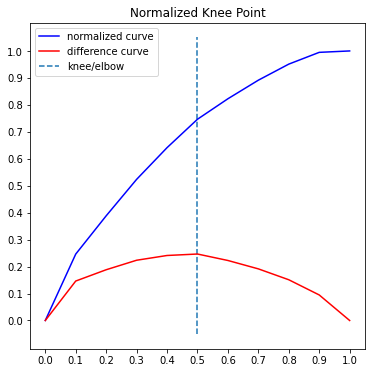

In [368]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features + 1]
n_important_features

In [369]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

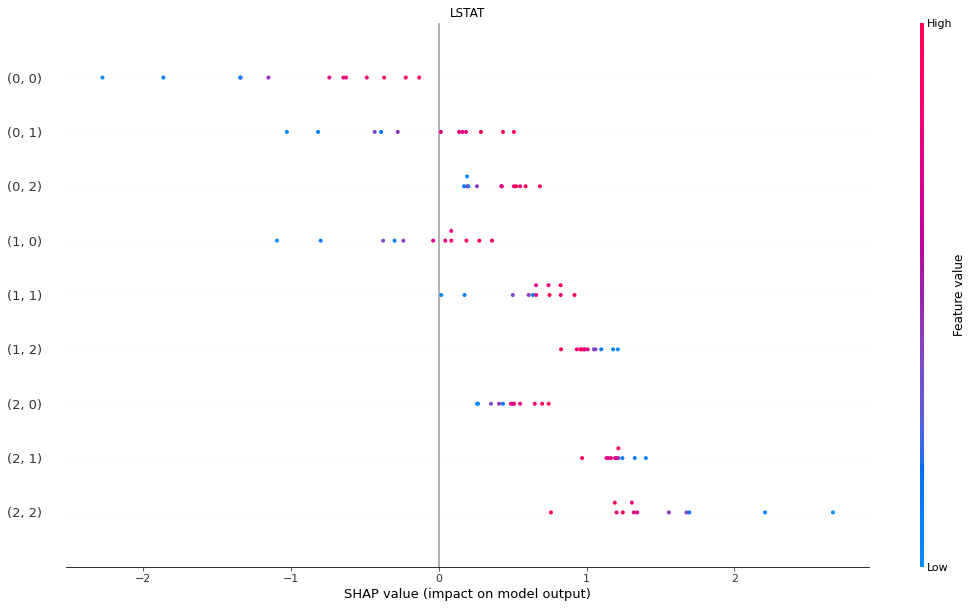

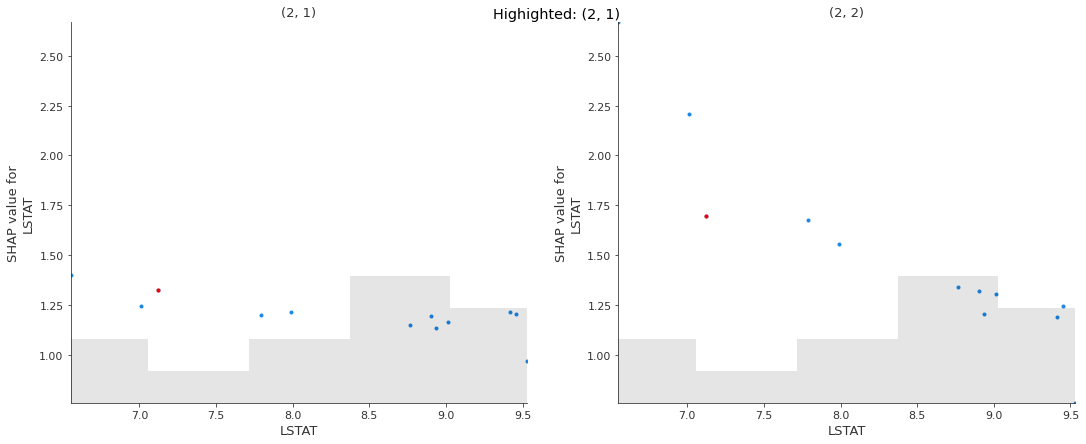

In [370]:
plot_next_feature()

In [371]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 6.55
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(2, 1)       1      1

before  after
(2, 2)      11     11

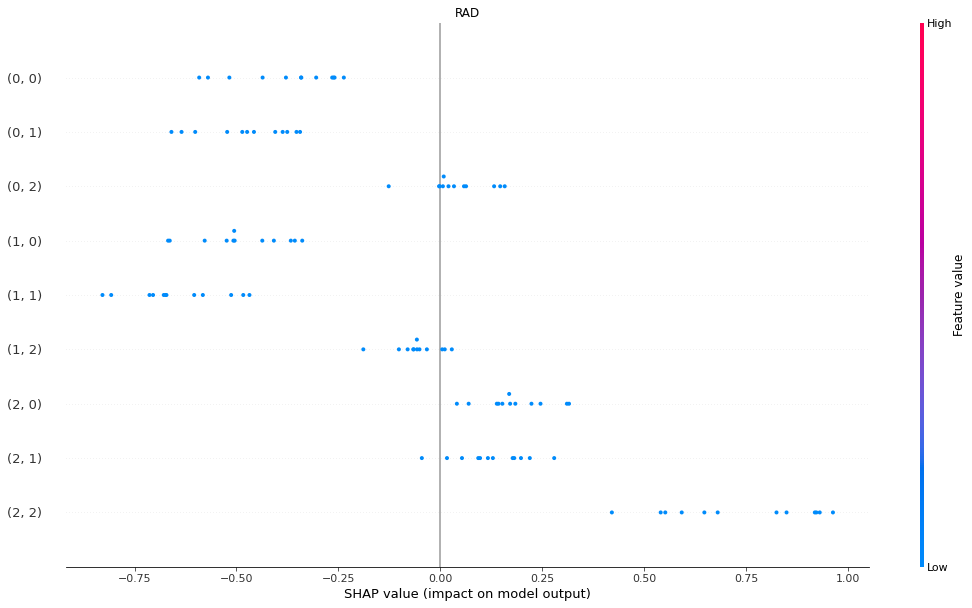

Attempting to set identical left == right == 24.0 results in singular transformations; automatically expanding.


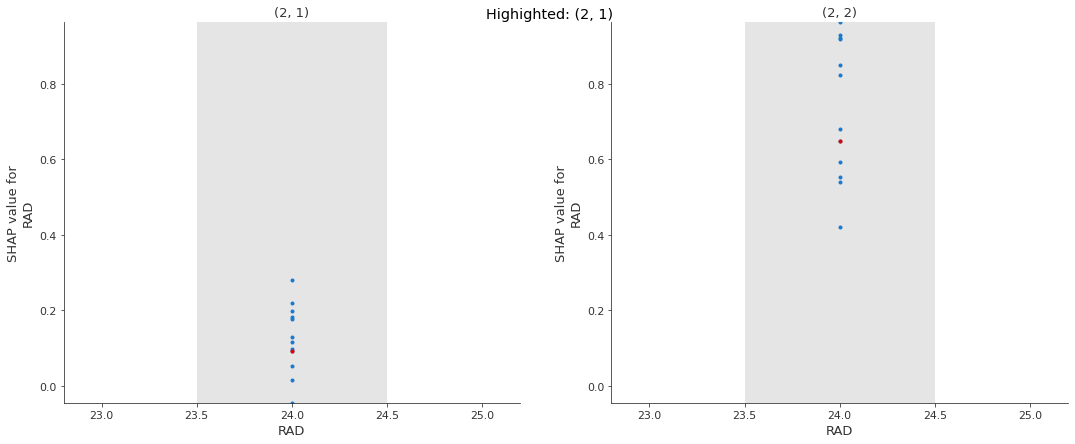

In [372]:
plot_next_feature()

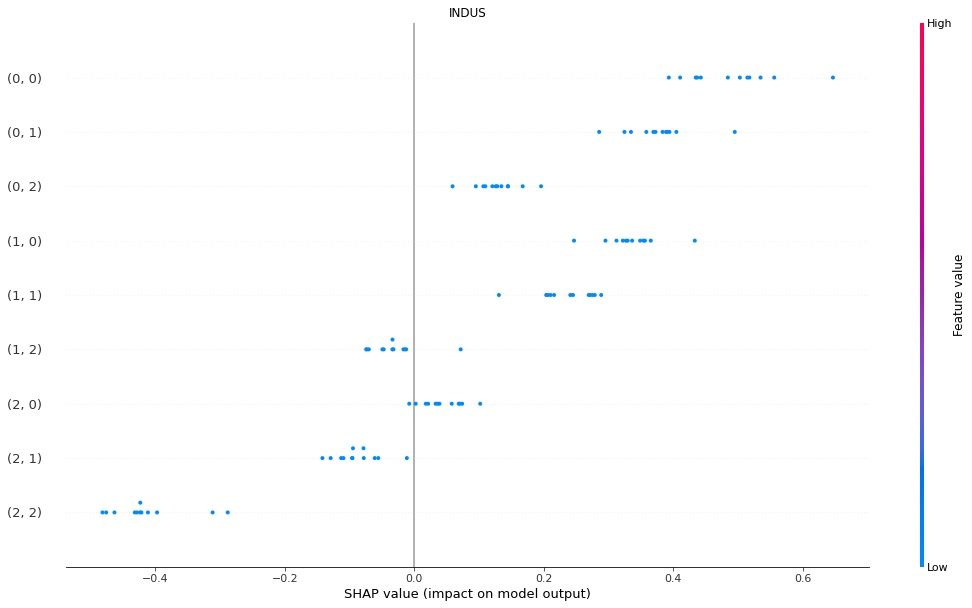

Attempting to set identical left == right == 18.1 results in singular transformations; automatically expanding.


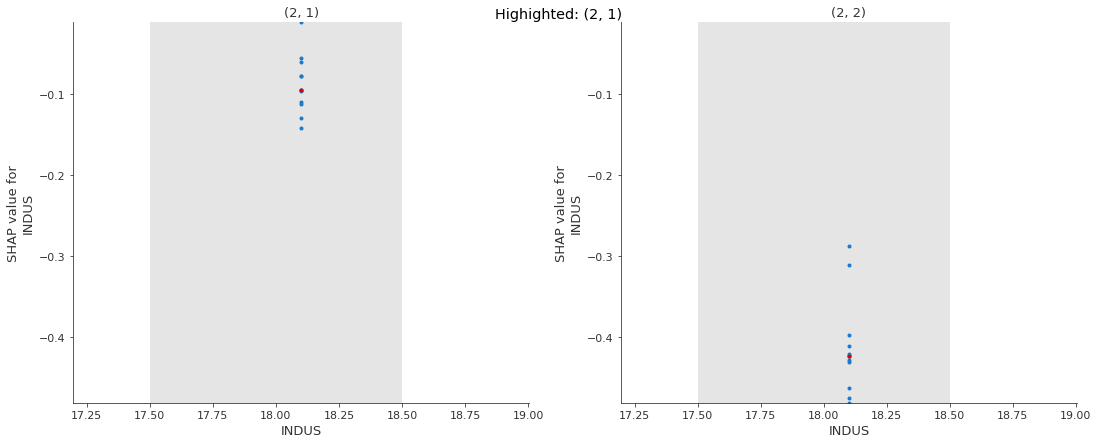

In [373]:
plot_next_feature()

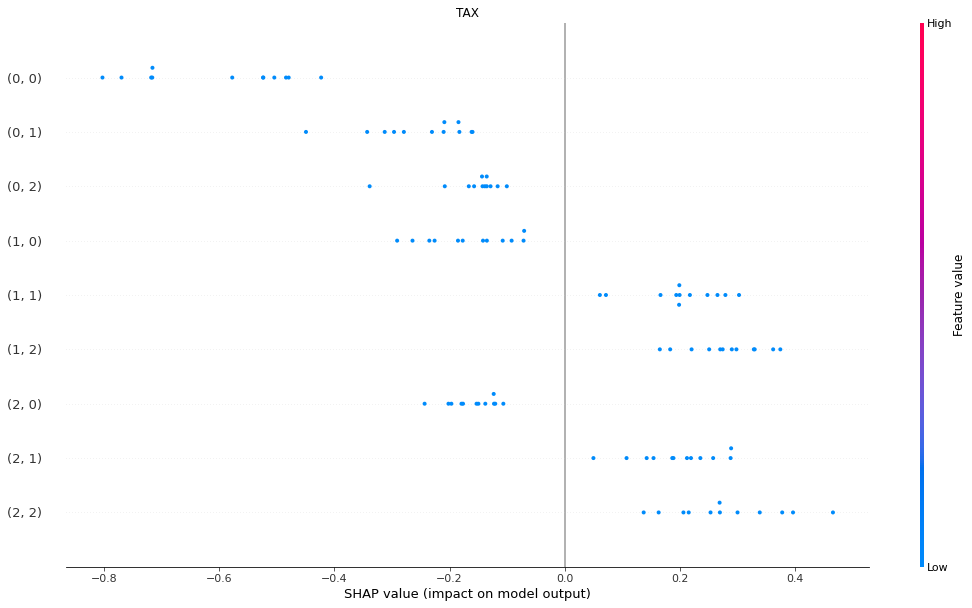

Attempting to set identical left == right == 666.0 results in singular transformations; automatically expanding.


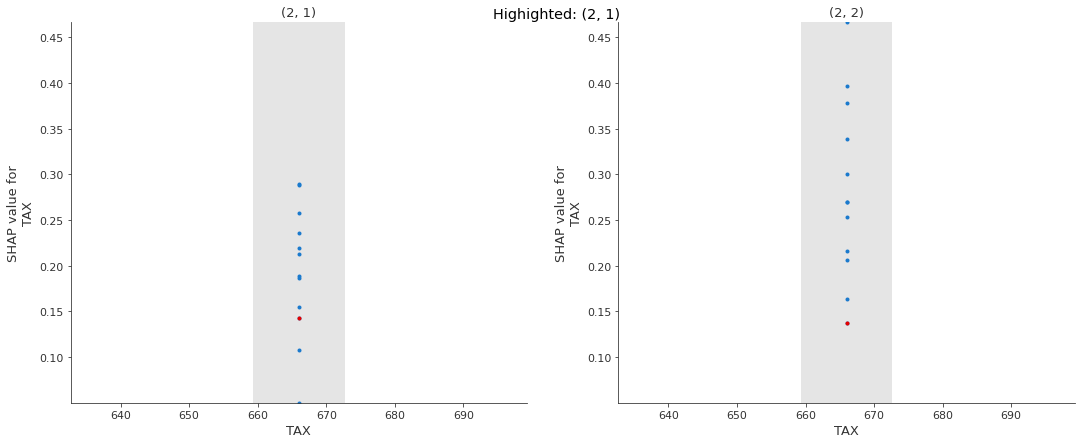

In [374]:
plot_next_feature()

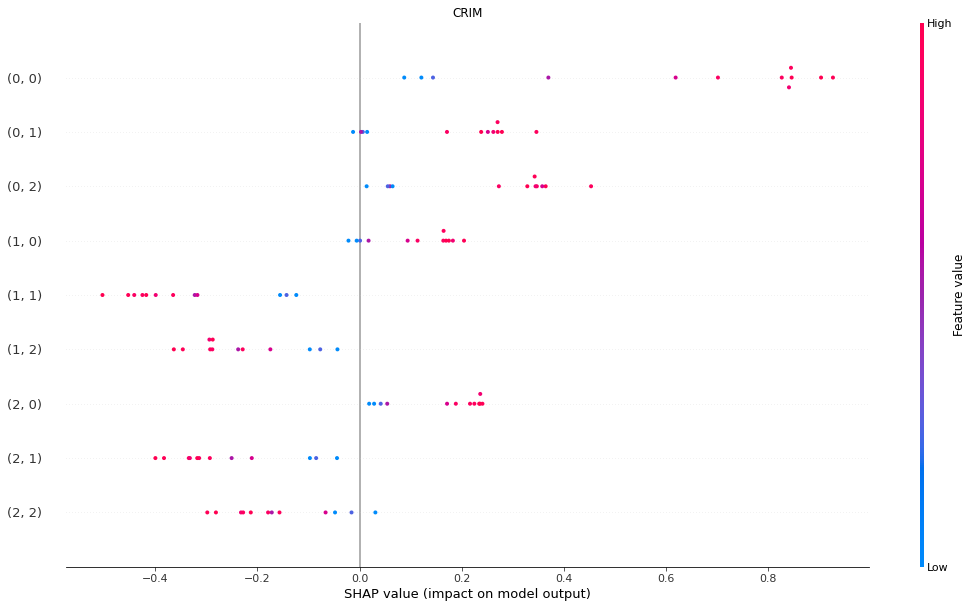

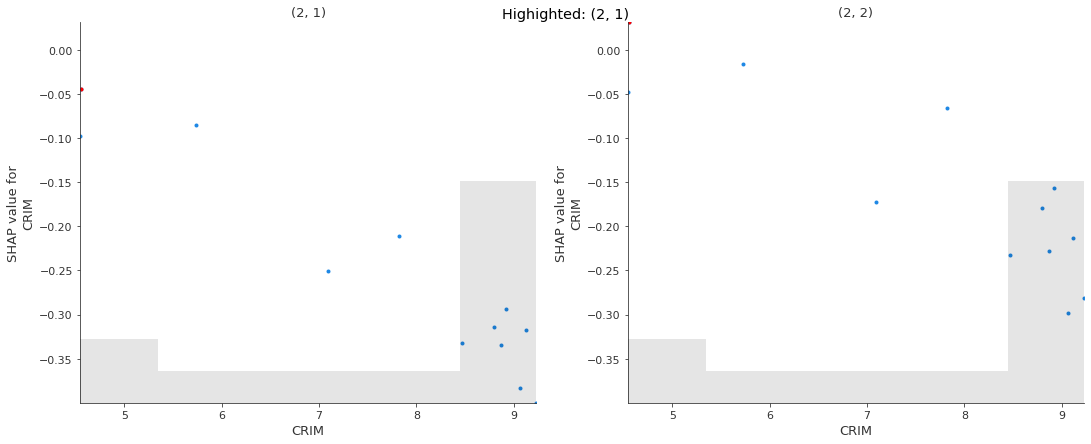

In [375]:
plot_next_feature()

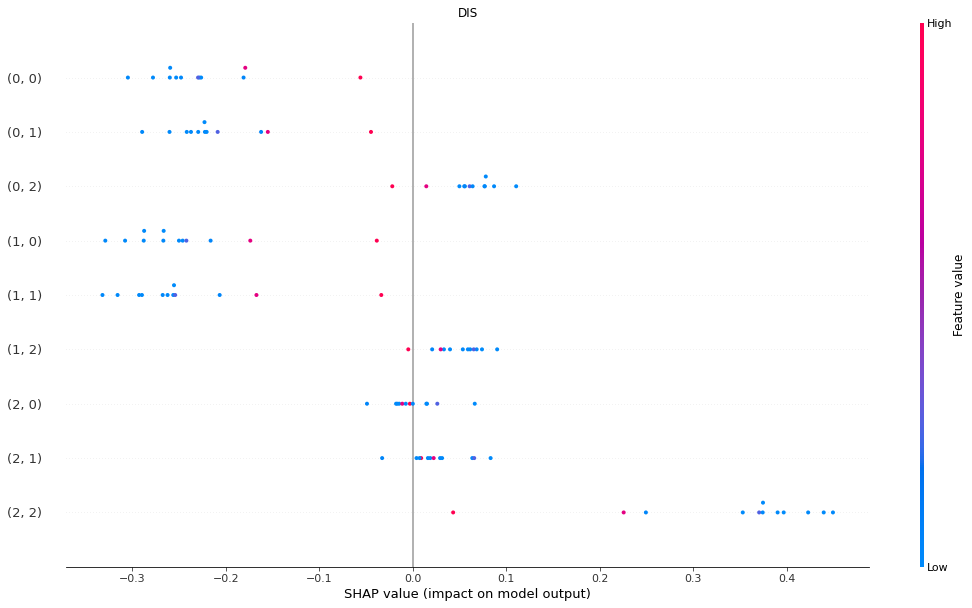

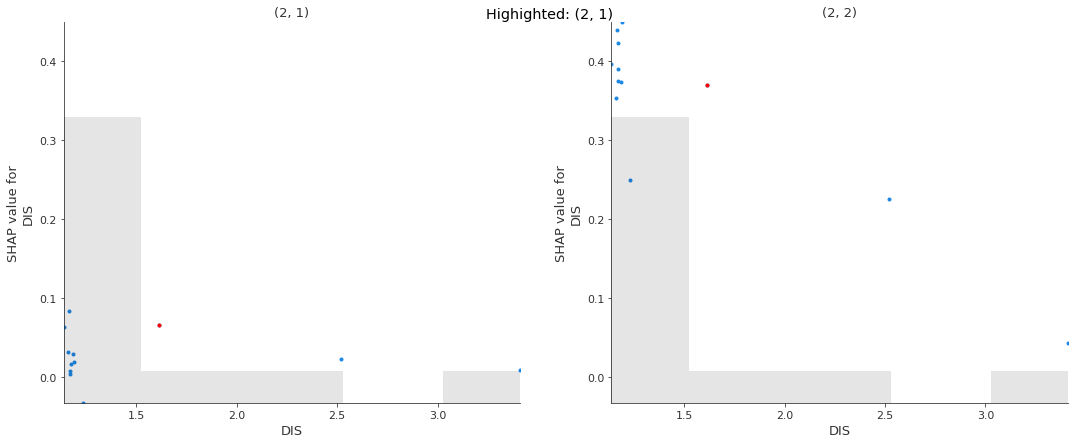

In [376]:
plot_next_feature()

In [379]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['DIS'] = 2.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 1)     NaN      4
(2, 2)    11.0      7

#### diro2c

In [453]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]
diff_class

'(2, 1)'

In [454]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 21.2 s, sys: 116 ms, total: 21.3 s
Wall time: 21.5 s


In [455]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

AGE too has an effect towards $(1,1)$: setting it to 1 changes the prediction of the instance classified differently to this class.

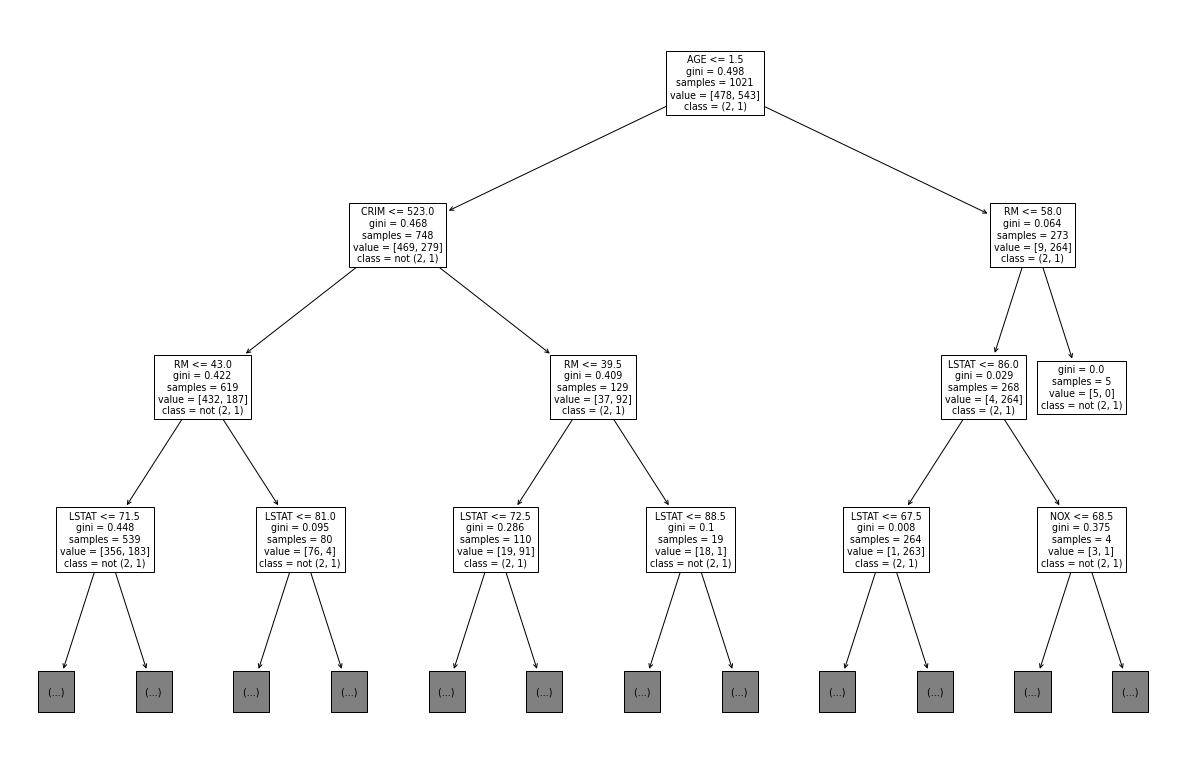

In [456]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

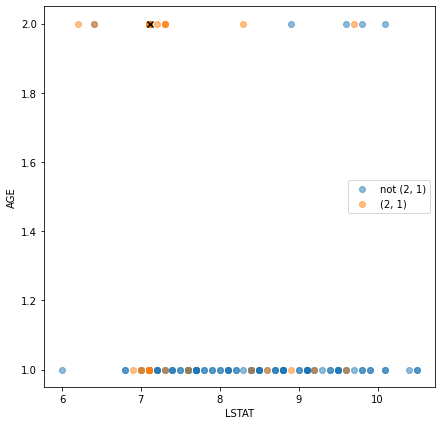

In [460]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'LSTAT', 'AGE', highlight=x)

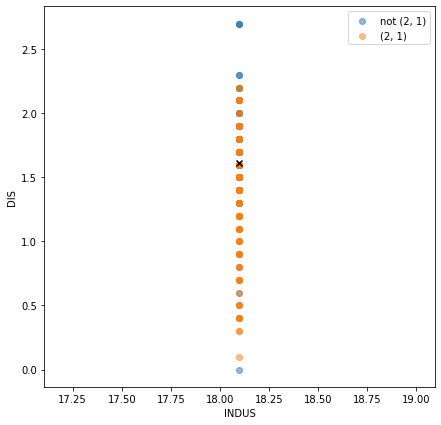

In [458]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'INDUS', 'DIS', highlight=x)

In [459]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(1, 2)     NaN      3
(2, 2)    11.0      8

### 5. Cluster

The following feature value distributions are different locally and globally:
- LSTAT only ranges from 5.5 to 8.5
- ZN only ranges up to 90
- INDUS only ranges up to 20
- CRIM only ranges up to 1.5
- TAX only ranges from 221 to 411
- RAD only ranges up to 6

Comparing that to the global level, we can reason for instances in this cluster that:
- if LSTAT was higher, its effect would shift towards $(1,1)$: setting it to 9 changes both instances classified differently to this class.
- if LSTAT was lower, its effect would shift towards $(2,2)$: setting it to 4.5 changes both instances classified differently to this class.
- if ZN was higher, its effect would shift towards $(2,2)$: setting it to 91 changes both instances classified differently to this class.
- if INDUS was higher, its effect would shift towards $(1,1)$: setting it to 21 changes both instances classified differently to this class.
- if RAD was higher, its effect would shift towards $(2,2)$: setting it to 13 changes both instances classified differently to this class.

Yet these effects do not explain why some instances in this cluster are classified differently and some are not. By using the local explanations only I can reason that:
- if LSTAT was higher, its effect would shift towards $(1,1)$: setting it to 7.5 changes both instances classified differently to this class.
- if INDUS was lower, its effect would shift towards $(2,2)$: setting it to 5 changes the prediction of the instance originally classified $(2,1)$
- if INDUS and DIS were lower, their combined effect would shift towards $(2,2)$: setting $INDUS=5$ and $DIS=2$ changes the predictions of the instances classified differently to this class.

In [380]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

(0, 0)  (0, 1)  (0, 2)  (1, 0)  (1, 1)  (1, 2)  (2, 0)  (2, 1)  (2, 2)
c6       0       0       0       0      14       1       0       1      10

In [381]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

CRIM         ZN      INDUS        NOX         RM        AGE  \
count  26.000000  26.000000  26.000000  26.000000  26.000000  26.000000   
mean    0.383505  22.199869   6.716622   0.547131   6.773972   1.000000   
std     0.389935  27.746031   5.190103   0.114132   0.647476   0.938083   
min     0.009060   0.000000   1.250000   0.400000   5.834000   0.000000   
25%     0.066323   0.000000   3.970000   0.439750   6.282250   0.000000   
50%     0.231415  20.000000   3.970000   0.538000   6.564000   1.000000   
75%     0.623965  27.935080   8.140000   0.647000   7.326298   2.000000   
max     1.425020  90.000000  19.580000   0.871000   8.104051   2.000000   

             DIS        RAD         TAX    PTRATIO      LSTAT  
count  26.000000  26.000000   26.000000  26.000000  26.000000  
mean    4.456906   4.193945  294.944138  16.902490   6.994314  
std     2.820881   1.573240   57.411989   3.254745   0.770088  
min     1.757300   1.000000  221.361452  13.000000   5.490000  
25%     2.035358   4.000000  264.000000  13.000000   6.457543  
50%     4.117381   5.000000  273.000000  17.900000   7.031453  
75%     5.900525   5.000000  327.250000  19.675000   7.421762  
max    10.710300   6.787151  411.000000  22.000000   8.470000

In [382]:
df[pred_classes == diff_classes[0]]

CRIM   ZN  INDUS    NOX     RM  AGE     DIS  RAD    TAX  PTRATIO  LSTAT
4  0.30347  0.0   7.38  0.493  6.312  0.0  5.4159  5.0  287.0     19.6   6.15

In [385]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 9
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(1, 2)     NaN      2
(2, 1)     NaN      5
(2, 2)    10.0      3

In [388]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 4.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      1
(1, 2)     NaN      5
(2, 2)     NaN      8

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      10     10

In [393]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['ZN'] = 91
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      7
(1, 2)     NaN      3
(2, 1)     NaN      2
(2, 2)     NaN      2

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      10     10

In [396]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 21
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(1, 1)     NaN      3
(2, 1)     NaN      6
(2, 2)    10.0      1

In [404]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['RAD'] = 13
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      5
(1, 2)     NaN      3
(2, 1)     NaN      2
(2, 2)     NaN      4

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      10     10

#### SHAP-based Difference Classifier Explanations

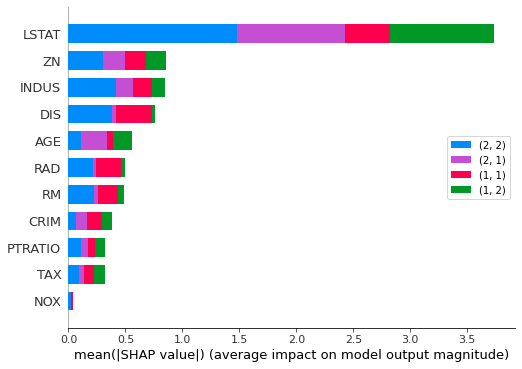

In [405]:
classes = np.unique(pred_classes)
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

4

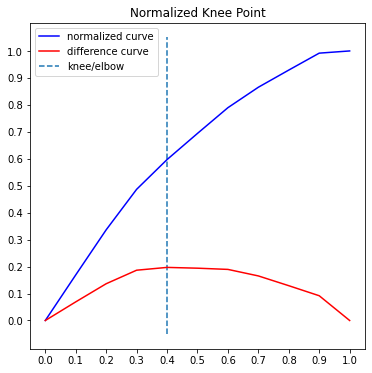

In [406]:
kneedle = KneeLocator(np.arange(feature_importances.shape[0]),
                      np.cumsum(-np.sort(-feature_importances.values)),
                      S=1.0, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
n_important_features = kneedle.knee
feature_order = feature_order[:n_important_features]
n_important_features

In [407]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, classes], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

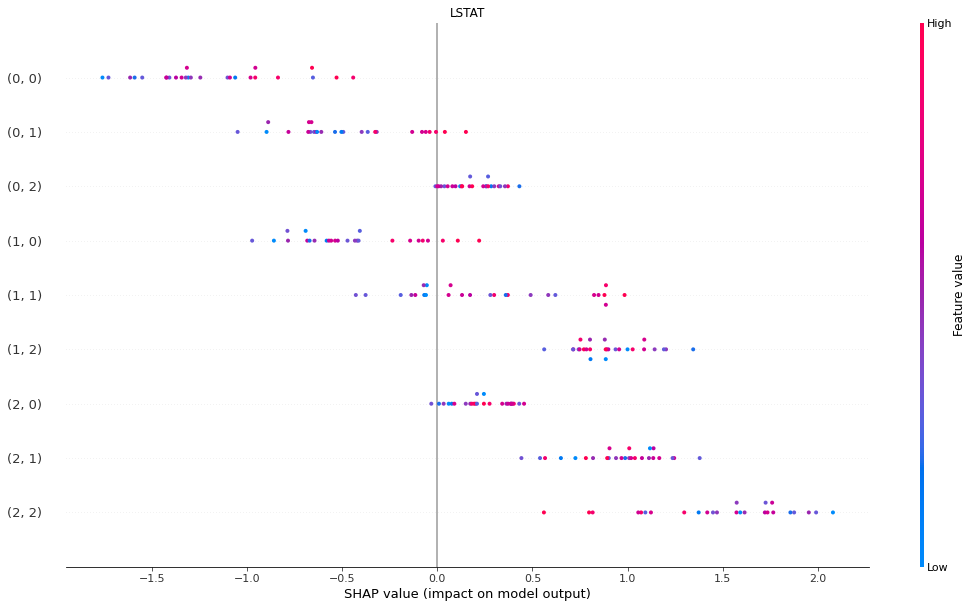

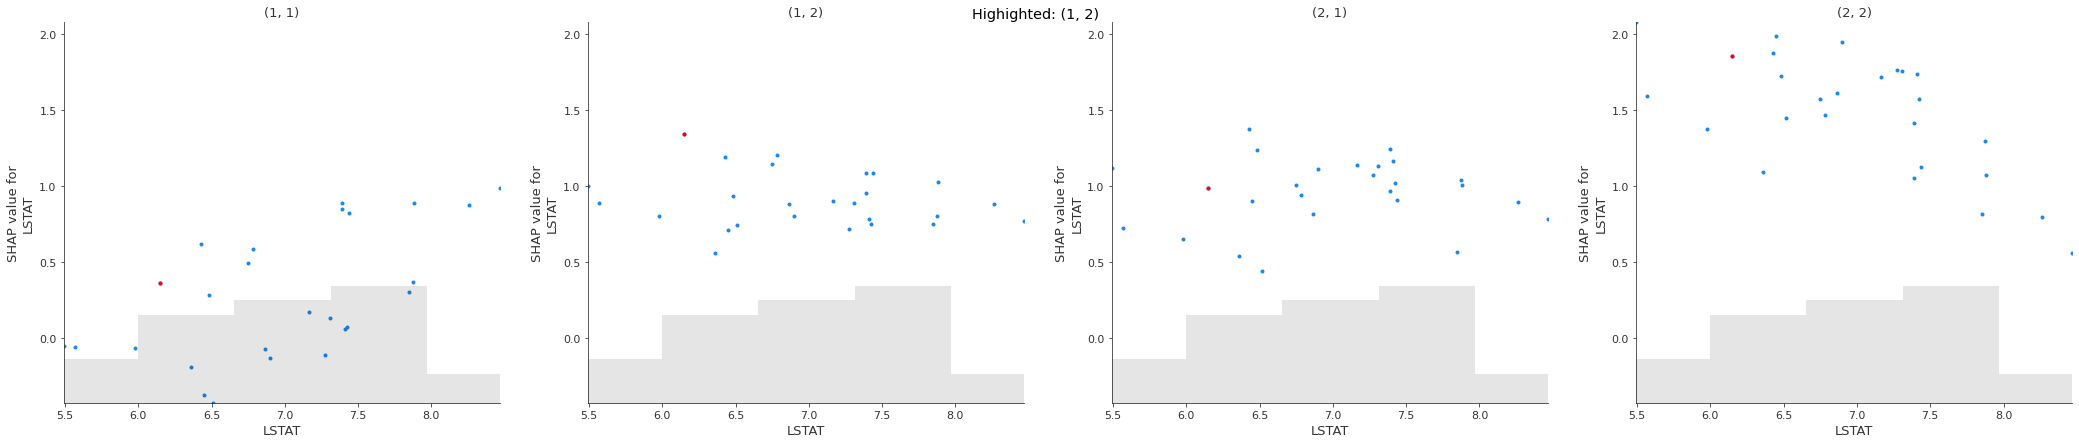

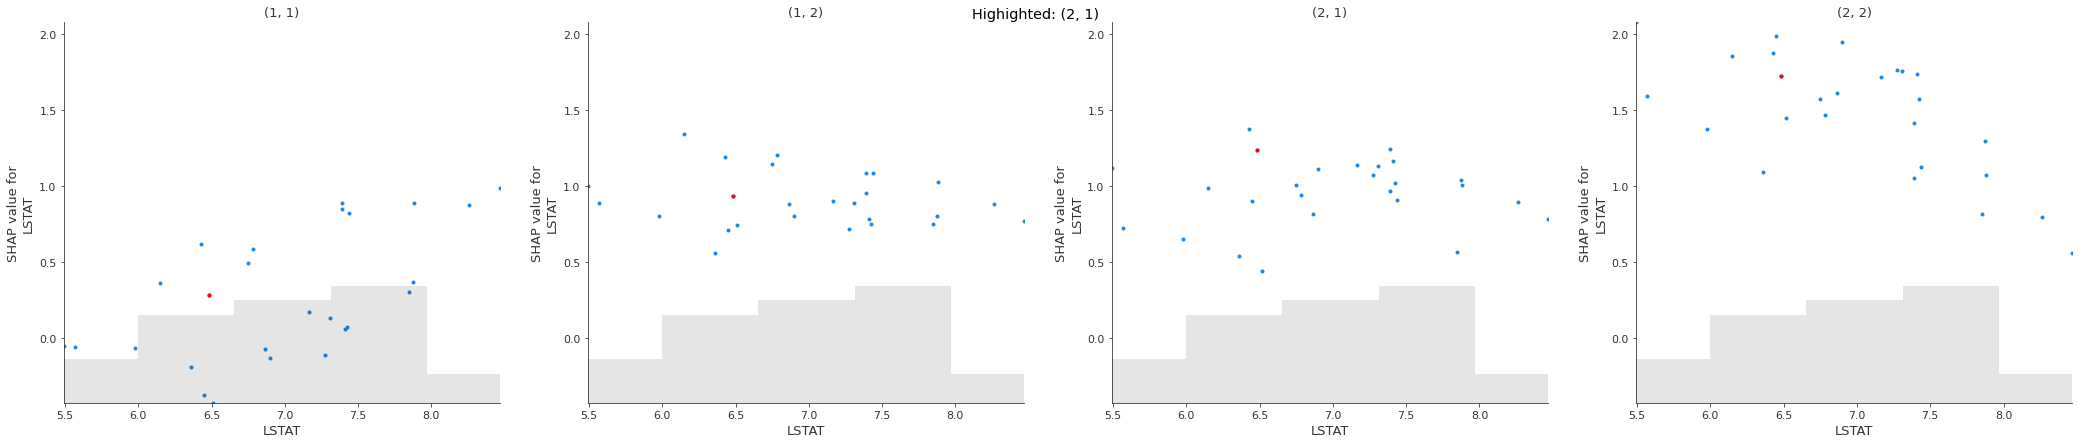

In [408]:
plot_next_feature()

In [411]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['LSTAT'] = 7.5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

before  after
(1, 1)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 2)      10     10

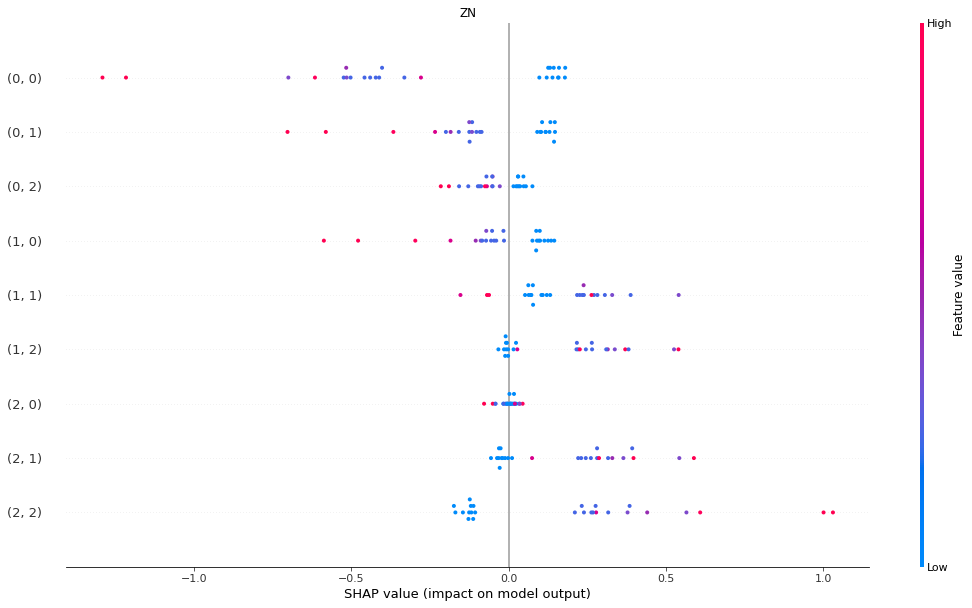

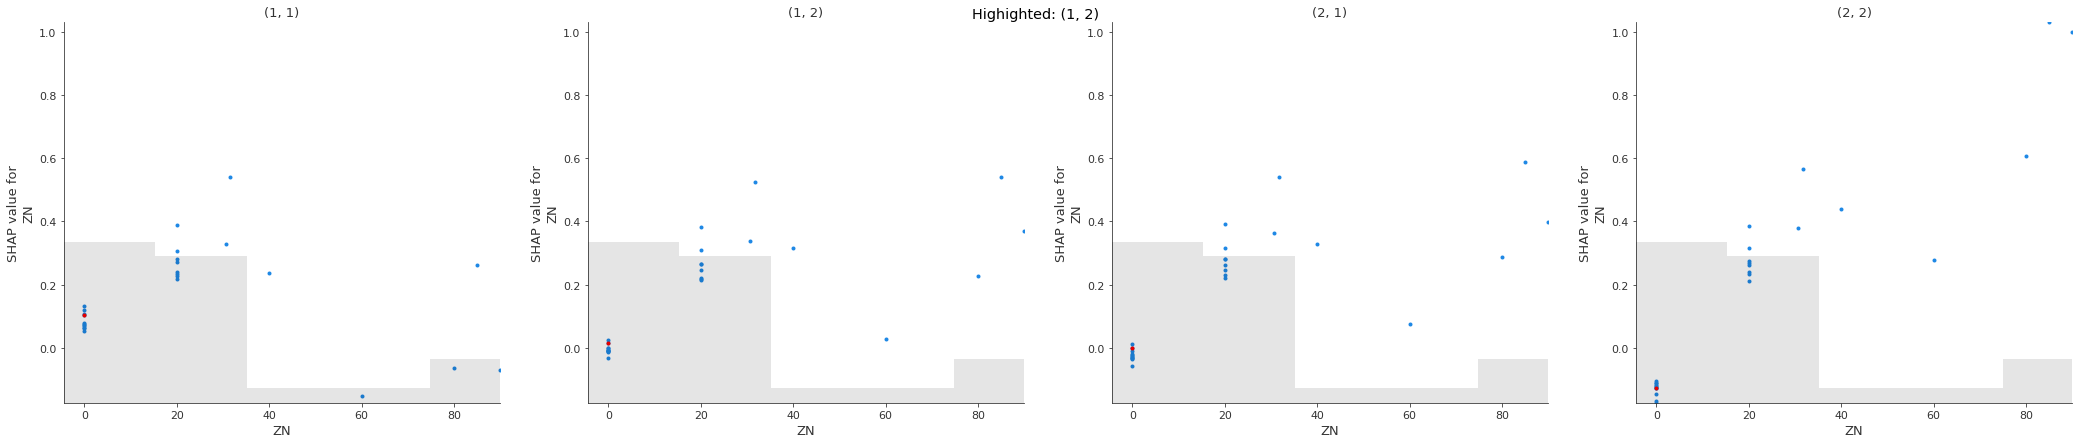

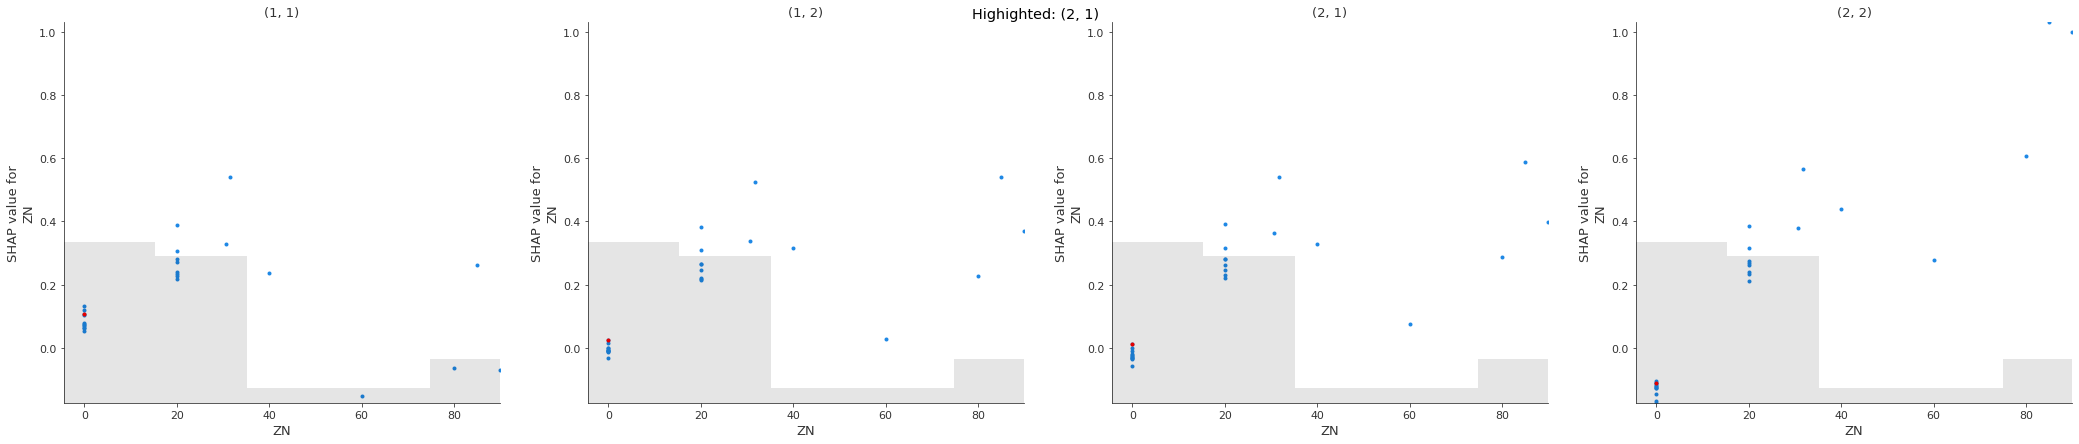

In [414]:
plot_next_feature()

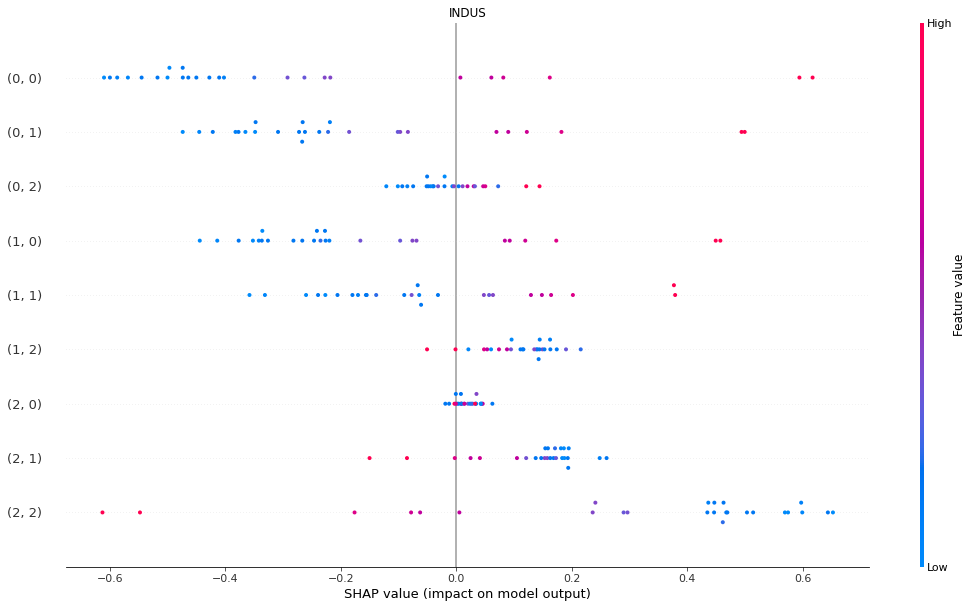

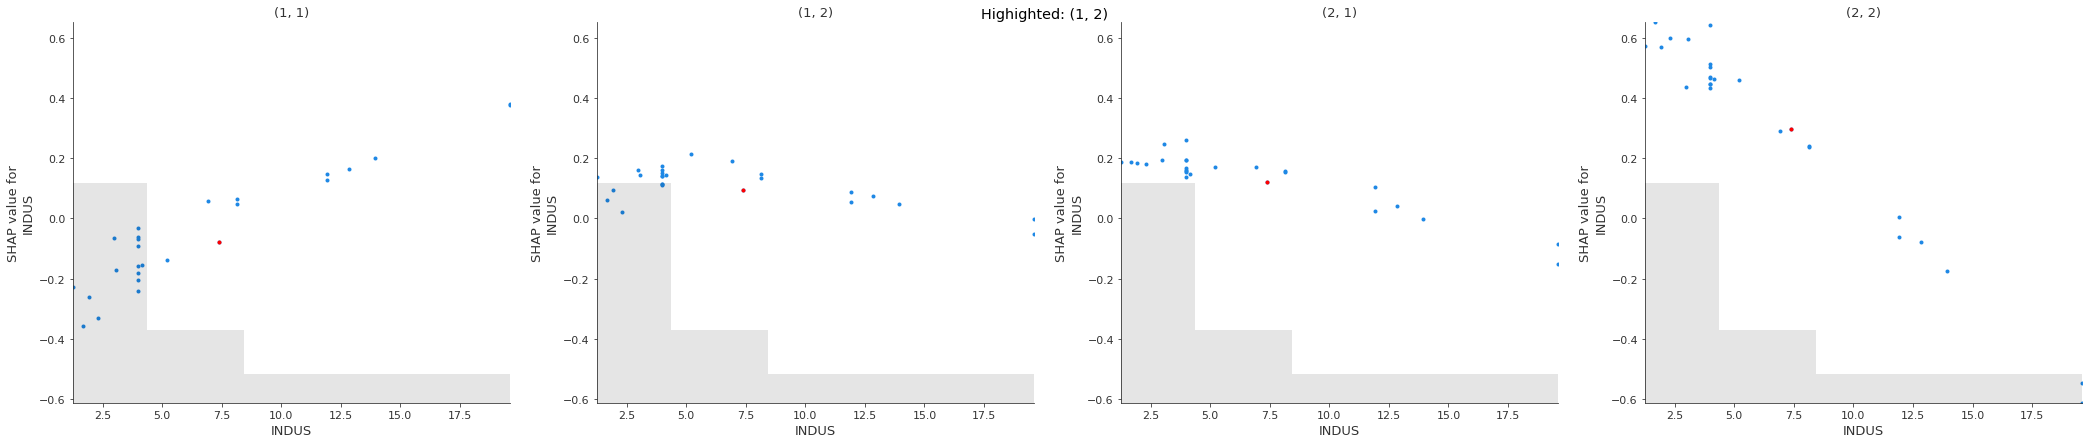

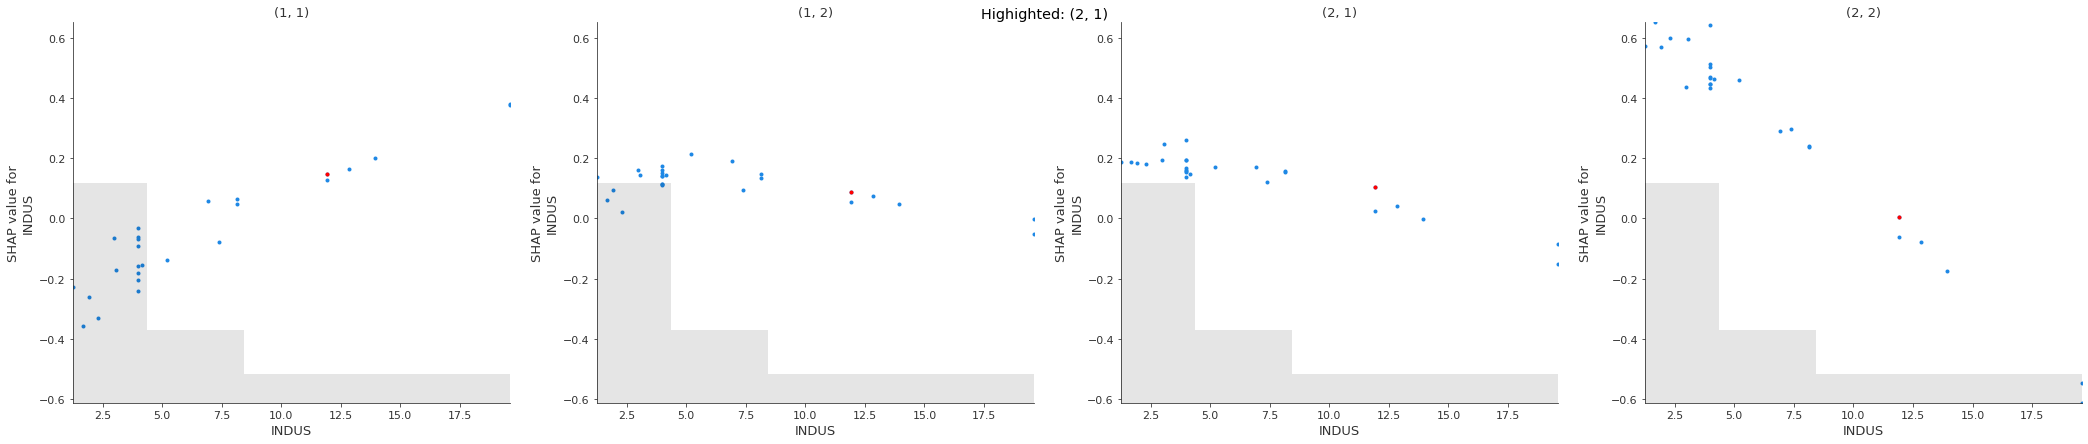

In [415]:
plot_next_feature()

In [421]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 5
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0     11
(1, 2)     NaN      1
(2, 2)     NaN      2

before  after
(1, 2)       1      1

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      10     10

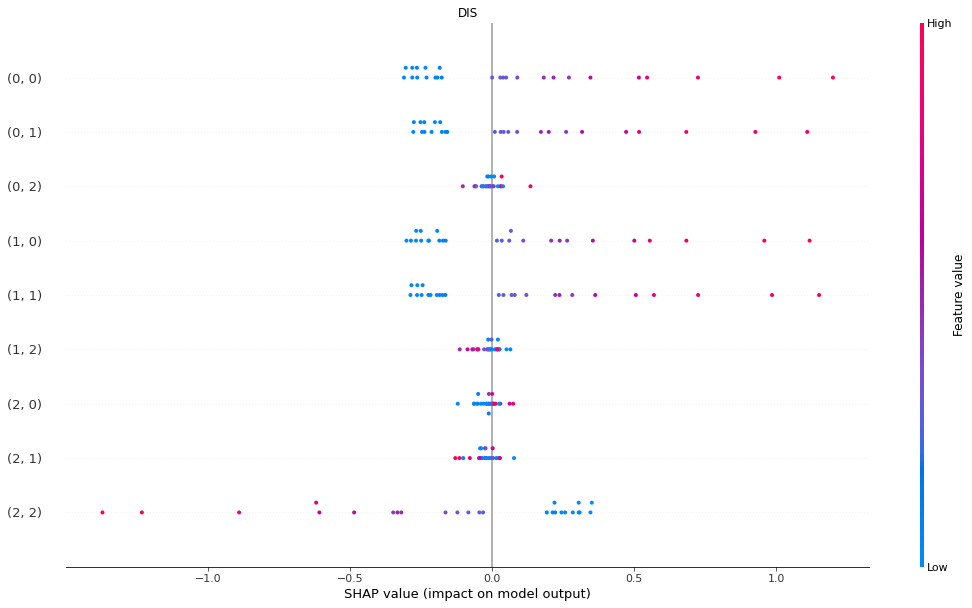

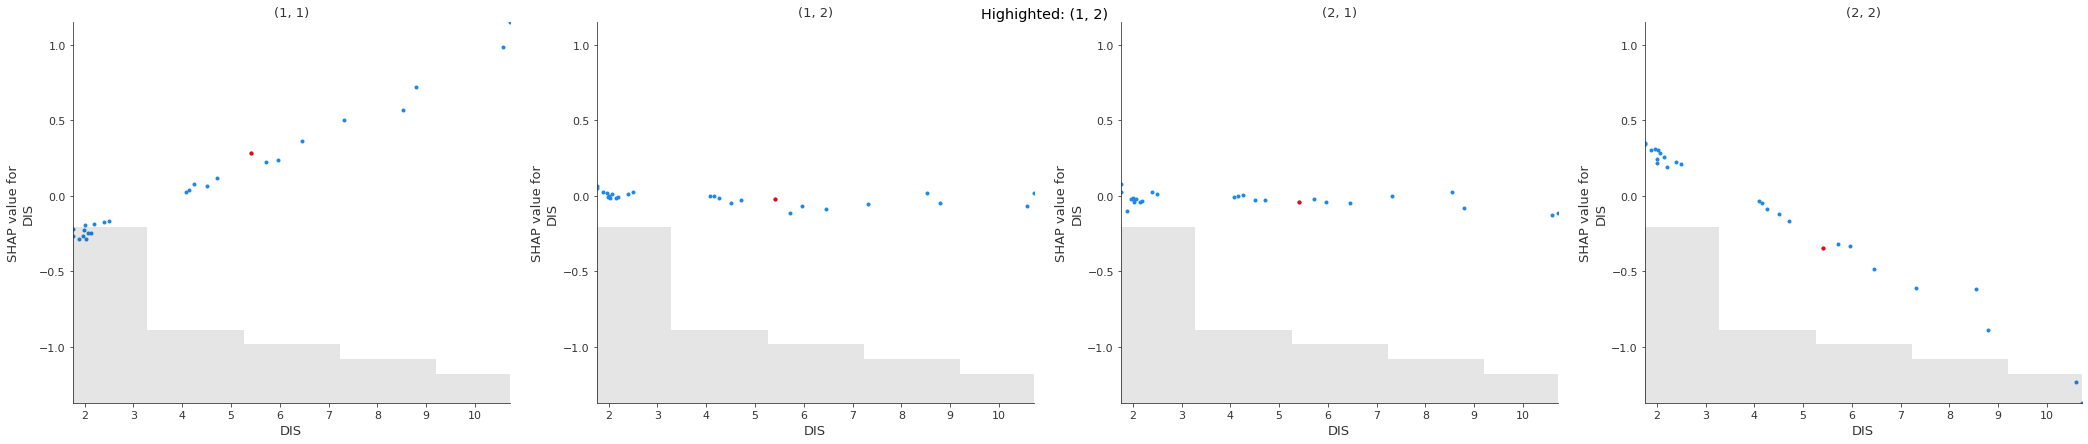

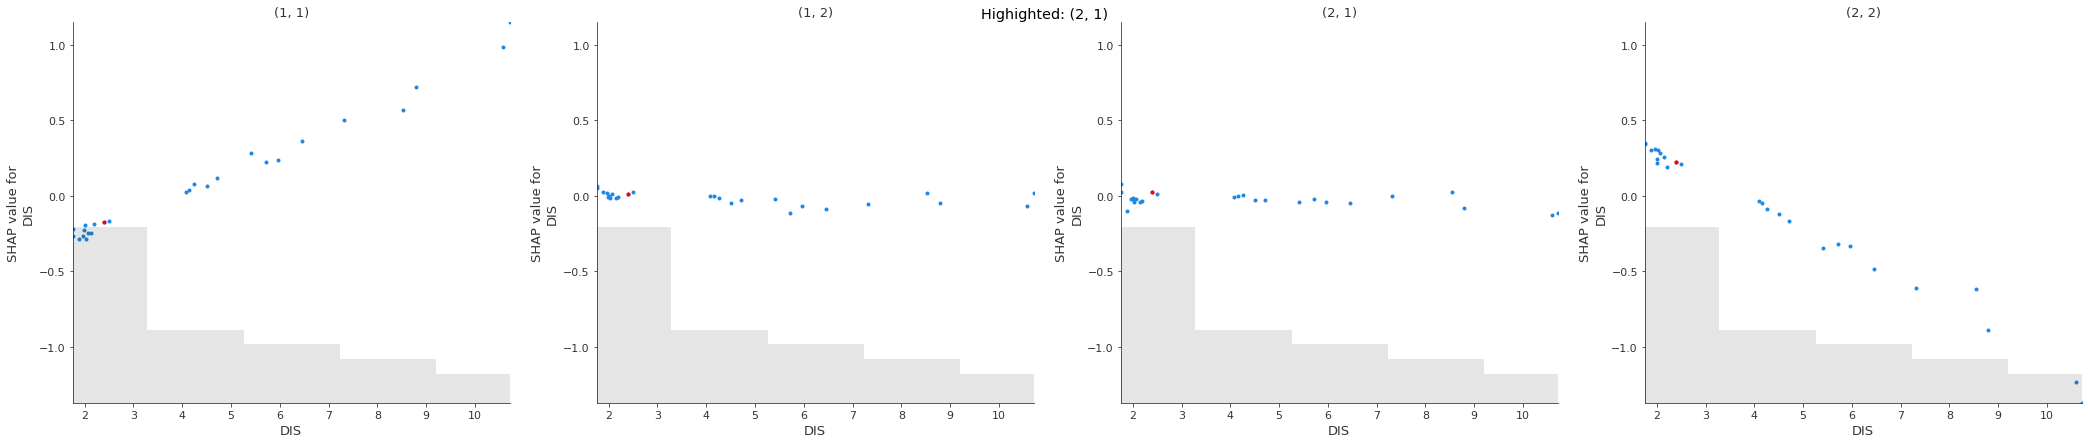

In [416]:
plot_next_feature()

In [422]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['DIS'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      6
(1, 2)     NaN      3
(2, 2)     NaN      5

before  after
(1, 2)       1      1

before  after
(2, 1)       1      1

before  after
(2, 2)      10     10

In [423]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['INDUS'] = 5
X['DIS'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      3
(1, 2)     NaN      3
(2, 2)     NaN      8

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 1)     1.0    NaN
(2, 2)     NaN    1.0

before  after
(2, 2)      10     10

#### diro2c

##### 1. Difference Class

In [436]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]
diff_class

'(1, 2)'

In [427]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 22.1 s, sys: 173 ms, total: 22.3 s
Wall time: 22.9 s


In [428]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

There is another possible explanation: $(1,2)$ is restricted to $AGE=0$, when increasing it to 1, the prediction of the instance changes to $(1,1)$ but when further increasing it to 2, the prediction of the instance changes to $(2,1)$, the other difference class.

It confirms my finding for higher LSTAT values, suggests that differences occur less often already lower at 6.2 upwards.

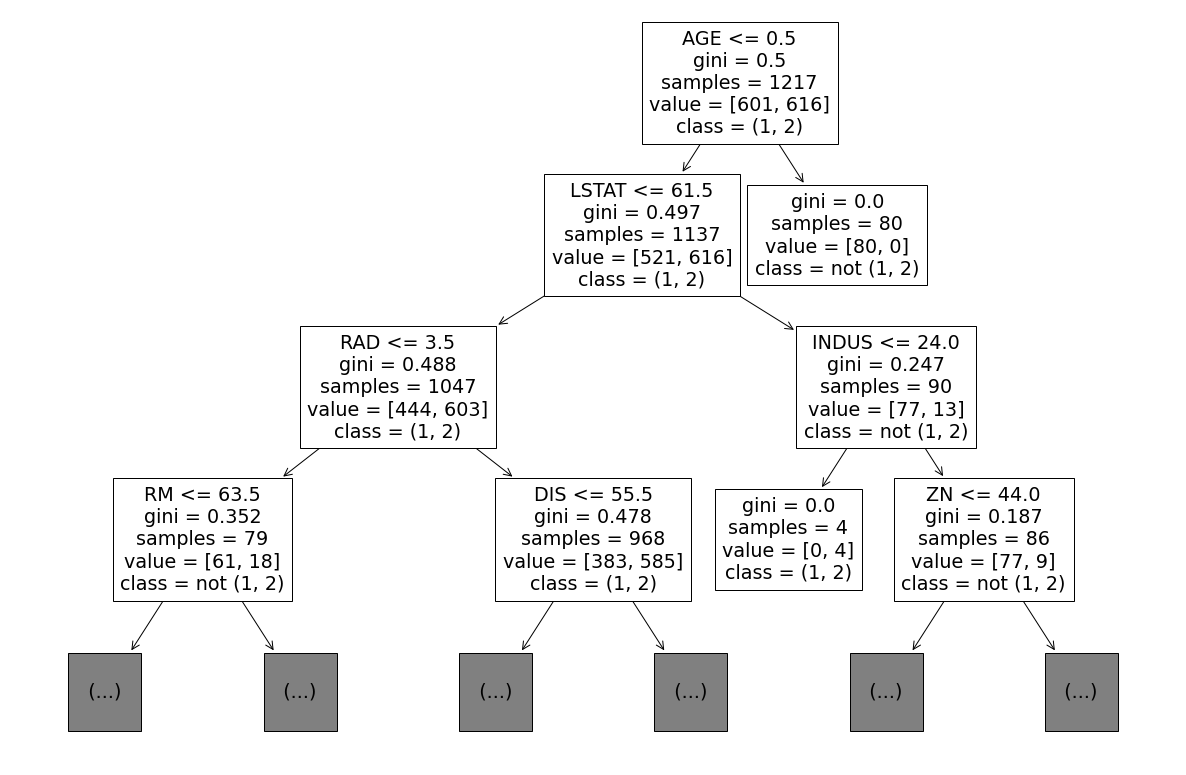

In [429]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

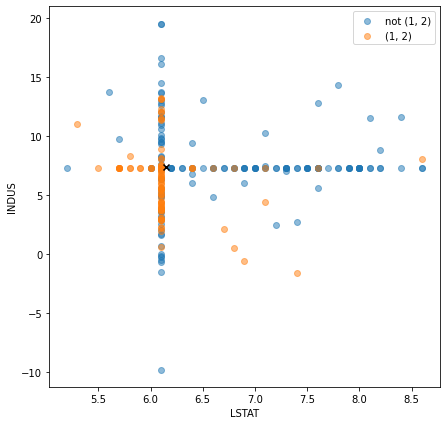

In [438]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'LSTAT', 'INDUS', highlight=x)

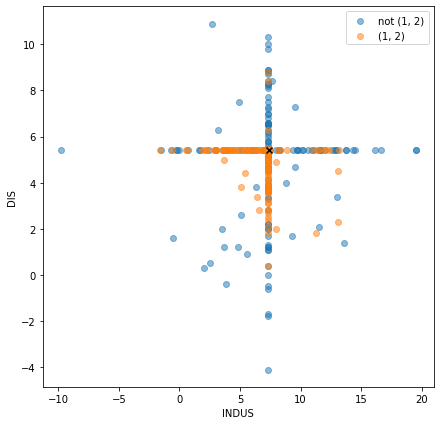

In [439]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'INDUS', 'DIS', highlight=x)

In [435]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

before  after
(1, 2)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 2)      10     10

In [437]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 2
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)    14.0      8
(2, 1)     NaN      6

before  after
(1, 2)     1.0    NaN
(2, 1)     NaN    1.0

before  after
(2, 1)       1      1

before  after
(2, 2)      10     10

##### 2. Difference Class

In [440]:
diff_class = diff_classes[1]
start_idx = np.where(pred_classes == diff_class)[0][0]
diff_class

'(2, 1)'

In [441]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class, scale_features=scale_features)
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

CPU times: user 21.9 s, sys: 203 ms, total: 22.1 s
Wall time: 22.4 s


In [442]:
with open(f'diro2c.{cluster}.{diff_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

Here too AGE is the feature in the root node. But decreasing the value just changes the prediction of the instance classified differently to the other difference class.

For this difference class, LSTAT starts to get classified not as this difference class more often from 7.5 upwards, which is the same limit identified in my approach.

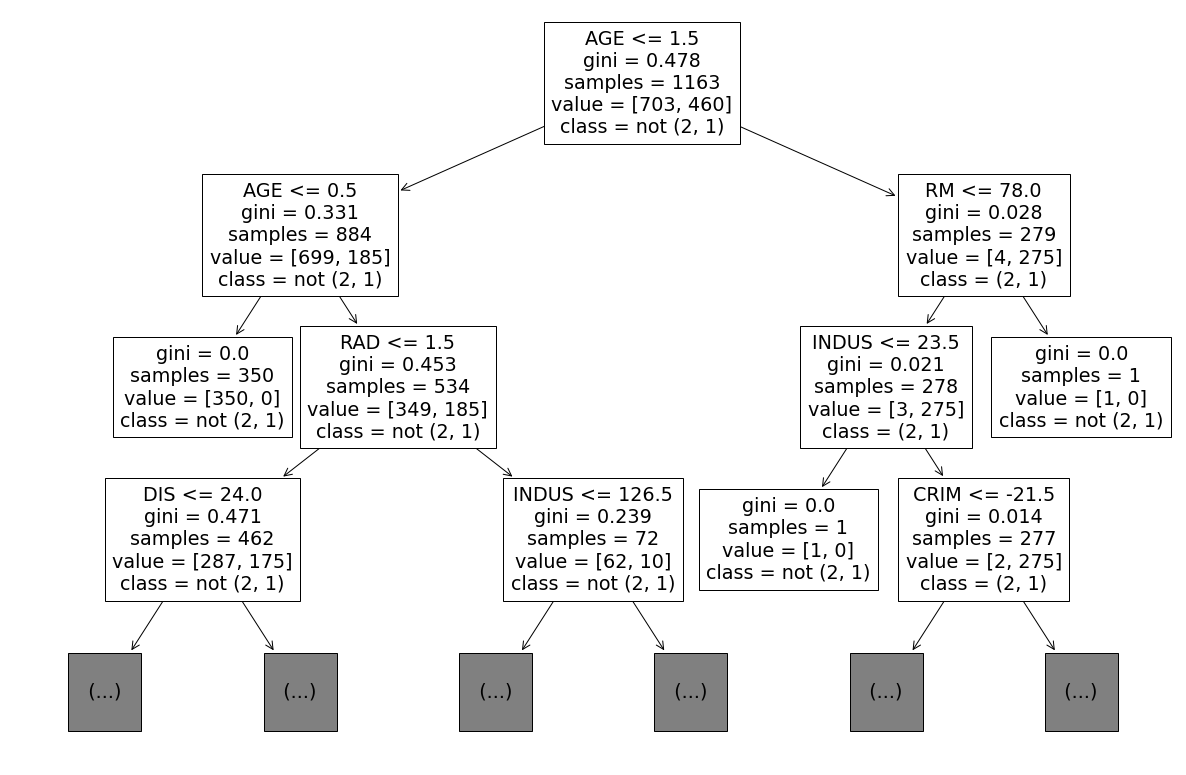

In [443]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

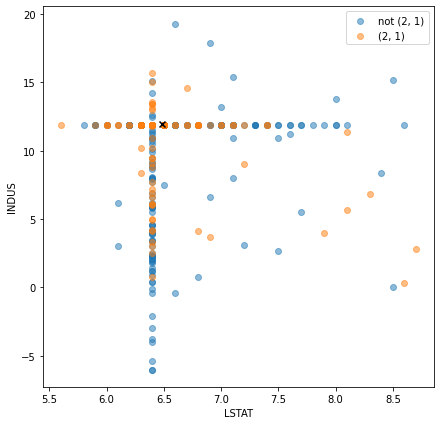

In [444]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'LSTAT', 'INDUS', highlight=x)

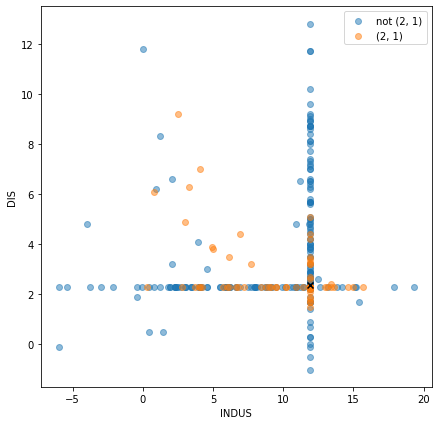

In [445]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'INDUS', 'DIS', highlight=x)

In [446]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 1
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

before  after
(1, 2)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 2)      10     10

In [447]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['AGE'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

before  after
(1, 1)      14     14

before  after
(1, 2)       1      1

before  after
(1, 2)     NaN    1.0
(2, 1)     1.0    NaN

before  after
(2, 2)      10     10